# CES Accuracy Analysis - Figures

This notebook generates all figures and tables for the CES Accuracy Analysis results section.

## Setup

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import pi
from scipy import stats
import seaborn as sns
import os

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300

# Ensure output directory exists
os.makedirs('output', exist_ok=True)

## Color Schemes

In [32]:
# =============================================================================
# COLOR SCHEME - Consistent, colorblind-friendly palette for scientific figures
# Based on Paul Tol's qualitative palette with modifications for print clarity
# =============================================================================

# Weighting method colors - Blue-to-warm progression
WEIGHTING_COLORS = {
    'CES-Unweighted': '#332288',         # Deep indigo
    'CES-Provided Weights': '#6699CC',   # Steel blue  
    'ANESRake-Full': '#CC6677',          # Dusty rose
    'ANESRake-Restricted': '#882255'     # Deep burgundy
}

# Variable class colors - Distinct, accessible palette
CLASS_COLORS = {
    'Demographic': '#4477AA',            # Muted blue
    'Voting Administration': '#EE6677',  # Soft coral
    'Candidate Choice': '#228833'        # Forest green
}

# Variable type colors - Clear contrast pair
VARIABLE_TYPE_COLORS = {
    'Primary': '#BBBBBB',                # Medium gray
    'Secondary': '#4477AA'               # Muted blue (matches demographic)
}

# Specificity colors
SPECIFICITY_COLORS = {
    'Candidate': '#228833',              # Forest green
    'Party': '#CCBB44'                   # Olive gold
}

# Legend labels (display names for figures)
# Keys must match data column values; values are what appears in figures
WEIGHTING_LABELS = {
    'CES-Unweighted': 'Matching Only',
    'CES-Provided Weights': 'Matching + Post-Stratification',
    'ANESRake-Full': 'Matching + ANESRake Weights (Full)',
    'ANESRake-Restricted': 'Matching + ANESRake Weights (Restricted)'
}

# Print color scheme for reference
print("Color scheme loaded:")
print(f"  Classes: {list(CLASS_COLORS.keys())}")
print(f"  Types: {list(VARIABLE_TYPE_COLORS.keys())}")
print(f"  Weighting: {list(WEIGHTING_COLORS.keys())}")



Color scheme loaded:
  Classes: ['Demographic', 'Voting Administration', 'Candidate Choice']
  Types: ['Primary', 'Secondary']
  Weighting: ['CES-Unweighted', 'CES-Provided Weights', 'ANESRake-Full', 'ANESRake-Restricted']


In [33]:
# =============================================================================
# HELPER FUNCTION: DataFrame to LaTeX table
# =============================================================================
def escape_latex(text):
    """Escape special LaTeX characters in text."""
    if pd.isna(text):
        return "-"
    text = str(text)
    # Escape special characters (order matters - backslash first)
    text = text.replace('\\', '\\textbackslash{}')
    text = text.replace('_', '\\_')
    text = text.replace('%', '\\%')
    text = text.replace('$', '\\$')
    text = text.replace('#', '\\#')
    text = text.replace('&', '\\&')
    text = text.replace('~', '\\textasciitilde{}')
    text = text.replace('^', '\\textasciicircum{}')
    return text

def df_to_latex_table(df, caption, label, note=None, float_format=".2f"):
    """Convert DataFrame to LaTeX table with threeparttable formatting."""
    latex = []
    latex.append(r"\begin{table}[!htbp]")
    latex.append(r"\centering")
    latex.append(r"\footnotesize")
    latex.append(f"\\caption{{{escape_latex(caption)}}}")
    latex.append(f"\\label{{tab:{label}}}")
    latex.append(r"\begin{threeparttable}")
    
    # Determine column format
    has_index = df.index.name or not df.index.equals(pd.RangeIndex(len(df)))
    n_cols = len(df.columns) + (1 if has_index else 0)
    col_format = "l" + "c" * (n_cols - 1)
    latex.append(r"\begin{tabular}{" + col_format + "}")
    latex.append(r"\toprule")
    
    # Header - escape column names
    escaped_cols = [escape_latex(str(c)) for c in df.columns]
    if has_index:
        header = escape_latex(df.index.name or "") + " & " + " & ".join(escaped_cols) + r" \\"
    else:
        header = " & ".join(escaped_cols) + r" \\"
    latex.append(header)
    latex.append(r"\midrule")
    
    # Rows
    for idx, row in df.iterrows():
        if has_index:
            vals = [escape_latex(str(idx))]
        else:
            vals = []
        for v in row:
            if pd.isna(v):
                vals.append("-")
            elif isinstance(v, float):
                vals.append(f"{v:{float_format}}")
            else:
                vals.append(escape_latex(str(v)))
        latex.append(" & ".join(vals) + r" \\")
    
    latex.append(r"\bottomrule")
    latex.append(r"\end{tabular}")
    
    if note:
        latex.append(r"\begin{tablenotes}")
        latex.append(r"\footnotesize")
        latex.append(f"\\item \\textit{{Note:}} {escape_latex(note)}")
        latex.append(r"\end{tablenotes}")
    
    latex.append(r"\end{threeparttable}")
    latex.append(r"\end{table}")
    
    return "\n".join(latex)

def save_latex_table(content, filename):
    """Save LaTeX table to file."""
    with open(f'output/{filename}', 'w') as f:
        f.write(content)


In [34]:
# Load input tables
# most_specific: contains the most specific level for each observation (candidate when available, party otherwise)
# metrics_base_full: contains ALL data including both party and candidate level for same races

most_specific = pd.read_excel('input_tables/most_specific.xlsx')
metrics_base_full = pd.read_excel('input_tables/metrics_base.xlsx')

print("Data loaded successfully!")
print(f"most_specific: {most_specific.shape}")
print(f"metrics_base_full: {metrics_base_full.shape}")
print()
print("Columns in most_specific:")
print(most_specific.columns.tolist())
print()
print("Unique Weighting_Method values:")
print(most_specific['Weighting_Method'].unique())
print()
print("Unique Validity_Scheme values:")
print(most_specific['Validity_Scheme'].unique())

Data loaded successfully!
most_specific: (74270, 24)
metrics_base_full: (72920, 24)

Columns in most_specific:
['Year', 'State', 'Class', 'Variable', 'District', 'Category', 'Variable_Type', 'Used_in_ANESRake_Full', 'Used_in_ANESRake_Restricted', 'Valid_for_Accuracy_Full', 'Valid_for_Accuracy_Restricted', 'CES_Candidate', 'True_Candidate', 'Match_Score', 'Benchmark', 'CES_Unweighted', 'CES_Weighted', 'CES_ANESRake_Full', 'CES_ANESRake_Restricted', 'n_respondents', 'Specificity', 'Weighting_Method', 'Error', 'Validity_Scheme']

Unique Weighting_Method values:
['CES-Unweighted' 'CES-Provided Weights' 'ANESRake-Full'
 'ANESRake-Restricted']

Unique Validity_Scheme values:
['All' 'ANESRake - Full' 'ANESRake - Restricted']


## Helper Functions

In [35]:
def calculate_rmse(errors):
    """Calculate RMSE from a series of errors."""
    return np.sqrt(np.mean(errors**2))

def style_axis(ax, title=None, xlabel='', ylabel='RMSE (%)', ylim=None):
    """Apply consistent styling to an axis."""
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    if title:
        ax.set_title(title, fontsize=16)
    ax.set_xlabel(xlabel, fontsize=14)
    ax.set_ylabel(ylabel, fontsize=14)
    if ylim:
        ax.set_ylim(ylim)
    ax.tick_params(axis='both', labelsize=12)
    ax.grid(axis='y', linestyle='-', alpha=0.7, zorder=1)
    return ax

def save_figure(fig, filename, tight=True):
    """Save figure to output directory."""
    if tight:
        fig.tight_layout(pad=2.0)
    fig.savefig(f'output/{filename}', dpi=300, bbox_inches='tight')
    print(f"Saved: output/{filename}")


# Define sensible variable ordering
VARIABLE_ORDER = {
    'Age Group': 1, 'Sex': 2, 'Hispanic Origin': 3, 'Education': 4,
    'Family Income': 5, 'Employment Status': 6, 'Union Membership': 7,
    'Veteran Status': 8, 'State of Residence': 9, 'Residence Duration': 10,
    'Voter Registration': 20, 'Voting Turnout': 21, 'Voting Method': 22,
    'President': 30, 'U.S. Senate': 31, 'U.S. House': 32, 'Governor': 33,
    'Attorney General': 34, 'Secretary of State': 35, 'State Senator': 36,
    'State Representative': 37
}

# Map variables to their class
VARIABLE_CLASS = {
    'Age Group': 'Demographic', 'Education': 'Demographic', 'Sex': 'Demographic',
    'Hispanic Origin': 'Demographic', 'Employment Status': 'Demographic',
    'Family Income': 'Demographic', 'Union Membership': 'Demographic',
    'Veteran Status': 'Demographic', 'Residence Duration': 'Demographic',
    'State of Residence': 'Demographic',
    'Voter Registration': 'Voting Administration', 'Voting Turnout': 'Voting Administration',
    'Voting Method': 'Voting Administration',
    'President': 'Candidate Choice', 'U.S. Senate': 'Candidate Choice',
    'U.S. House': 'Candidate Choice', 'Governor': 'Candidate Choice',
    'Attorney General': 'Candidate Choice', 'Secretary of State': 'Candidate Choice',
    'State Senator': 'Candidate Choice', 'State Representative': 'Candidate Choice'
}

def sort_variables(df, var_col='Variable'):
    """Sort DataFrame by sensible variable ordering."""
    df = df.copy()
    df['_sort_order'] = df[var_col].map(VARIABLE_ORDER)
    df['_sort_order'] = df['_sort_order'].fillna(999)
    df = df.sort_values('_sort_order').drop(columns=['_sort_order'])
    return df

def get_variable_class(var_name):
    """Get the class for a variable."""
    return VARIABLE_CLASS.get(var_name, 'Unknown')

def save_latex(latex_str, filename):
    """Save LaTeX string to file."""
    with open(f'output/{filename}', 'w') as f:
        f.write(latex_str)
    print(f"Saved: output/{filename}")

---
# CES Sample Description

In [ ]:
# =============================================================================
# CES SAMPLE DESCRIPTION TABLE
# =============================================================================

print("="*100)
print("CES SAMPLE DESCRIPTION TABLE")
print("="*100)

# Sample description data (hardcoded from CES documentation)
sample_data = [
    (2006, "36,421", "No", "not published", "November 7 -- November 21"),
    (2008, "32,800", "No", r"46.8\%", "November 4 -- November 18"),
    (2010, "55,400", "No", r"40.4\%", "November 2 -- November 16"),
    (2012, "54,535", "No", r"34.5\%", "November 6 -- November 20"),
    (2014, "56,200", "No", r"23.4\%", "November 4 -- November 18"),
    (2016, "64,600", "No", r"13.9\%", "November 9 -- December 14"),
    (2018, "60,000", "No", r"30.0\%", "November 7 -- December 3"),
    (2020, "61,000", "No", r"61.2\%", "November 8 -- December 14"),
    (2022, "60,000", "No", r"47.6\%", "November 10 -- December 15"),
]

latex = []
latex.append(r"\begin{table}[!htbp]")
latex.append(r"\centering")
latex.append(r"\footnotesize")
latex.append(r"\caption{CES Sample Description, 2006 -- 2022}")
latex.append(r"\label{tab:sample_description}")
latex.append(r"\begin{threeparttable}")
latex.append(r"\begin{tabular}{lcccc}")
latex.append(r"\toprule")
latex.append(r"Year & Sample Size & Probability Sample? & Response Rate & Field Dates \\")
latex.append(r"\midrule")

for year, n, prob, rate, dates in sample_data:
    latex.append(f"{year} & {n} & {prob} & {rate} & {dates}" + r" \\")

latex.append(r"\bottomrule")
latex.append(r"\end{tabular}")
latex.append(r"\begin{tablenotes}")
latex.append(r"\footnotesize")
latex.append(r"\item \textit{Source:} Cooperative Election Study Common Content documentation for each year.")
latex.append(r"\item \textit{Note:} All samples are non-probability samples recruited from online panels. Response rates calculated as completed interviews divided by initial invitations.")
latex.append(r"\end{tablenotes}")
latex.append(r"\end{threeparttable}")
latex.append(r"\end{table}")

latex_str = "\n".join(latex)
save_latex(latex_str, 'sample_description.tex')

print("\nTable saved to output/sample_description.tex")


---
# CPS Sample Description

In [ ]:
# =============================================================================
# CPS SAMPLE DESCRIPTION TABLE
# =============================================================================

print("="*100)
print("CPS SAMPLE DESCRIPTION TABLE")
print("="*100)

# CPS sample description data (hardcoded from BLS)
cps_data = [
    (2006, "1,221,832", "Yes", r"91.7\%", "Monthly"),
    (2008, "1,209,862", "Yes", r"91.7\%", "Monthly"),
    (2010, "1,230,780", "Yes", r"92.0\%", "Monthly"),
    (2012, "1,215,614", "Yes", r"90.4\%", "Monthly"),
    (2014, "1,218,742", "Yes", r"88.9\%", "Monthly"),
    (2016, "1,202,067", "Yes", r"86.7\%", "Monthly"),
    (2018, "1,150,355", "Yes", r"84.4\%", "Monthly"),
    (2020, "1,001,837", "Yes", r"74.3\%", "Monthly"),
    (2022, "964,927", "Yes", r"72.9\%", "Monthly"),
]

latex = []
latex.append(r"\begin{table}[!htbp]")
latex.append(r"\centering")
latex.append(r"\footnotesize")
latex.append(r"\caption{CPS Sample Description, 2006 -- 2022}")
latex.append(r"\label{tab:cps_sample_description}")
latex.append(r"\begin{threeparttable}")
latex.append(r"\begin{tabular}{lcccc}")
latex.append(r"\toprule")
latex.append(r"Year & Sample Size & Probability Sample? & Completion Rate & Field Dates \\")
latex.append(r"\midrule")

for year, n, prob, rate, dates in cps_data:
    latex.append(f"{year} & {n} & {prob} & {rate} & {dates}" + r" \\")

latex.append(r"\bottomrule")
latex.append(r"\end{tabular}")
latex.append(r"\begin{tablenotes}")
latex.append(r"\footnotesize")
latex.append(r"\item \textit{Source:} U.S. Bureau of Labor Statistics. \url{https://www.bls.gov/cps/methods/response_rates.htm}")
latex.append(r"\item \textit{Note:} Sample sizes are annual totals across all monthly surveys. Completion rates are annual averages.")
latex.append(r"\end{tablenotes}")
latex.append(r"\end{threeparttable}")
latex.append(r"\end{table}")

latex_str = "\n".join(latex)
save_latex(latex_str, 'cps_sample_description.tex')

print("\nTable saved to output/cps_sample_description.tex")


---
# Figure 1: RMSE by Variable and Year (Matching + Post-Stratification)

Two versions:
- Version A: All variables with class labels and within-class averages
- Version B: Primary and Secondary sections with Class labels and averages

In [36]:
# Filter for Matching + Post-Strat., Validity_Scheme All
df_ces_weighted = most_specific[
    (most_specific['Weighting_Method'] == 'CES-Provided Weights') &
    (most_specific['Validity_Scheme'] == 'All')
].copy()

# Calculate RMSE by Year and Variable
rmse_by_var_year = df_ces_weighted.groupby(['Year', 'Variable', 'Variable_Type', 'Class']).apply(lambda x: np.sqrt(np.mean(x['Error'] ** 2))).reset_index(name='RMSE')

# Create pivot tables
rmse_pivot = rmse_by_var_year.pivot_table(
    index='Variable',
    columns='Year',
    values='RMSE'
)

# Variable type (Primary/Secondary) for each cell
type_pivot = rmse_by_var_year.pivot_table(
    index='Variable',
    columns='Year',
    values='Variable_Type',
    aggfunc='first'
)

# Class for each variable
class_map = rmse_by_var_year.groupby('Variable')['Class'].first().to_dict()

# Sort by variable ordering
rmse_pivot = sort_variables(rmse_pivot.reset_index()).set_index('Variable')
type_pivot = sort_variables(type_pivot.reset_index()).set_index('Variable')

years = sorted([c for c in rmse_pivot.columns if isinstance(c, (int, float))])

# Add Average column
rmse_pivot['Average'] = rmse_pivot[years].mean(axis=1)

# Add Average row at BOTTOM
avg_row = rmse_pivot.mean(axis=0)
avg_row.name = 'Average'
rmse_pivot_with_avg = pd.concat([rmse_pivot, avg_row.to_frame().T])

print("="*100)
print("FIGURE 1: RMSE by Variable and Year (Matching + Post-Stratification)")
print("="*100)

FIGURE 1: RMSE by Variable and Year (Matching + Post-Stratification)


/var/folders/xf/837xl0rs49194z6g15hkf22m0000gn/T/ipykernel_39252/2068975567.py:8: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  rmse_by_var_year = df_ces_weighted.groupby(['Year', 'Variable', 'Variable_Type', 'Class']).apply(lambda x: np.sqrt(np.mean(x['Error'] ** 2))).reset_index(name='RMSE')


In [13]:
# ============================================================
# VERSION A: All variables with class subtotals
# ============================================================
print("\n" + "="*80)
print("VERSION A: All variables with class labels and within-class averages")
print("="*80)

# Calculate within-class averages
class_order = ['Demographic', 'Voting Administration', 'Candidate Choice']
class_values_a = {cls: {year: [] for year in years} for cls in class_order}
class_row_avgs_a = {cls: [] for cls in class_order}

for var in rmse_pivot.index:
    var_class = class_map.get(var, 'Unknown')
    if var_class not in class_order:
        continue
    for year in years:
        val = rmse_pivot.loc[var, year]
        if not pd.isna(val):
            class_values_a[var_class][year].append(val)
    row_avg = rmse_pivot_with_avg.loc[var, 'Average']
    if not pd.isna(row_avg):
        class_row_avgs_a[var_class].append(row_avg)

class_subtotals_a = {}
for cls in class_order:
    class_subtotals_a[cls] = {}
    for year in years:
        vals = class_values_a[cls][year]
        class_subtotals_a[cls][year] = np.mean(vals) if vals else float('nan')
    year_avgs = [class_subtotals_a[cls][y] for y in years if not pd.isna(class_subtotals_a[cls][y])]
    class_subtotals_a[cls]['row_avg'] = np.mean(year_avgs) if year_avgs else float('nan')

# Build LaTeX for Version A
latex_a = []
latex_a.append(r"\begin{table}[!htbp]")
latex_a.append(r"\centering")
latex_a.append(r"\footnotesize")
latex_a.append(r"\caption{Matching + Post-Stratification RMSE by Variable and Year}")
latex_a.append(r"\label{tab:rmse_ces_weighted_all}")
latex_a.append(r"\begin{threeparttable}")

col_format = "l" + "c" * (len(years) + 1)
latex_a.append(r"\begin{tabular}{" + col_format + "}")
latex_a.append(r"\midrule")
latex_a.append(r"\midrule")

header = "Variable & " + " & ".join([str(int(y)) for y in years]) + r" & Yearly Mean \\"
latex_a.append(header)
latex_a.append(r"\midrule")

current_class = None
for cls in class_order:
    if current_class is not None:
        latex_a.append(r"\addlinespace[0.3em]")
    latex_a.append(r"\multicolumn{" + str(len(years) + 2) + r"}{l}{\textit{" + cls + r"}} \\")
    latex_a.append(r"\addlinespace[0.2em]")
    current_class = cls
    
    for var in rmse_pivot.index:
        var_class = class_map.get(var, 'Unknown')
        if var_class != cls:
            continue
        
        row_vals = ["~~" + var]
        for year in years:
            val = rmse_pivot.loc[var, year]
            if pd.isna(val):
                # * = Office not on ballot that year (e.g., President in non-presidential years)
                # - = CES did not measure vote choice for that office that year
                if var == "President" and year not in [2008, 2012, 2016, 2020]:
                    row_vals.append(r"*")
                else:
                    row_vals.append(r"-")
            else:
                var_type = type_pivot.loc[var, year] if var in type_pivot.index and year in type_pivot.columns else None
                if var_type == 'Primary':
                    row_vals.append(f"{val:.1f}" + r"\dag")
                else:
                    row_vals.append(f"{val:.1f}")
        # Add row average for this variable
        var_avg = rmse_pivot_with_avg.loc[var, 'Average']
        if pd.isna(var_avg):
            row_vals.append("")
        else:
            row_vals.append(f"{var_avg:.1f}")
        latex_a.append(" & ".join(row_vals) + r" \\")
    
    # Within-class average
    latex_a.append(r"\addlinespace[0.1em]")
    subtotal_vals = [r"{\fontseries{sb}\selectfont\textcolor{black!85}{~~" + cls + " Avg.}}"]
    for year in years:
        val = class_subtotals_a[cls][year]
        if pd.isna(val):
            subtotal_vals.append("-")
        else:
            subtotal_vals.append(r"{\fontseries{sb}\selectfont\textcolor{black!85}{" + f"{val:.1f}" + "}}")
    row_avg = class_subtotals_a[cls]['row_avg']
    if pd.isna(row_avg):
        subtotal_vals.append("")
    else:
        subtotal_vals.append(r"{\fontseries{sb}\selectfont\textcolor{black!85}{" + f"{row_avg:.1f}" + "}}")
    latex_a.append(" & ".join(subtotal_vals) + r" \\")

# Yearly RMSE row
latex_a.append(r"\midrule")
row_vals = [r"\textbf{Yearly RMSE}"]
yearly_rmse_values = []
for year in years:
    val = rmse_pivot_with_avg.loc['Average', year]
    if pd.isna(val):
        # Use symbol logic for yearly RMSE row as well
        if year not in [2008, 2012, 2016, 2020]:
            row_vals.append(r"*")
        else:
            row_vals.append(r"-")
    else:
        row_vals.append(r"\textbf{" + f"{val:.1f}" + "}")
        yearly_rmse_values.append(val)
annual_avg = np.mean(yearly_rmse_values) if yearly_rmse_values else float('nan')
if pd.isna(annual_avg):
    row_vals.append("")
else:
    row_vals.append(r"\textbf{" + f"{annual_avg:.1f}" + "}")
latex_a.append(" & ".join(row_vals) + r" \\")

latex_a.append(r"\bottomrule")
latex_a.append(r"\end{tabular}")
latex_a.append(r"\begin{tablenotes}")
latex_a.append(r"\footnotesize")
latex_a.append(r"\item \dag~indicates Primary variables (used in CES post-stratification weighting for that year).")
latex_a.append(r"\item * Office not on ballot that year.")
latex_a.append(r"\item - CES did not measure vote choice for that office that year.")
latex_a.append(r"\item \textit{2006 Note:} CES 2006 documentation does not specify which variables were used for post-stratification. We assume all variables are Secondary for this year, though this is likely incorrect given that weights were provided.")
latex_a.append(r"\item \textit{Note:} All values are RMSE in percentage points. Yearly Mean shows the row-wise average across all years.")
latex_a.append(r"\end{tablenotes}")
latex_a.append(r"\end{threeparttable}")
latex_a.append(r"\end{table}")

latex_a_str = "\n".join(latex_a)
print("\n" + "="*80)
print("LaTeX Table Code (Version A):")
print("="*80)
print(latex_a_str)

save_latex(latex_a_str, 'rmse_ces_weighted_all.tex')


VERSION A: All variables with class labels and within-class averages

LaTeX Table Code (Version A):
\begin{table}[!htbp]
\centering
\footnotesize
\caption{Matching + Post-Stratification RMSE by Variable and Year}
\label{tab:rmse_ces_weighted_all}
\begin{threeparttable}
\begin{tabular}{lcccccccccc}
\midrule
\midrule
Variable & 2006 & 2008 & 2010 & 2012 & 2014 & 2016 & 2018 & 2020 & 2022 & Yearly Mean \\
\midrule
\multicolumn{11}{l}{\textit{Demographic}} \\
\addlinespace[0.2em]
~~Age Group & 6.9 & 3.3\dag & 4.8\dag & 2.8\dag & 2.8\dag & 2.6\dag & 4.0\dag & 4.7\dag & 5.2\dag & 4.1 \\
~~Sex & 5.2 & 6.8\dag & 5.0\dag & 1.5\dag & 2.0\dag & 1.3\dag & 2.9\dag & 2.5\dag & 3.1\dag & 3.4 \\
~~Hispanic Origin & - & - & 7.6 & 8.1 & 7.5 & 7.6 & 7.8 & 7.0 & 2.7 & 6.9 \\
~~Education & 13.0 & 3.3\dag & 6.1\dag & 3.5\dag & 3.9\dag & 5.7\dag & 4.4\dag & 4.5\dag & 3.8\dag & 5.3 \\
~~Family Income & 4.5 & 3.5 & 3.9 & 3.9 & 4.4 & 4.9 & 5.3 & 6.8 & 8.8 & 5.1 \\
~~Employment Status & 7.0 & 10.3 & 10.6 & 13.5

In [14]:
# ============================================================
# OBSERVATION COUNTS TABLE BY VARIABLE AND YEAR
# All variables with dagger marks for Primary variables
# ============================================================

# Filter for CES-Weighted, All validity - ALL variables (both Primary and Secondary)
df_counts = most_specific[
    (most_specific['Weighting_Method'] == 'CES-Provided Weights') &
    (most_specific['Validity_Scheme'] == 'All')
].copy()

years_count = sorted(df_counts['Year'].unique())

# Count observations per variable per year
count_pivot = df_counts.groupby(['Variable', 'Year']).size().unstack(fill_value=0)

# Get Variable_Type for each variable-year combination (to mark Primary variables)
type_pivot = df_counts.groupby(['Variable', 'Year'])['Variable_Type'].first().unstack(fill_value='')

# Add Sum column
count_pivot['Sum'] = count_pivot.sum(axis=1)

# Calculate totals per year
year_totals = count_pivot[years_count].sum(axis=0)
grand_total = count_pivot['Sum'].sum()

# Variable to class mapping
class_map_counts = df_counts.groupby('Variable')['Class'].first().to_dict()

# Define variable order by class
class_order_counts = ['Demographic', 'Voting Administration', 'Candidate Choice']

# Sort variables using the same ordering as the RMSE tables
count_pivot_sorted = sort_variables(count_pivot.reset_index(), 'Variable').set_index('Variable')

# Group variables by class in sorted order
var_by_class = {cls: [] for cls in class_order_counts}
for var in count_pivot_sorted.index:
    cls = class_map_counts.get(var, 'Unknown')
    if cls in var_by_class:
        var_by_class[cls].append(var)

# Build LaTeX table
latex_counts = []
latex_counts.append(r"\begin{table}[!htbp]")
latex_counts.append(r"\centering")
latex_counts.append(r"\footnotesize")
latex_counts.append(r"\caption{Number of Observations by Variable and Year}")
latex_counts.append(r"\label{tab:observation_counts}")
latex_counts.append(r"\begin{threeparttable}")

col_format = "l" + "c" * (len(years_count) + 1)
latex_counts.append(r"\begin{tabular}{" + col_format + "}")
latex_counts.append(r"\toprule")

# Header
header = "Variable & " + " & ".join([str(int(y)) for y in years_count]) + r" & Sum \\"
latex_counts.append(header)
latex_counts.append(r"\midrule")

# Variables by class in the specified order
for cls in class_order_counts:
    if cls != class_order_counts[0]:
        latex_counts.append(r"\addlinespace[0.3em]")
    latex_counts.append(r"\multicolumn{" + str(len(years_count) + 2) + r"}{l}{\textit{" + cls + r"}} \\")
    latex_counts.append(r"\addlinespace[0.2em]")
    
    # Use the ordered variables from var_by_class
    for var in var_by_class[cls]:
        row_vals = ["~~" + var]
        for year in years_count:
            val = count_pivot.loc[var, year]
            if val == 0:
                # Use * for President in non-presidential years, - otherwise
                if var == "President" and year not in [2008, 2012, 2016, 2020]:
                    row_vals.append(r"*")
                else:
                    row_vals.append(r"-")
            else:
                # Check if this variable is Primary in this year
                var_type = type_pivot.loc[var, year] if var in type_pivot.index and year in type_pivot.columns else ''
                if var_type == 'Primary':
                    row_vals.append(f"{int(val):,}" + r"\dag")
                else:
                    row_vals.append(f"{int(val):,}")
        # Sum
        row_sum = count_pivot.loc[var, 'Sum']
        row_vals.append(f"{int(row_sum):,}")
        latex_counts.append(" & ".join(row_vals) + r" \\")

# Total row
latex_counts.append(r"\midrule")
row_vals = [r"\textbf{Total Errors per Year}"]
for year in years_count:
    val = year_totals[year]
    row_vals.append(r"\textbf{" + f"{int(val):,}" + "}")
row_vals.append(r"\textbf{" + f"{int(grand_total):,}" + "}")
latex_counts.append(" & ".join(row_vals) + r" \\")

latex_counts.append(r"\bottomrule")
latex_counts.append(r"\end{tabular}")
latex_counts.append(r"\begin{tablenotes}")
latex_counts.append(r"\footnotesize")
latex_counts.append(r"\item \dag~indicates Primary variables (used in CES post-stratification weighting for that year).")
latex_counts.append(r"\item * Office not on ballot that year.")
latex_counts.append(r"\item - CES did not measure that variable.")
latex_counts.append(r"\item \textit{Note:} Shows number of state-level observations (errors) for each variable by year.")
latex_counts.append(r"\end{tablenotes}")
latex_counts.append(r"\end{threeparttable}")
latex_counts.append(r"\end{table}")

latex_counts_str = "\n".join(latex_counts)

# Save to file
with open('output/observation_counts.tex', 'w') as f:
    f.write(latex_counts_str)
print("Saved: output/observation_counts.tex")

# Print summary
print("\n" + "="*70)
print("OBSERVATION COUNTS SUMMARY")
print("="*70)
print(f"\nTotal observations: {grand_total:,}")
print(f"\nPer year:")
for year in years_count:
    print(f"  {year}: {int(year_totals[year]):,}")

print(f"\nPer variable (in table order):")
for cls in class_order_counts:
    print(f"\n  {cls}:")
    for var in var_by_class[cls]:
        print(f"    {var}: {int(count_pivot.loc[var, 'Sum']):,}")

Saved: output/observation_counts.tex

OBSERVATION COUNTS SUMMARY

Total observations: 9,974

Per year:
  2006: 765
  2008: 868
  2010: 978
  2012: 1,234
  2014: 1,248
  2016: 1,237
  2018: 1,201
  2020: 1,240
  2022: 1,203

Per variable (in table order):

  Demographic:
    Age Group: 459
    Sex: 459
    Hispanic Origin: 357
    Education: 459
    Family Income: 459
    Employment Status: 459
    Union Membership: 459
    Veteran Status: 459
    Residence Duration: 306

  Voting Administration:
    Voter Registration: 459
    Voting Turnout: 450
    Voting Method: 458

  Candidate Choice:
    President: 204
    U.S. Senate: 303
    U.S. House: 2,889
    Governor: 225
    Attorney General: 175
    Secretary of State: 146
    State Senator: 384
    State Representative: 405


In [15]:
# ============================================================
# VERSION B: Primary and Secondary sections
# ============================================================
print("\n" + "="*80)
print("VERSION B: Primary and Secondary sections with Class labels and averages")
print("="*80)

# Separate data by variable type
primary_data = rmse_by_var_year[rmse_by_var_year['Variable_Type'] == 'Primary'].copy()
secondary_data = rmse_by_var_year[rmse_by_var_year['Variable_Type'] == 'Secondary'].copy()

def build_section_latex(data, section_title):
    """Build LaTeX for a Primary or Secondary section."""
    lines = []
    
    if len(data) == 0:
        return lines
    
    pivot = data.pivot_table(index='Variable', columns='Year', values='RMSE')
    pivot = sort_variables(pivot.reset_index()).set_index('Variable')
    sect_years = sorted([c for c in pivot.columns if isinstance(c, (int, float))])
    
    pivot['Average'] = pivot[sect_years].mean(axis=1)
    avg_row = pivot.mean(axis=0)
    avg_row.name = 'Average'
    pivot_with_avg = pd.concat([pivot, avg_row.to_frame().T])
    
    sect_class_map = data.groupby('Variable')['Class'].first().to_dict()
    
    # Calculate class subtotals
    sect_class_values = {cls: {year: [] for year in years} for cls in class_order}
    for var in pivot.index:
        var_class = sect_class_map.get(var, 'Unknown')
        if var_class not in class_order:
            continue
        for year in years:
            if year in pivot.columns:
                val = pivot.loc[var, year]
                if not pd.isna(val):
                    sect_class_values[var_class][year].append(val)
    
    sect_class_subtotals = {}
    for cls in class_order:
        sect_class_subtotals[cls] = {}
        for year in years:
            vals = sect_class_values[cls][year]
            sect_class_subtotals[cls][year] = np.mean(vals) if vals else float('nan')
        year_avgs = [sect_class_subtotals[cls][y] for y in years if not pd.isna(sect_class_subtotals[cls][y])]
        sect_class_subtotals[cls]['row_avg'] = np.mean(year_avgs) if year_avgs else float('nan')
    
    lines.append(r"\midrule")
    lines.append(r"\multicolumn{" + str(len(years) + 2) + r"}{c}{\textbf{" + section_title + r"}} \\")
    lines.append(r"\midrule")
    
    current_class = None
    for cls in class_order:
        cls_vars = [v for v in pivot.index if sect_class_map.get(v) == cls]
        if not cls_vars:
            continue
        
        if current_class is not None:
            lines.append(r"\addlinespace[0.3em]")
        lines.append(r"\multicolumn{" + str(len(years) + 2) + r"}{l}{\textit{" + cls + r"}} \\")
        lines.append(r"\addlinespace[0.2em]")
        current_class = cls
        
        for var in pivot.index:
            if sect_class_map.get(var) != cls:
                continue
            row_vals = ["~~" + var]
            for year in years:
                if year in pivot.columns:
                    val = pivot.loc[var, year]
                    if pd.isna(val):
                        row_vals.append("-")
                    else:
                        row_vals.append(f"{val:.1f}")
                else:
                    row_vals.append("-")
            # Add row average for this variable
            var_avg = pivot.loc[var, 'Average']
            if pd.isna(var_avg):
                row_vals.append("")
            else:
                row_vals.append(f"{var_avg:.1f}")
            lines.append(" & ".join(row_vals) + r" \\")
        
        # Class average
        lines.append(r"\addlinespace[0.1em]")
        subtotal_vals = [r"{\fontseries{sb}\selectfont\textcolor{black!85}{~~" + cls + " Avg.}}"]
        for year in years:
            val = sect_class_subtotals[cls][year]
            if pd.isna(val):
                subtotal_vals.append("-")
            else:
                subtotal_vals.append(r"{\fontseries{sb}\selectfont\textcolor{black!85}{" + f"{val:.1f}" + "}}")
        row_avg = sect_class_subtotals[cls]['row_avg']
        if pd.isna(row_avg):
            subtotal_vals.append("")
        else:
            subtotal_vals.append(r"{\fontseries{sb}\selectfont\textcolor{black!85}{" + f"{row_avg:.1f}" + "}}")
        lines.append(" & ".join(subtotal_vals) + r" \\")
    
    # Yearly RMSE row for this section
    lines.append(r"\midrule")
    row_vals = [r"\textbf{Yearly RMSE}"]
    yearly_vals = []
    for year in years:
        if year in pivot_with_avg.columns:
            val = pivot_with_avg.loc['Average', year]
            if pd.isna(val):
                row_vals.append("-")
            else:
                row_vals.append(r"\textbf{" + f"{val:.1f}" + "}")
                yearly_vals.append(val)
        else:
            row_vals.append("-")
    sect_annual_avg = np.mean(yearly_vals) if yearly_vals else float('nan')
    if pd.isna(sect_annual_avg):
        row_vals.append("")
    else:
        row_vals.append(r"\textbf{" + f"{sect_annual_avg:.1f}" + "}")
    lines.append(" & ".join(row_vals) + r" \\")
    
    return lines

# Build Version B LaTeX
latex_b = []
latex_b.append(r"\begin{table}[!htbp]")
latex_b.append(r"\centering")
latex_b.append(r"\footnotesize")
latex_b.append(r"\caption{Matching + Post-Stratification RMSE by Variable and Year (Separated by Variable Type)}")
latex_b.append(r"\label{tab:rmse_ces_weighted_by_type}")
latex_b.append(r"\begin{threeparttable}")

col_format = "l" + "c" * (len(years) + 1)
latex_b.append(r"\begin{tabular}{" + col_format + "}")
latex_b.append(r"\midrule")
latex_b.append(r"\midrule")

header = "Variable & " + " & ".join([str(int(y)) for y in years]) + r" & Yearly Mean \\"
latex_b.append(header)

# Primary section
latex_b.extend(build_section_latex(primary_data, "Primary Variables (used in CES weighting)"))

# Secondary section
latex_b.extend(build_section_latex(secondary_data, "Secondary Variables (not used in CES weighting)"))

latex_b.append(r"\bottomrule")
latex_b.append(r"\end{tabular}")
latex_b.append(r"\begin{tablenotes}")
latex_b.append(r"\footnotesize")
latex_b.append(r"\item \textit{2006 Note:} CES 2006 documentation does not specify which variables were used for post-stratification. We assume all variables are Secondary for this year, though this is likely incorrect given that weights were provided.")
latex_b.append(r"\item \textit{Note:} All values are RMSE in percentage points.")
latex_b.append(r"\end{tablenotes}")
latex_b.append(r"\end{threeparttable}")
latex_b.append(r"\end{table}")

latex_b_str = "\n".join(latex_b)
print("\n" + "="*80)
print("LaTeX Table Code (Version B):")
print("="*80)
print(latex_b_str)

save_latex(latex_b_str, 'rmse_ces_weighted_by_type.tex')


VERSION B: Primary and Secondary sections with Class labels and averages

LaTeX Table Code (Version B):
\begin{table}[!htbp]
\centering
\footnotesize
\caption{Matching + Post-Stratification RMSE by Variable and Year (Separated by Variable Type)}
\label{tab:rmse_ces_weighted_by_type}
\begin{threeparttable}
\begin{tabular}{lcccccccccc}
\midrule
\midrule
Variable & 2006 & 2008 & 2010 & 2012 & 2014 & 2016 & 2018 & 2020 & 2022 & Yearly Mean \\
\midrule
\multicolumn{11}{c}{\textbf{Primary Variables (used in CES weighting)}} \\
\midrule
\multicolumn{11}{l}{\textit{Demographic}} \\
\addlinespace[0.2em]
~~Age Group & - & 3.3 & 4.8 & 2.8 & 2.8 & 2.6 & 4.0 & 4.7 & 5.2 & 3.8 \\
~~Sex & - & 6.8 & 5.0 & 1.5 & 2.0 & 1.3 & 2.9 & 2.5 & 3.1 & 3.1 \\
~~Education & - & 3.3 & 6.1 & 3.5 & 3.9 & 5.7 & 4.4 & 4.5 & 3.8 & 4.4 \\
\addlinespace[0.1em]
{\fontseries{sb}\selectfont\textcolor{black!85}{~~Demographic Avg.}} & - & {\fontseries{sb}\selectfont\textcolor{black!85}{4.4}} & {\fontseries{sb}\selectfont\text

---
# RMSE by Variable and Year (Matching Only)

In [16]:
# Filter for Unweighted
df_unweighted = most_specific[
    (most_specific['Weighting_Method'] == 'CES-Unweighted') &
    (most_specific['Validity_Scheme'] == 'All')
].copy()

# Calculate RMSE by Year and Variable
rmse_unwtd = df_unweighted.groupby(['Year', 'Variable', 'Variable_Type', 'Class']).apply(lambda x: np.sqrt(np.mean(x['Error'] ** 2))).reset_index(name='RMSE')

rmse_unwtd_pivot = rmse_unwtd.pivot_table(index='Variable', columns='Year', values='RMSE')
rmse_unwtd_pivot = sort_variables(rmse_unwtd_pivot.reset_index()).set_index('Variable')

unwtd_years = sorted([c for c in rmse_unwtd_pivot.columns if isinstance(c, (int, float))])
rmse_unwtd_pivot['Average'] = rmse_unwtd_pivot[unwtd_years].mean(axis=1)

avg_row_unwtd = rmse_unwtd_pivot.mean(axis=0)
avg_row_unwtd.name = 'Average'
rmse_unwtd_with_avg = pd.concat([rmse_unwtd_pivot, avg_row_unwtd.to_frame().T])

unwtd_class_map = rmse_unwtd.groupby('Variable')['Class'].first().to_dict()

# Calculate class subtotals for unweighted
unwtd_class_values = {cls: {year: [] for year in unwtd_years} for cls in class_order}
for var in rmse_unwtd_pivot.index:
    var_class = unwtd_class_map.get(var, 'Unknown')
    if var_class not in class_order:
        continue
    for year in unwtd_years:
        val = rmse_unwtd_pivot.loc[var, year]
        if not pd.isna(val):
            unwtd_class_values[var_class][year].append(val)

unwtd_class_subtotals = {}
for cls in class_order:
    unwtd_class_subtotals[cls] = {}
    for year in unwtd_years:
        vals = unwtd_class_values[cls][year]
        unwtd_class_subtotals[cls][year] = np.mean(vals) if vals else float('nan')
    year_avgs = [unwtd_class_subtotals[cls][y] for y in unwtd_years if not pd.isna(unwtd_class_subtotals[cls][y])]
    unwtd_class_subtotals[cls]['row_avg'] = np.mean(year_avgs) if year_avgs else float('nan')

# Build LaTeX for unweighted
latex_unwtd = []
latex_unwtd.append(r"\begin{table}[!htbp]")
latex_unwtd.append(r"\centering")
latex_unwtd.append(r"\footnotesize")
latex_unwtd.append(r"\caption{Matching Only RMSE by Variable and Year}")
latex_unwtd.append(r"\label{tab:rmse_matching_only}")
latex_unwtd.append(r"\begin{threeparttable}")

col_format = "l" + "c" * (len(unwtd_years) + 1)
latex_unwtd.append(r"\begin{tabular}{" + col_format + "}")
latex_unwtd.append(r"\midrule")
latex_unwtd.append(r"\midrule")

header = "Variable & " + " & ".join([str(int(y)) for y in unwtd_years]) + r" & Yearly Mean \\"
latex_unwtd.append(header)
latex_unwtd.append(r"\midrule")

current_class = None
for cls in class_order:
    cls_vars = [v for v in rmse_unwtd_pivot.index if unwtd_class_map.get(v) == cls]
    if not cls_vars:
        continue
    
    if current_class is not None:
        latex_unwtd.append(r"\addlinespace[0.3em]")
    latex_unwtd.append(r"\multicolumn{" + str(len(unwtd_years) + 2) + r"}{l}{\textit{" + cls + r"}} \\")
    latex_unwtd.append(r"\addlinespace[0.2em]")
    current_class = cls
    
    for var in rmse_unwtd_pivot.index:
        if unwtd_class_map.get(var) != cls:
            continue
        row_vals = ["~~" + var]
        for year in unwtd_years:
            val = rmse_unwtd_pivot.loc[var, year]
            if pd.isna(val):
                row_vals.append("-")
            else:
                row_vals.append(f"{val:.1f}")
        row_vals.append("")
        latex_unwtd.append(" & ".join(row_vals) + r" \\")
    
    # Class average
    latex_unwtd.append(r"\addlinespace[0.1em]")
    subtotal_vals = [r"{\fontseries{sb}\selectfont\textcolor{black!85}{~~" + cls + " Avg.}}"]
    for year in unwtd_years:
        val = unwtd_class_subtotals[cls][year]
        if pd.isna(val):
            subtotal_vals.append("-")
        else:
            subtotal_vals.append(r"{\fontseries{sb}\selectfont\textcolor{black!85}{" + f"{val:.1f}" + "}}")
    row_avg = unwtd_class_subtotals[cls]['row_avg']
    if pd.isna(row_avg):
        subtotal_vals.append("")
    else:
        subtotal_vals.append(r"{\fontseries{sb}\selectfont\textcolor{black!85}{" + f"{row_avg:.1f}" + "}}")
    latex_unwtd.append(" & ".join(subtotal_vals) + r" \\")

# Yearly RMSE row
latex_unwtd.append(r"\midrule")
row_vals = [r"\textbf{Yearly RMSE}"]
yearly_vals_unwtd = []
for year in unwtd_years:
    val = rmse_unwtd_with_avg.loc['Average', year]
    if pd.isna(val):
        row_vals.append("-")
    else:
        row_vals.append(r"\textbf{" + f"{val:.1f}" + "}")
        yearly_vals_unwtd.append(val)
annual_avg_unwtd = np.mean(yearly_vals_unwtd) if yearly_vals_unwtd else float('nan')
if pd.isna(annual_avg_unwtd):
    row_vals.append("")
else:
    row_vals.append(r"\textbf{" + f"{annual_avg_unwtd:.1f}" + "}")
latex_unwtd.append(" & ".join(row_vals) + r" \\")

latex_unwtd.append(r"\bottomrule")
latex_unwtd.append(r"\end{tabular}")
latex_unwtd.append(r"\begin{tablenotes}")
latex_unwtd.append(r"\footnotesize")
latex_unwtd.append(r"\item \textit{Note:} All values are RMSE in percentage points.")
latex_unwtd.append(r"\end{tablenotes}")
latex_unwtd.append(r"\end{threeparttable}")
latex_unwtd.append(r"\end{table}")

latex_unwtd_str = "\n".join(latex_unwtd)
print("="*80)
print("MATCHING ONLY RMSE TABLE")
print("="*80)
print(latex_unwtd_str)

save_latex(latex_unwtd_str, 'rmse_matching_only.tex')

MATCHING ONLY RMSE TABLE
\begin{table}[!htbp]
\centering
\footnotesize
\caption{Matching Only RMSE by Variable and Year}
\label{tab:rmse_matching_only}
\begin{threeparttable}
\begin{tabular}{lcccccccccc}
\midrule
\midrule
Variable & 2006 & 2008 & 2010 & 2012 & 2014 & 2016 & 2018 & 2020 & 2022 & Yearly Mean \\
\midrule
\multicolumn{11}{l}{\textit{Demographic}} \\
\addlinespace[0.2em]
~~Age Group & 4.6 & 3.8 & 9.6 & 8.0 & 5.7 & 6.1 & 5.1 & 4.6 & 4.5 &  \\
~~Sex & 4.9 & 5.4 & 3.5 & 3.6 & 3.9 & 5.8 & 5.0 & 5.9 & 5.2 &  \\
~~Hispanic Origin & - & - & 7.3 & 8.3 & 7.8 & 7.6 & 8.3 & 8.1 & 4.6 &  \\
~~Education & 5.5 & 3.8 & 13.8 & 7.7 & 4.9 & 7.2 & 6.1 & 6.0 & 6.9 &  \\
~~Family Income & 4.3 & 3.8 & 5.2 & 3.4 & 3.3 & 4.2 & 4.1 & 5.0 & 7.1 &  \\
~~Employment Status & 10.5 & 6.8 & 10.3 & 15.3 & 12.1 & 10.0 & 11.5 & 11.0 & 9.7 &  \\
~~Union Membership & 5.6 & 3.7 & 5.5 & 5.5 & 5.3 & 5.0 & 5.1 & 5.7 & 4.9 &  \\
~~Veteran Status & 8.3 & 6.8 & 10.7 & 8.9 & 6.5 & 5.2 & 4.9 & 3.8 & 4.1 &  \\
~~Residen

/var/folders/xf/837xl0rs49194z6g15hkf22m0000gn/T/ipykernel_39252/2098712844.py:8: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  rmse_unwtd = df_unweighted.groupby(['Year', 'Variable', 'Variable_Type', 'Class']).apply(lambda x: np.sqrt(np.mean(x['Error'] ** 2))).reset_index(name='RMSE')


---
# Delta: Matching Only - (Matching + Post-Stratification)


In [17]:
# =============================================================================
# DELTA TABLE: Matching Only - (Matching + Post-Stratification)
# Shows how much more error there is without post-stratification weighting
# =============================================================================

# Calculate delta (Unweighted - Weighted)
# Need to align both tables first
delta_pivot = rmse_unwtd_pivot.copy()

# For each variable and year, calculate delta
for var in delta_pivot.index:
    for year in unwtd_years:
        if var in rmse_pivot.index and year in rmse_pivot.columns:
            unwtd_val = rmse_unwtd_pivot.loc[var, year]
            wtd_val = rmse_pivot.loc[var, year]
            if pd.notna(unwtd_val) and pd.notna(wtd_val):
                delta_pivot.loc[var, year] = unwtd_val - wtd_val
            else:
                delta_pivot.loc[var, year] = float('nan')
        else:
            delta_pivot.loc[var, year] = float('nan')

# Recalculate Average column
delta_pivot['Average'] = delta_pivot[unwtd_years].mean(axis=1)

# Calculate class subtotals for delta
delta_class_values = {cls: {year: [] for year in unwtd_years} for cls in class_order}
for var in delta_pivot.index:
    var_class = unwtd_class_map.get(var, 'Unknown')
    if var_class not in class_order:
        continue
    for year in unwtd_years:
        val = delta_pivot.loc[var, year]
        if not pd.isna(val):
            delta_class_values[var_class][year].append(val)

delta_class_subtotals = {}
for cls in class_order:
    delta_class_subtotals[cls] = {}
    for year in unwtd_years:
        vals = delta_class_values[cls][year]
        delta_class_subtotals[cls][year] = np.mean(vals) if vals else float('nan')
    year_avgs = [delta_class_subtotals[cls][y] for y in unwtd_years if not pd.isna(delta_class_subtotals[cls][y])]
    delta_class_subtotals[cls]['row_avg'] = np.mean(year_avgs) if year_avgs else float('nan')

# Calculate yearly averages for delta
delta_yearly_avgs = {}
for year in unwtd_years:
    year_vals = delta_pivot[year].dropna()
    delta_yearly_avgs[year] = year_vals.mean() if len(year_vals) > 0 else float('nan')

# Build LaTeX for delta table
latex_delta = []
latex_delta.append(r"\begin{table}[!htbp]")
latex_delta.append(r"\centering")
latex_delta.append(r"\footnotesize")
latex_delta.append(r"\caption{Delta: Matching Only $-$ (Matching + Post-Stratification)}")
latex_delta.append(r"\label{tab:rmse_delta}")
latex_delta.append(r"\begin{threeparttable}")

col_format = "l" + "c" * (len(unwtd_years) + 1)
latex_delta.append(r"\begin{tabular}{" + col_format + "}")
latex_delta.append(r"\midrule")
latex_delta.append(r"\midrule")

header = "Variable & " + " & ".join([str(int(y)) for y in unwtd_years]) + r" & Yearly Mean \\"
latex_delta.append(header)
latex_delta.append(r"\midrule")

current_class = None
for cls in class_order:
    cls_vars = [v for v in delta_pivot.index if unwtd_class_map.get(v) == cls]
    if not cls_vars:
        continue
    
    if current_class is not None:
        latex_delta.append(r"\addlinespace[0.3em]")
    latex_delta.append(r"\multicolumn{" + str(len(unwtd_years) + 2) + r"}{l}{\textit{" + cls + r"}} \\")
    latex_delta.append(r"\addlinespace[0.2em]")
    current_class = cls
    
    for var in delta_pivot.index:
        if unwtd_class_map.get(var) != cls:
            continue
        row_vals = ["~~" + var]
        for year in unwtd_years:
            val = delta_pivot.loc[var, year]
            if pd.isna(val):
                row_vals.append("-")
            else:
                row_vals.append(f"{val:+.1f}")
        row_vals.append("")
        latex_delta.append(" & ".join(row_vals) + r" \\")
    
    # Class average
    latex_delta.append(r"\addlinespace[0.1em]")
    subtotal_vals = [r"{\fontseries{sb}\selectfont\textcolor{black!85}{~~" + cls + " Avg.}}"]
    for year in unwtd_years:
        val = delta_class_subtotals[cls][year]
        if pd.isna(val):
            subtotal_vals.append("-")
        else:
            subtotal_vals.append(r"{\fontseries{sb}\selectfont\textcolor{black!85}{" + f"{val:+.1f}" + "}}")
    row_avg = delta_class_subtotals[cls]['row_avg']
    if pd.isna(row_avg):
        subtotal_vals.append("")
    else:
        subtotal_vals.append(r"{\fontseries{sb}\selectfont\textcolor{black!85}{" + f"{row_avg:+.1f}" + "}}")
    latex_delta.append(" & ".join(subtotal_vals) + r" \\")

# Yearly Delta row
latex_delta.append(r"\midrule")
row_vals = [r"\textbf{Yearly Delta}"]
yearly_delta_vals = []
for year in unwtd_years:
    val = delta_yearly_avgs[year]
    if pd.isna(val):
        row_vals.append("-")
    else:
        row_vals.append(r"\textbf{" + f"{val:+.1f}" + "}")
        yearly_delta_vals.append(val)
annual_avg_delta = np.mean(yearly_delta_vals) if yearly_delta_vals else float('nan')
if pd.isna(annual_avg_delta):
    row_vals.append("")
else:
    row_vals.append(r"\textbf{" + f"{annual_avg_delta:+.1f}" + "}")
latex_delta.append(" & ".join(row_vals) + r" \\")

latex_delta.append(r"\bottomrule")
latex_delta.append(r"\end{tabular}")
latex_delta.append(r"\begin{tablenotes}")
latex_delta.append(r"\footnotesize")
latex_delta.append(r"\item \textit{Note:} Delta = Matching Only $-$ (Matching + Post-Stratification). Positive values indicate matching-only had greater error (post-stratification improved accuracy). All values in percentage points.")
latex_delta.append(r"\end{tablenotes}")
latex_delta.append(r"\end{threeparttable}")
latex_delta.append(r"\end{table}")

latex_delta_str = "\n".join(latex_delta)
print("="*80)
print("DELTA TABLE (Matching Only - Weighted)")
print("="*80)
print(latex_delta_str)

save_latex(latex_delta_str, 'rmse_delta.tex')

DELTA TABLE (Matching Only - Weighted)
\begin{table}[!htbp]
\centering
\footnotesize
\caption{Delta: Matching Only $-$ (Matching + Post-Stratification)}
\label{tab:rmse_delta}
\begin{threeparttable}
\begin{tabular}{lcccccccccc}
\midrule
\midrule
Variable & 2006 & 2008 & 2010 & 2012 & 2014 & 2016 & 2018 & 2020 & 2022 & Yearly Mean \\
\midrule
\multicolumn{11}{l}{\textit{Demographic}} \\
\addlinespace[0.2em]
~~Age Group & -2.3 & +0.5 & +4.8 & +5.2 & +2.9 & +3.5 & +1.1 & -0.1 & -0.7 &  \\
~~Sex & -0.2 & -1.4 & -1.5 & +2.1 & +1.9 & +4.4 & +2.2 & +3.5 & +2.1 &  \\
~~Hispanic Origin & - & - & -0.3 & +0.2 & +0.3 & -0.0 & +0.5 & +1.1 & +1.8 &  \\
~~Education & -7.5 & +0.6 & +7.6 & +4.2 & +1.0 & +1.5 & +1.7 & +1.4 & +3.2 &  \\
~~Family Income & -0.2 & +0.3 & +1.3 & -0.5 & -1.2 & -0.7 & -1.2 & -1.8 & -1.7 &  \\
~~Employment Status & +3.6 & -3.5 & -0.2 & +1.8 & +0.5 & -2.0 & -0.8 & -1.4 & -0.4 &  \\
~~Union Membership & +0.2 & -0.0 & -0.2 & -0.5 & +0.2 & -0.3 & -0.8 & -0.7 & -0.6 &  \\
~~Veteran 

---
# Consistent Primary vs Secondary Comparison

Analysis comparing variables that are **consistently Primary or Secondary across all years** and **present in every survey year**.

This addresses the limitation that some variables change status between years (e.g., Voting Turnout is Primary 2008-2012 but Secondary 2014+).

- **Consistent Primary**: Variables that are Primary in every year AND present in every year
- **Consistent Secondary**: Variables that are Secondary in every year AND present in every year

Years included: [np.int64(2008), np.int64(2010), np.int64(2012), np.int64(2014), np.int64(2016), np.int64(2018), np.int64(2020), np.int64(2022)]

Consistent Primary variables (2008-2022): ['Age Group', 'Education', 'Sex']
Consistent Secondary variables (2008-2022): ['Employment Status', 'Family Income', 'State Representative', 'State Senator', 'U.S. House', 'Union Membership', 'Veteran Status', 'Voting Method']

Saved: output/primary_vs_secondary_consistent_excl_2006.png


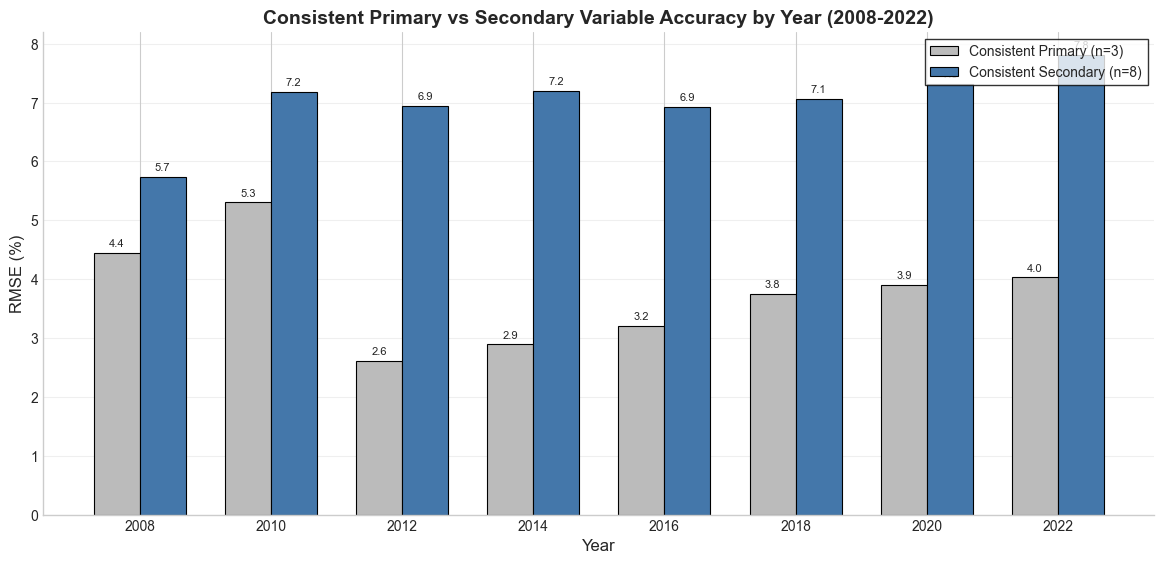

PLOT SAVED: output/primary_vs_secondary_consistent_excl_2006.png

LATEX TABLE SAVED: output/primary_secondary_rmse_by_year.tex

Saved: output/primary_vs_secondary_delta_by_year.png


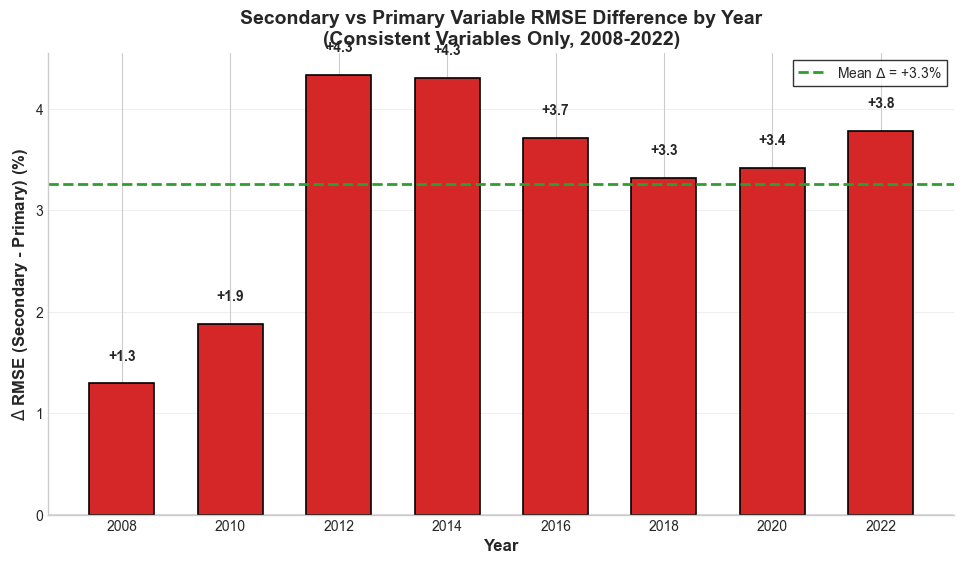

PLOT SAVED: output/primary_vs_secondary_delta_by_year.png

SUMMARY STATISTICS
Primary variables (n=3): ['Age Group', 'Education', 'Sex']
Secondary variables (n=8): ['Employment Status', 'Family Income', 'State Representative', 'State Senator', 'U.S. House', 'Union Membership', 'Veteran Status', 'Voting Method']

Mean RMSE - Primary: 3.77%
Mean RMSE - Secondary: 7.02%
Mean Delta (Secondary - Primary): +3.26%

Delta by year:
  2008: +1.29%
  2010: +1.88%
  2012: +4.34%
  2014: +4.30%
  2016: +3.72%
  2018: +3.32%
  2020: +3.42%
  2022: +3.78%


In [18]:
# =============================================================================
# CONSISTENT PRIMARY VS SECONDARY BY YEAR (EXCLUDING 2006)
# Only includes variables that are consistently Primary/Secondary in 2008-2022
# AND present in every survey year from 2008 onwards
# Excludes 2006 since all variables were Secondary in that year
# =============================================================================

# Get CES-weighted data excluding 2006
df_ces = most_specific[
    (most_specific['Weighting_Method'] == 'CES-Provided Weights') &
    (most_specific['Validity_Scheme'] == 'All') &
    (most_specific['Year'] != 2006)
].copy()

all_years_excl_2006 = set(df_ces['Year'].unique())
years = sorted(all_years_excl_2006)

print(f"Years included: {years}")
print()

# Identify variables that are consistently Primary/Secondary AND present in ALL years (excl 2006)
always_primary = []
always_secondary = []

for var in df_ces['Variable'].unique():
    var_data = df_ces[df_ces['Variable'] == var]
    years_present = set(var_data['Year'].unique())
    
    # Must be present in ALL years (excluding 2006)
    if years_present != all_years_excl_2006:
        continue
    
    # Check Variable_Type per year - must be consistent
    types_by_year = var_data.groupby('Year')['Variable_Type'].first().to_dict()
    unique_types = set(types_by_year.values())
    
    if len(unique_types) == 1:
        if 'Primary' in unique_types:
            always_primary.append(var)
        elif 'Secondary' in unique_types:
            always_secondary.append(var)

print(f"Consistent Primary variables (2008-2022): {sorted(always_primary)}")
print(f"Consistent Secondary variables (2008-2022): {sorted(always_secondary)}")
print()

# =============================================================================

# =============================================================================
# Calculate RMSE for each variable in each year
# =============================================================================

def calc_var_rmse_by_year(df, variables, years):
    """Calculate RMSE for each variable in each year."""
    results = {}
    for var in variables:
        results[var] = {}
        for year in years:
            var_year_data = df[(df['Variable'] == var) & (df['Year'] == year)]
            if len(var_year_data) > 0:
                rmse = np.sqrt(np.mean(var_year_data['Error'] ** 2))
                results[var][year] = rmse
            else:
                results[var][year] = np.nan
    return results

primary_rmse = calc_var_rmse_by_year(df_ces, always_primary, years)
secondary_rmse = calc_var_rmse_by_year(df_ces, always_secondary, years)

# Calculate mean RMSE for primary and secondary in each year
primary_mean_by_year = {}
secondary_mean_by_year = {}
delta_by_year = {}

for year in years:
    primary_vals = [primary_rmse[v][year] for v in always_primary if not np.isnan(primary_rmse[v][year])]
    secondary_vals = [secondary_rmse[v][year] for v in always_secondary if not np.isnan(secondary_rmse[v][year])]
    
    primary_mean_by_year[year] = np.mean(primary_vals) if primary_vals else np.nan
    secondary_mean_by_year[year] = np.mean(secondary_vals) if secondary_vals else np.nan
    
    if not np.isnan(primary_mean_by_year[year]) and not np.isnan(secondary_mean_by_year[year]):
        delta_by_year[year] = secondary_mean_by_year[year] - primary_mean_by_year[year]
    else:
        delta_by_year[year] = np.nan


# PLOT: Primary vs Secondary Bar Chart by Year
# =============================================================================

# Prepare data for plotting
primary_mean_by_year_list = [primary_mean_by_year[y] for y in years]
secondary_mean_by_year_list = [secondary_mean_by_year[y] for y in years]

fig1, ax1 = plt.subplots(figsize=(12, 6))

x = np.arange(len(years))
width = 0.35

bars1 = ax1.bar(x - width/2, primary_mean_by_year_list, width, 
               label=f'Consistent Primary (n={len(always_primary)})', 
               color=VARIABLE_TYPE_COLORS['Primary'], 
               edgecolor='black', linewidth=0.8)
bars2 = ax1.bar(x + width/2, secondary_mean_by_year_list, width,
               label=f'Consistent Secondary (n={len(always_secondary)})',
               color=VARIABLE_TYPE_COLORS['Secondary'],
               edgecolor='black', linewidth=0.8)

ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('RMSE (%)', fontsize=12)
ax1.set_title('Consistent Primary vs Secondary Variable Accuracy by Year (2008-2022)', 
             fontsize=14, fontweight='bold')
ax1.legend(loc='upper right', frameon=True, fancybox=False, edgecolor='black')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.grid(axis='y', linestyle='-', alpha=0.3)
ax1.set_xticks(x)
ax1.set_xticklabels(years)

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        if not np.isnan(height):
            ax1.annotate(f'{height:.1f}', xy=(bar.get_x() + bar.get_width()/2, height),
                        xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=8)

plt.tight_layout()
save_figure(fig1, 'primary_vs_secondary_consistent_excl_2006.png')
plt.show()

print("="*80)
print("PLOT SAVED: output/primary_vs_secondary_consistent_excl_2006.png")
print("="*80)
print()

# =============================================================================
# Build LaTeX table
latex_lines = []
latex_lines.append(r"\begin{table}[!htbp]")
latex_lines.append(r"\centering")
latex_lines.append(r"\footnotesize")
latex_lines.append(r"\caption{Primary vs Secondary Variable RMSE by Year (2008--2022)}")
latex_lines.append(r"\label{tab:primary_secondary_rmse_by_year}")
latex_lines.append(r"\begin{threeparttable}")

# Header
year_cols = " & ".join([str(y) for y in years])
latex_lines.append(r"\begin{tabular}{l" + "c" * len(years) + "c}")
latex_lines.append(r"\toprule")
latex_lines.append(f"Variable & {year_cols} & Mean \\\\")
latex_lines.append(r"\midrule")

# Primary section
latex_lines.append(r"\multicolumn{" + str(len(years) + 2) + r"}{l}{\textit{Primary Variables (used in CES weighting)}} \\")
latex_lines.append(r"\addlinespace[0.2em]")

for var in sorted(always_primary):
    vals = [f"{primary_rmse[var][y]:.1f}" if not np.isnan(primary_rmse[var][y]) else "-" for y in years]
    var_mean = np.mean([v for v in primary_rmse[var].values() if not np.isnan(v)])
    latex_lines.append(f"~~{var} & " + " & ".join(vals) + f" & {var_mean:.1f} \\\\")

# Primary average - fix escaping
latex_lines.append(r"\addlinespace[0.1em]")
primary_vals_str = [f"{primary_mean_by_year[y]:.1f}" if not np.isnan(primary_mean_by_year[y]) else "-" for y in years]
primary_overall_mean = np.mean([v for v in primary_mean_by_year.values() if not np.isnan(v)])
primary_avg_line = r"{\fontseries{sb}\selectfont Primary Avg.} & " + " & ".join(primary_vals_str) + " & {" + r"\fontseries{sb}\selectfont " + f"{primary_overall_mean:.1f}" + "} \\\\"
latex_lines.append(primary_avg_line)

latex_lines.append(r"\addlinespace[0.3em]")

# Secondary section
latex_lines.append(r"\multicolumn{" + str(len(years) + 2) + r"}{l}{\textit{Secondary Variables (not used in CES weighting)}} \\")
latex_lines.append(r"\addlinespace[0.2em]")

for var in sorted(always_secondary):
    vals = [f"{secondary_rmse[var][y]:.1f}" if not np.isnan(secondary_rmse[var][y]) else "-" for y in years]
    var_mean = np.mean([v for v in secondary_rmse[var].values() if not np.isnan(v)])
    latex_lines.append(f"~~{var} & " + " & ".join(vals) + f" & {var_mean:.1f} \\\\")

# Secondary average - fix escaping
latex_lines.append(r"\addlinespace[0.1em]")
secondary_vals_str = [f"{secondary_mean_by_year[y]:.1f}" if not np.isnan(secondary_mean_by_year[y]) else "-" for y in years]
secondary_overall_mean = np.mean([v for v in secondary_mean_by_year.values() if not np.isnan(v)])
secondary_avg_line = r"{\fontseries{sb}\selectfont Secondary Avg.} & " + " & ".join(secondary_vals_str) + " & {" + r"\fontseries{sb}\selectfont " + f"{secondary_overall_mean:.1f}" + "} \\\\"
latex_lines.append(secondary_avg_line)

latex_lines.append(r"\midrule")

# Delta row - fix escaping
delta_vals_str = [f"{delta_by_year[y]:+.1f}" if not np.isnan(delta_by_year[y]) else "-" for y in years]
delta_overall_mean = np.mean([v for v in delta_by_year.values() if not np.isnan(v)])
delta_line = r"\textbf{$\Delta$ (Secondary $-$ Primary)} & " + " & ".join(delta_vals_str) + " & {" + r"\textbf{" + f"{delta_overall_mean:+.1f}" + "}} \\\\"
latex_lines.append(delta_line)

latex_lines.append(r"\bottomrule")
latex_lines.append(r"\end{tabular}")

latex_lines.append(r"\begin{tablenotes}")
latex_lines.append(r"\footnotesize")
latex_lines.append(r"\item \textit{Note:} All values are RMSE in percentage points. Variables must be consistently Primary or Secondary and present in all years 2008--2022.")
latex_lines.append(r"\end{tablenotes}")
latex_lines.append(r"\end{threeparttable}")
latex_lines.append(r"\end{table}")

latex_table = "\n".join(latex_lines)

with open('output/primary_secondary_rmse_by_year.tex', 'w') as f:
    f.write(latex_table)

print("="*80)
print("LATEX TABLE SAVED: output/primary_secondary_rmse_by_year.tex")
print("="*80)
print()

# =============================================================================
# PLOT: Delta (Secondary - Primary) by Year - BAR PLOT
# =============================================================================

fig, ax = plt.subplots(figsize=(10, 6))

# Plot delta as bars
x_positions = np.arange(len(years))
delta_values = [delta_by_year[y] for y in years]

bars = ax.bar(x_positions, delta_values, width=0.6, 
              color='#d62728', edgecolor='black', linewidth=1.2)
ax.axhline(y=0, color='black', linestyle='-', linewidth=1, alpha=0.7)

# Add value labels
for i, (year, delta) in enumerate(zip(years, delta_values)):
    if not np.isnan(delta):
        ax.text(i, delta + (0.2 if delta > 0 else -0.2), 
                f'{delta:+.1f}', ha='center', 
                va='bottom' if delta > 0 else 'top', fontsize=10, fontweight='bold')

ax.set_xlabel('Year', fontsize=12, fontweight='bold')
ax.set_ylabel(r'$\Delta$ RMSE (Secondary - Primary) (%)', fontsize=12, fontweight='bold')
ax.set_title('Secondary vs Primary Variable RMSE Difference by Year\n(Consistent Variables Only, 2008-2022)', 
             fontsize=14, fontweight='bold')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='y', linestyle='-', alpha=0.3)
ax.set_xticks(x_positions)
ax.set_xticklabels(years)

# Add mean line
mean_delta = np.mean([v for v in delta_by_year.values() if not np.isnan(v)])
ax.axhline(y=mean_delta, color='#2ca02c', linestyle='--', linewidth=2, 
           label=r'Mean $\Delta$ = ' + f'{mean_delta:+.1f}%')
ax.legend(loc='upper right', frameon=True, fancybox=False, edgecolor='black')

plt.tight_layout()
save_figure(fig, 'primary_vs_secondary_delta_by_year.png')
plt.show()

print("="*80)
print("PLOT SAVED: output/primary_vs_secondary_delta_by_year.png")
print("="*80)
print()

# Summary statistics
print("="*80)
print("SUMMARY STATISTICS")
print("="*80)
print(f"Primary variables (n={len(always_primary)}): {sorted(always_primary)}")
print(f"Secondary variables (n={len(always_secondary)}): {sorted(always_secondary)}")
print()
print(f"Mean RMSE - Primary: {primary_overall_mean:.2f}%")
print(f"Mean RMSE - Secondary: {secondary_overall_mean:.2f}%")
print(f"Mean Delta (Secondary - Primary): {delta_overall_mean:+.2f}%")
print()
print("Delta by year:")
for year in years:
    print(f"  {year}: {delta_by_year[year]:+.2f}%")


---
# Error Trends Over Time

CONSISTENTLY SECONDARY VARIABLES
N = 8
  - Employment Status (Demographic)
  - Family Income (Demographic)
  - State Representative (Candidate Choice)
  - State Senator (Candidate Choice)
  - U.S. House (Candidate Choice)
  - Union Membership (Demographic)
  - Veteran Status (Demographic)
  - Voting Method (Voting Administration)

VARIABLE-LEVEL RMSE (one obs per variable per year)
N observations: 72
N variables: 8
N years: 9

RMSE BY YEAR AND CLASS (variable-averaged)
Class  Candidate Choice  Demographic  Overall  Voting Administration
Year                                                                
2006               7.66         5.37     6.02                   3.70
2008               6.61         5.44     5.74                   4.34
2010               8.79         6.28     7.18                   5.98
2012               7.86         6.86     6.95                   4.53
2014               9.60         6.35     7.20                   3.37
2016               8.02         6.50     6.

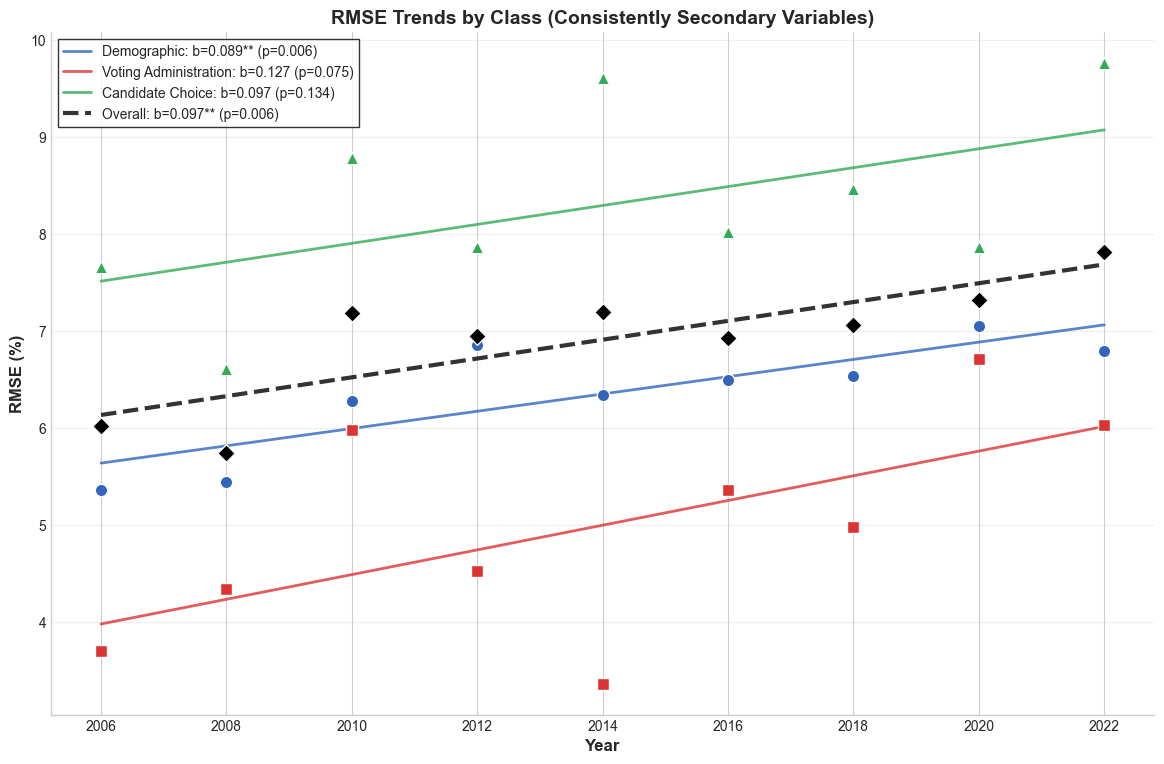


REGRESSION RESULTS: ALL DATA
                Class    Slope       SE  p_value       R2  N_years  N_excluded
          Demographic 0.089012 0.023172 0.006363 0.678255        9           0
Voting Administration 0.127221 0.060795 0.074682 0.384832        9           0
     Candidate Choice 0.097398 0.057471 0.133949 0.290934        9           0
              Overall 0.096933 0.025120 0.006221 0.680226        9           0

EXCLUDED YEARS (2SD within class)
  None excluded
Saved: output/rmse_trends_secondary_exclude_2sd.png


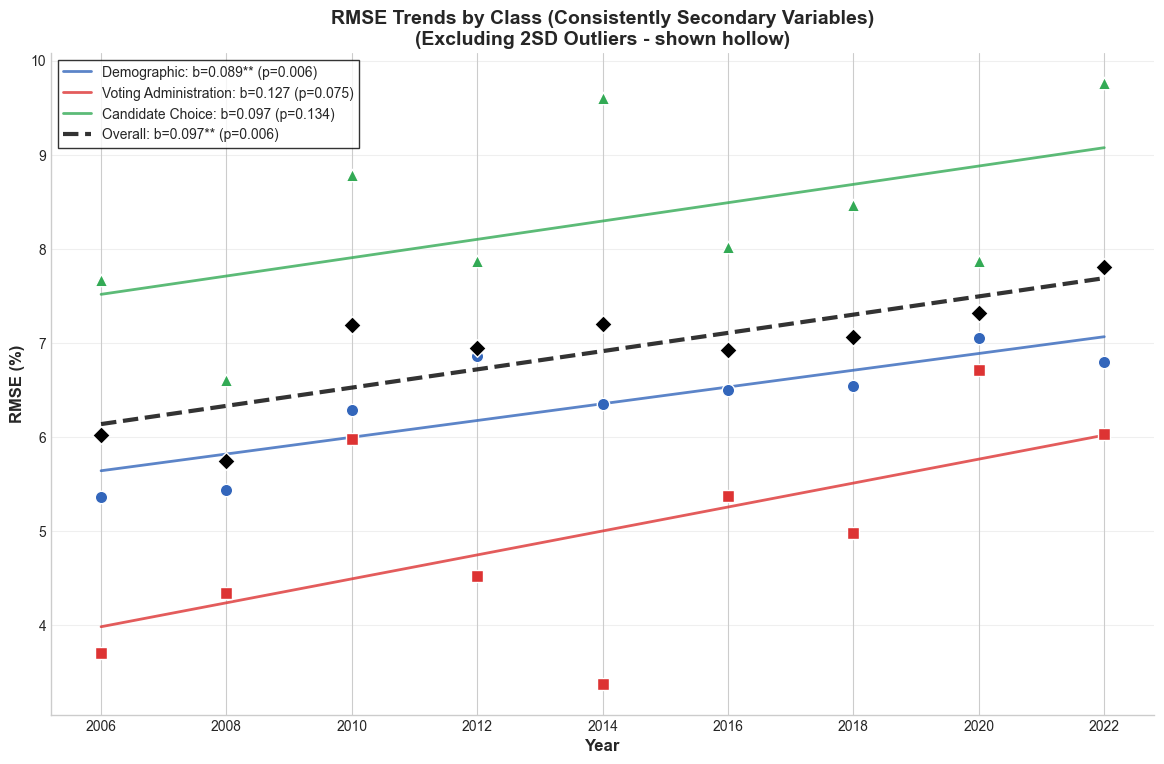


REGRESSION RESULTS: EXCLUDING 2SD OUTLIERS
                Class    Slope       SE  p_value       R2  N_years  N_excluded
          Demographic 0.089012 0.023172 0.006363 0.678255        9           0
Voting Administration 0.127221 0.060795 0.074682 0.384832        9           0
     Candidate Choice 0.097398 0.057471 0.133949 0.290934        9           0
              Overall 0.096933 0.025120 0.006221 0.680226        9           0


In [19]:
# =============================================================================
# RMSE TRENDS OVER TIME: CONSISTENTLY SECONDARY VARIABLES
# =============================================================================
# Consistently secondary = always Secondary AND present in every survey year
# Analysis includes:
#   1. Plot with all data - per-class and overall regressions
#   2. Plot excluding 2SD outlier years (excluded points shown as hollow)
# SD is calculated WITHIN each class separately
#
# METHODOLOGY: 
#   1. Calculate RMSE for each variable in each year (one obs per variable-year)
#   2. For per-class: average variable RMSEs within each class
#   3. For overall: average all variable RMSEs (each variable contributes once)
# =============================================================================

from scipy import stats
import statsmodels.formula.api as smf

# Get CES-weighted data
df_ces = most_specific[
    (most_specific['Weighting_Method'] == 'CES-Provided Weights') &
    (most_specific['Validity_Scheme'] == 'All')
].copy()

all_years = set(df_ces['Year'].unique())
years_sorted = sorted(all_years)

# =============================================================================
# IDENTIFY CONSISTENTLY SECONDARY VARIABLES
# =============================================================================
consistently_secondary = []
for var in df_ces['Variable'].unique():
    var_data = df_ces[df_ces['Variable'] == var]
    years_present = set(var_data['Year'].unique())
    types = var_data['Variable_Type'].unique()
    
    is_always_secondary = len(types) == 1 and types[0] == 'Secondary'
    is_all_years = years_present == all_years
    
    if is_always_secondary and is_all_years:
        consistently_secondary.append(var)

print("="*80)
print("CONSISTENTLY SECONDARY VARIABLES")
print("="*80)
print(f"N = {len(consistently_secondary)}")
for v in sorted(consistently_secondary):
    cls = df_ces[df_ces['Variable'] == v]['Class'].iloc[0]
    print(f"  - {v} ({cls})")

# Filter to consistently secondary variables
df_secondary = df_ces[df_ces['Variable'].isin(consistently_secondary)].copy()

# =============================================================================
# STEP 1: Calculate RMSE for each variable in each year
# =============================================================================
def calc_rmse(errors):
    return np.sqrt(np.mean(errors ** 2))

# One observation per variable-year
rmse_by_var_year = df_secondary.groupby(['Year', 'Variable', 'Class']).apply(
    lambda x: calc_rmse(x['Error']), include_groups=False
).reset_index(name='RMSE')

print("\n" + "="*80)
print("VARIABLE-LEVEL RMSE (one obs per variable per year)")
print("="*80)
print(f"N observations: {len(rmse_by_var_year)}")
print(f"N variables: {rmse_by_var_year['Variable'].nunique()}")
print(f"N years: {rmse_by_var_year['Year'].nunique()}")

# =============================================================================
# STEP 2: Average within class (or overall)
# =============================================================================
# Per class: average variable RMSEs within each class
rmse_by_class_year = rmse_by_var_year.groupby(['Year', 'Class'])['RMSE'].mean().reset_index()

# Overall: average all variable RMSEs (each variable contributes once)
rmse_overall_year = rmse_by_var_year.groupby('Year')['RMSE'].mean().reset_index()
rmse_overall_year['Class'] = 'Overall'

# Combine
rmse_data = pd.concat([rmse_by_class_year, rmse_overall_year], ignore_index=True)

print("\n" + "="*80)
print("RMSE BY YEAR AND CLASS (variable-averaged)")
print("="*80)
pivot = rmse_data.pivot(index='Year', columns='Class', values='RMSE')
print(pivot.round(2).to_string())

# =============================================================================
# HELPER FUNCTION: Identify outlier years (within each class)
# =============================================================================
def identify_outliers_within_class(data, n_sd=2):
    """Identify years that are > n_sd standard deviations from per-class mean.
    SD is calculated WITHIN each class separately."""
    data = data.copy()
    data['is_outlier'] = False
    
    for cls in data['Class'].unique():
        cls_mask = data['Class'] == cls
        cls_data = data.loc[cls_mask, 'RMSE']
        mean_rmse = cls_data.mean()
        std_rmse = cls_data.std()
        
        lower = mean_rmse - n_sd * std_rmse
        upper = mean_rmse + n_sd * std_rmse
        
        outlier_mask = cls_mask & ((data['RMSE'] < lower) | (data['RMSE'] > upper))
        data.loc[outlier_mask, 'is_outlier'] = True
    
    return data

# =============================================================================
# HELPER FUNCTION: Create plot with regressions (showing excluded as hollow)
# =============================================================================
def create_trend_plot_with_outliers(data, title_suffix="", ax=None, show_outliers_hollow=False):
    """Create RMSE trend plot with per-class and overall regressions.
    If show_outliers_hollow=True, excluded points are shown as hollow markers."""
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 8))
    else:
        fig = ax.get_figure()
    
    classes = ['Demographic', 'Voting Administration', 'Candidate Choice', 'Overall']
    colors = {
        'Demographic': '#3366BB',
        'Voting Administration': '#DD3333',
        'Candidate Choice': '#33AA55',
        'Overall': '#000000'
    }
    markers = {'Demographic': 'o', 'Voting Administration': 's', 'Candidate Choice': '^', 'Overall': 'D'}
    
    results = []
    
    for cls in classes:
        cls_data = data[data['Class'] == cls].sort_values('Year')
        if len(cls_data) < 2:
            continue
        
        # Separate included and excluded points
        if show_outliers_hollow and 'is_outlier' in cls_data.columns:
            included = cls_data[~cls_data['is_outlier']]
            excluded = cls_data[cls_data['is_outlier']]
        else:
            included = cls_data
            excluded = pd.DataFrame()
        
        # Plot included points (filled)
        if len(included) > 0:
            ax.scatter(included['Year'].values, included['RMSE'].values, 
                       color=colors[cls], s=80, marker=markers[cls], 
                       zorder=5, edgecolors='white', linewidth=1)
        
        # Plot excluded points (hollow - outline only)
        if len(excluded) > 0:
            ax.scatter(excluded['Year'].values, excluded['RMSE'].values,
                       facecolors='none', edgecolors=colors[cls], s=80, 
                       marker=markers[cls], zorder=5, linewidth=2)
        
        # Use only included points for regression
        if len(included) >= 2:
            x = included['Year'].values
            y = included['RMSE'].values
            
            # Linear regression
            slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
            
            # Significance marker
            if p_value < 0.001:
                sig = '***'
            elif p_value < 0.01:
                sig = '**'
            elif p_value < 0.05:
                sig = '*'
            else:
                sig = ''
            
            # Regression line (extend across all years for visual continuity)
            all_years_cls = cls_data['Year'].values
            x_line = np.array([min(all_years_cls), max(all_years_cls)])
            y_line = slope * x_line + intercept
            linestyle = '-' if cls != 'Overall' else '--'
            linewidth = 2 if cls != 'Overall' else 3
            ax.plot(x_line, y_line, color=colors[cls], linewidth=linewidth, 
                    linestyle=linestyle, alpha=0.8,
                    label=f'{cls}: b={slope:.3f}{sig} (p={p_value:.3f})')
            
            results.append({
                'Class': cls,
                'Slope': slope,
                'SE': std_err,
                'p_value': p_value,
                'R2': r_value**2,
                'N_years': len(included),
                'N_excluded': len(excluded)
            })
    
    ax.set_xlabel('Year', fontsize=12, fontweight='bold')
    ax.set_ylabel('RMSE (%)', fontsize=12, fontweight='bold')
    ax.set_title(f'RMSE Trends by Class (Consistently Secondary Variables){title_suffix}',
                 fontsize=14, fontweight='bold')
    ax.legend(loc='upper left', fontsize=10, frameon=True, fancybox=False, edgecolor='black')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(axis='y', linestyle='-', alpha=0.3)
    ax.set_xticks(sorted(data['Year'].unique()))
    
    return pd.DataFrame(results)

# =============================================================================
# PLOT 1: ALL DATA
# =============================================================================
fig1, ax1 = plt.subplots(figsize=(12, 8))
results_all = create_trend_plot_with_outliers(rmse_data, "", ax1, show_outliers_hollow=False)
plt.tight_layout()
save_figure(fig1, 'rmse_trends_secondary_all_data.png')
plt.show()

print("\n" + "="*80)
print("REGRESSION RESULTS: ALL DATA")
print("="*80)
print(results_all.to_string(index=False))

# =============================================================================
# PLOT 2: EXCLUDING 2SD OUTLIERS (within each class)
# =============================================================================
rmse_2sd = identify_outliers_within_class(rmse_data, n_sd=2)
excluded_2sd = rmse_2sd[rmse_2sd['is_outlier']]

print("\n" + "="*80)
print("EXCLUDED YEARS (2SD within class)")
print("="*80)
if len(excluded_2sd) > 0:
    for _, row in excluded_2sd.iterrows():
        print(f"  {row['Class']}: {int(row['Year'])} (RMSE={row['RMSE']:.2f})")
else:
    print("  None excluded")

fig2, ax2 = plt.subplots(figsize=(12, 8))
results_2sd = create_trend_plot_with_outliers(rmse_2sd, "\n(Excluding 2SD Outliers - shown hollow)", ax2, show_outliers_hollow=True)
plt.tight_layout()
save_figure(fig2, 'rmse_trends_secondary_exclude_2sd.png')
plt.show()

print("\n" + "="*80)
print("REGRESSION RESULTS: EXCLUDING 2SD OUTLIERS")
print("="*80)
print(results_2sd.to_string(index=False))


AGGREGATED DATA: Year x Variable Level
N observations (year x variable): 72
N years: 9
N variables: 8
Center year: 2014.0

FIXED EFFECTS REGRESSION: RMSE ~ Year + Variable FE

Year coefficient (b): 0.0969% RMSE per year
Robust SE (HC3): 0.0437
t-statistic: 2.216
p-value: 0.0267
95% CI: [0.0112, 0.1827]
R-squared (with variable FE): 0.7019

Interpretation: RMSE is increasing by 0.097 percentage points per year

PERMUTATION TEST (10,000 permutations)
Observed b: 0.0969
Permutation distribution: mean=0.0008, SD=0.0417
Permutation p-value (two-sided): 0.0040

SUMMARY: RMSE TREND ANALYSIS
Method                                   b            SE           p-value     
--------------------------------------------------------------------------------
Fixed Effects OLS (HC3 SEs)              0.0969       0.0437       0.0267      
Permutation Test (n=10,000)              0.0969       -            0.0040      
Saved: output/rmse_trend_fe_permutation.png


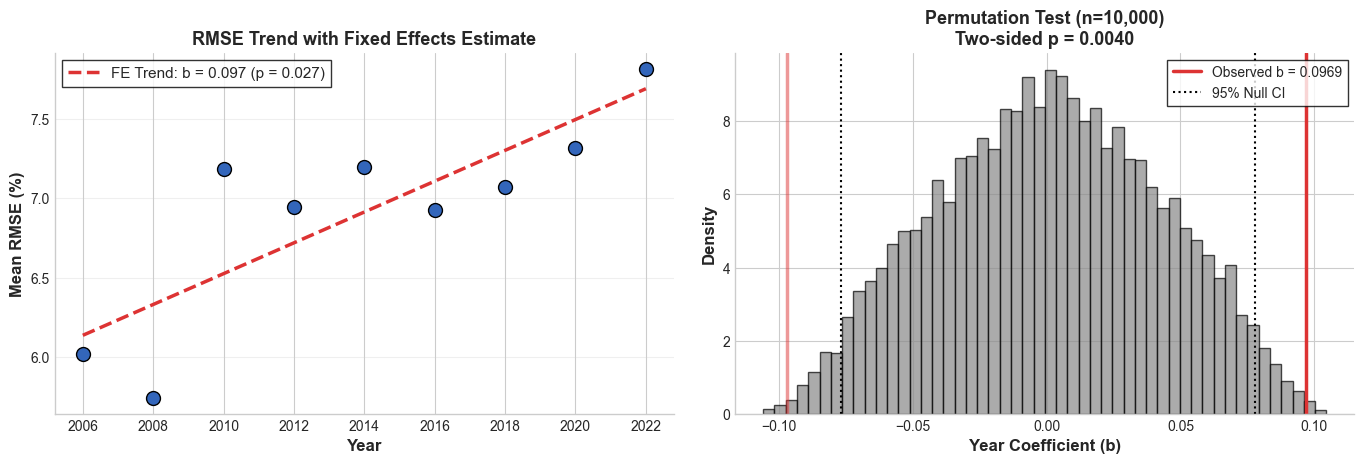

In [20]:
# =============================================================================
# FIXED EFFECTS REGRESSION + PERMUTATION TESTING
# =============================================================================
# Uses the consistently secondary variables identified above
# Fixed effects on Variable controls for baseline differences between variables
# Permutation test provides non-parametric p-value for the year trend
# =============================================================================

import statsmodels.formula.api as smf
from scipy import stats

# =============================================================================
# AGGREGATE TO YEAR x VARIABLE LEVEL
# =============================================================================
agg_data = df_secondary.groupby(['Year', 'Variable', 'Class']).agg(
    RMSE=('Error', lambda x: np.sqrt(np.mean(x ** 2))),
    N=('Error', 'count')
).reset_index()

center_year = agg_data['Year'].median()
agg_data['Year_centered'] = agg_data['Year'] - center_year

print("="*80)
print("AGGREGATED DATA: Year x Variable Level")
print("="*80)
print(f"N observations (year x variable): {len(agg_data)}")
print(f"N years: {agg_data['Year'].nunique()}")
print(f"N variables: {agg_data['Variable'].nunique()}")
print(f"Center year: {center_year}")

# =============================================================================
# FIXED EFFECTS REGRESSION
# =============================================================================
print("\n" + "="*80)
print("FIXED EFFECTS REGRESSION: RMSE ~ Year + Variable FE")
print("="*80)

model = smf.ols("RMSE ~ Year_centered + C(Variable)", data=agg_data)
result_ols = model.fit()
result_hc3 = model.fit(cov_type='HC3')

beta = result_hc3.params['Year_centered']
beta_se = result_hc3.bse['Year_centered']
beta_pval = result_hc3.pvalues['Year_centered']
beta_ci = result_hc3.conf_int().loc['Year_centered']

print(f"\nYear coefficient (b): {beta:.4f}% RMSE per year")
print(f"Robust SE (HC3): {beta_se:.4f}")
print(f"t-statistic: {beta / beta_se:.3f}")
print(f"p-value: {beta_pval:.4f}")
print(f"95% CI: [{beta_ci[0]:.4f}, {beta_ci[1]:.4f}]")
print(f"R-squared (with variable FE): {result_hc3.rsquared:.4f}")

# Interpretation
direction = "increasing" if beta > 0 else "decreasing"
print(f"\nInterpretation: RMSE is {direction} by {abs(beta):.3f} percentage points per year")

# =============================================================================
# PERMUTATION TEST
# =============================================================================
print("\n" + "="*80)
print("PERMUTATION TEST (10,000 permutations)")
print("="*80)

np.random.seed(42)
n_perms = 10000
observed_beta = beta

perm_betas = []
years = agg_data['Year'].unique()

for i in range(n_perms):
    # Permute year labels
    year_mapping = dict(zip(years, np.random.permutation(years)))
    agg_perm = agg_data.copy()
    agg_perm['Year_perm'] = agg_perm['Year'].map(year_mapping)
    agg_perm['Year_centered_perm'] = agg_perm['Year_perm'] - center_year
    
    # Fit model
    model_perm = smf.ols("RMSE ~ Year_centered_perm + C(Variable)", data=agg_perm)
    result_perm = model_perm.fit()
    perm_betas.append(result_perm.params['Year_centered_perm'])

perm_betas = np.array(perm_betas)
perm_pval = np.mean(np.abs(perm_betas) >= np.abs(observed_beta))

print(f"Observed b: {observed_beta:.4f}")
print(f"Permutation distribution: mean={np.mean(perm_betas):.4f}, SD={np.std(perm_betas):.4f}")
print(f"Permutation p-value (two-sided): {perm_pval:.4f}")

# =============================================================================
# SUMMARY TABLE
# =============================================================================
print("\n" + "="*80)
print("SUMMARY: RMSE TREND ANALYSIS")
print("="*80)
print(f"{'Method':<40} {'b':<12} {'SE':<12} {'p-value':<12}")
print("-"*80)
print(f"{'Fixed Effects OLS (HC3 SEs)':<40} {beta:<12.4f} {beta_se:<12.4f} {beta_pval:<12.4f}")
print(f"{'Permutation Test (n=10,000)':<40} {observed_beta:<12.4f} {'-':<12} {perm_pval:<12.4f}")

# =============================================================================
# VISUALIZATION: Permutation Distribution
# =============================================================================
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left panel: Trend plot with FE estimate
ax1 = axes[0]
yearly_rmse = agg_data.groupby('Year')['RMSE'].mean()
x_years = yearly_rmse.index.values
y_rmse = yearly_rmse.values

ax1.scatter(x_years, y_rmse, s=100, color='#3366BB', edgecolors='black', linewidth=1, zorder=5)

# Add FE regression line (using overall mean as baseline)
mean_rmse = agg_data['RMSE'].mean()
x_line = np.array([min(x_years), max(x_years)])
y_line = mean_rmse + beta * (x_line - center_year)
ax1.plot(x_line, y_line, color='#DD3333', linewidth=2.5, linestyle='--',
         label=f'FE Trend: b = {beta:.3f} (p = {beta_pval:.3f})')

ax1.set_xlabel('Year', fontsize=12, fontweight='bold')
ax1.set_ylabel('Mean RMSE (%)', fontsize=12, fontweight='bold')
ax1.set_title('RMSE Trend with Fixed Effects Estimate', fontsize=13, fontweight='bold')
ax1.legend(loc='upper left', fontsize=11, frameon=True, fancybox=False, edgecolor='black')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.grid(axis='y', linestyle='-', alpha=0.3)
ax1.set_xticks(x_years)

# Right panel: Permutation distribution
ax2 = axes[1]
ax2.hist(perm_betas, bins=50, color='#888888', edgecolor='black', alpha=0.7, density=True)
ax2.axvline(observed_beta, color='#DD3333', linewidth=2.5, linestyle='-', 
            label=f'Observed b = {observed_beta:.4f}')
ax2.axvline(-observed_beta, color='#DD3333', linewidth=2.5, linestyle='-', alpha=0.5)
ax2.axvline(np.percentile(perm_betas, 2.5), color='black', linewidth=1.5, linestyle=':', 
            label='95% Null CI')
ax2.axvline(np.percentile(perm_betas, 97.5), color='black', linewidth=1.5, linestyle=':')

ax2.set_xlabel('Year Coefficient (b)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Density', fontsize=12, fontweight='bold')
ax2.set_title(f'Permutation Test (n=10,000)\nTwo-sided p = {perm_pval:.4f}', 
              fontsize=13, fontweight='bold')
ax2.legend(loc='upper right', fontsize=10, frameon=True, fancybox=False, edgecolor='black')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

plt.tight_layout()
save_figure(fig, 'rmse_trend_fe_permutation.png')
plt.show()


In [21]:
# =============================================================================
# LATEX TABLE: Summary of Trend Statistical Tests
# =============================================================================
# Collects results from:
#   - Cell 18: results_all (per-class and overall simple OLS)
#   - Cell 19: beta, beta_se, beta_pval, perm_pval (Variable FE)
# =============================================================================

print("="*80)
print("GENERATING LATEX TABLE FOR PAPER")
print("="*80)

latex_lines = []
latex_lines.append(r"\begin{table}[!htbp]")
latex_lines.append(r"\centering")
latex_lines.append(r"\caption{RMSE Trend Analysis: Statistical Tests}")
latex_lines.append(r"\label{tab:rmse_trend_tests}")
latex_lines.append(r"\begin{threeparttable}")
latex_lines.append(r"\begin{tabular}{lcccc}")
latex_lines.append(r"\toprule")
latex_lines.append(r"Model & $\beta$ & SE & $p$-value & Perm. $p$ \\")
latex_lines.append(r"\midrule")

# Panel A: Simple OLS by Class
latex_lines.append(r"\multicolumn{5}{l}{\textit{Panel A: Simple OLS by Class}} \\")
latex_lines.append(r"\addlinespace[0.2em]")

for _, row in results_all.iterrows():
    cls = row['Class']
    slope = row['Slope']
    se = row['SE']
    pval = row['p_value']
    
    # Significance stars
    if pval < 0.001:
        sig = '***'
    elif pval < 0.01:
        sig = '**'
    elif pval < 0.05:
        sig = '*'
    else:
        sig = ''
    
    pval_str = f"{pval:.3f}" if pval >= 0.001 else "<0.001"
    latex_lines.append(f"~~{cls} & {slope:.4f}{sig} & {se:.4f} & {pval_str} & -- \\\\")

latex_lines.append(r"\addlinespace[0.3em]")

# Panel B: Fixed Effects Model
latex_lines.append(r"\multicolumn{5}{l}{\textit{Panel B: Fixed Effects Model}} \\")
latex_lines.append(r"\addlinespace[0.2em]")

# Variable FE
if beta_pval < 0.001:
    sig_v = '***'
elif beta_pval < 0.01:
    sig_v = '**'
elif beta_pval < 0.05:
    sig_v = '*'
else:
    sig_v = ''
pval_v_str = f"{beta_pval:.3f}" if beta_pval >= 0.001 else "<0.001"
perm_v_str = f"{perm_pval:.3f}" if perm_pval >= 0.001 else "<0.001"
latex_lines.append(f"~~Variable FE & {beta:.4f}{sig_v} & {beta_se:.4f} & {pval_v_str} & {perm_v_str} \\\\")

latex_lines.append(r"\bottomrule")
latex_lines.append(r"\end{tabular}")
latex_lines.append(r"\begin{tablenotes}")
latex_lines.append(r"\footnotesize")
latex_lines.append(r"\item \textit{Note:} $\beta$ represents the change in RMSE (percentage points) per year.")
latex_lines.append(r"\item Panel A reports simple OLS regressions of RMSE on year, separately by class and overall.")
latex_lines.append(r"\item Panel B reports OLS with variable fixed effects (controls for 8 variables).")
latex_lines.append(r"\item Robust standard errors (HC3) used for all models. Permutation $p$-value based on 10,000 permutations.")
latex_lines.append(r"\item * $p<0.05$, ** $p<0.01$, *** $p<0.001$")
latex_lines.append(r"\end{tablenotes}")
latex_lines.append(r"\end{threeparttable}")
latex_lines.append(r"\end{table}")

latex_str = "\n".join(latex_lines)

# Save to file
with open('output/rmse_trend_tests.tex', 'w') as f:
    f.write(latex_str)

print("Saved: output/rmse_trend_tests.tex")


GENERATING LATEX TABLE FOR PAPER
Saved: output/rmse_trend_tests.tex


UNWEIGHTED ANALYSIS - Secondary Variables Present in All Years
Variables: ['State Representative', 'State Senator', 'U.S. House', 'Employment Status', 'Family Income', 'Union Membership', 'Veteran Status', 'Voting Method']
N observations (year × variable): 72

PRIMARY MODEL (HC3 Robust SEs) - UNWEIGHTED
Year slope (β): 0.1498% RMSE per year
Robust SE: 0.0577
p-value: 0.0094
95% CI: [0.0368, 0.2629]

Permutation p-value: 0.0125
Saved: output/rmse_trend_primary_analysis_unweighted.png


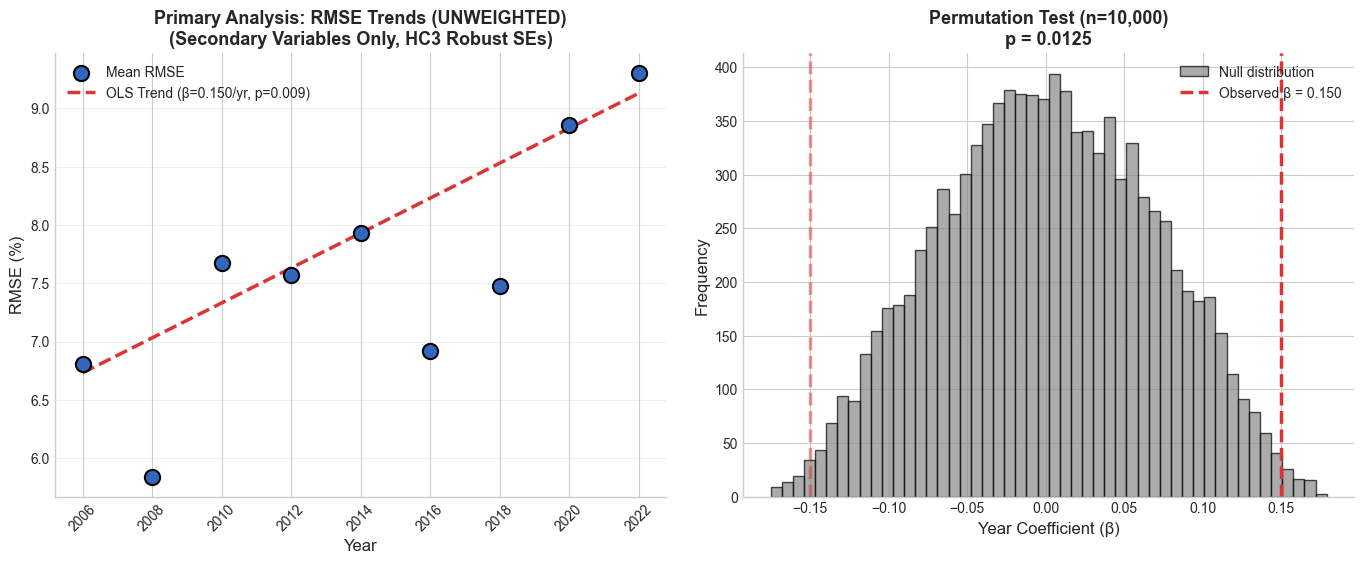


Saved: output/rmse_trend_primary_analysis_unweighted.png


In [22]:
# =============================================================================
# PRIMARY ANALYSIS: RMSE TRENDS OVER TIME (UNWEIGHTED)
# =============================================================================
# Same analysis as weighted, but using CES-Unweighted (matching only)
# =============================================================================

# Filter for UNWEIGHTED, All validity scheme
df_unweighted = most_specific[
    (most_specific['Weighting_Method'] == 'CES-Unweighted') &
    (most_specific['Validity_Scheme'] == 'All')
].copy()

all_years_uw = set(df_unweighted['Year'].unique())

# Identify always-secondary variables present in all years
always_secondary_uw = []
for var in df_unweighted['Variable'].unique():
    var_data = df_unweighted[df_unweighted['Variable'] == var]
    years_present = set(var_data['Year'].unique())
    types = var_data['Variable_Type'].unique()
    
    is_always_secondary = len(types) == 1 and types[0] == 'Secondary'
    is_all_years = years_present == all_years_uw
    
    if is_always_secondary and is_all_years:
        always_secondary_uw.append(var)

print("="*80)
print("UNWEIGHTED ANALYSIS - Secondary Variables Present in All Years")
print("="*80)
print(f"Variables: {always_secondary_uw}")

df_secondary_uw = df_unweighted[df_unweighted['Variable'].isin(always_secondary_uw)].copy()

# Aggregate
agg_data_uw = df_secondary_uw.groupby(['Year', 'Variable', 'Class']).agg(
    RMSE=('Error', lambda x: np.sqrt(np.mean(x ** 2))),
    N=('Error', 'count')
).reset_index()

center_year_uw = agg_data_uw['Year'].median()
agg_data_uw['Year_centered'] = agg_data_uw['Year'] - center_year_uw

print(f"N observations (year × variable): {len(agg_data_uw)}")

# Primary model
model_uw = smf.ols("RMSE ~ Year_centered + C(Variable)", data=agg_data_uw)
result_hc3_uw = model_uw.fit(cov_type='HC3')

beta_uw = result_hc3_uw.params['Year_centered']
beta_se_uw = result_hc3_uw.bse['Year_centered']
beta_pval_uw = result_hc3_uw.pvalues['Year_centered']
beta_ci_uw = result_hc3_uw.conf_int().loc['Year_centered']

print()
print("="*80)
print("PRIMARY MODEL (HC3 Robust SEs) - UNWEIGHTED")
print("="*80)
print(f"Year slope (β): {beta_uw:.4f}% RMSE per year")
print(f"Robust SE: {beta_se_uw:.4f}")
print(f"p-value: {beta_pval_uw:.4f}")
print(f"95% CI: [{beta_ci_uw[0]:.4f}, {beta_ci_uw[1]:.4f}]")

# Permutation test
np.random.seed(42)
n_perms = 10000
perm_betas_uw = []
years_uw = agg_data_uw['Year'].unique()

for _ in range(n_perms):
    year_mapping = dict(zip(years_uw, np.random.permutation(years_uw)))
    agg_perm = agg_data_uw.copy()
    agg_perm['Year_perm'] = agg_perm['Year'].map(year_mapping)
    agg_perm['Year_centered_perm'] = agg_perm['Year_perm'] - center_year_uw
    
    model_perm = smf.ols("RMSE ~ Year_centered_perm + C(Variable)", data=agg_perm)
    result_perm = model_perm.fit()
    perm_betas_uw.append(result_perm.params['Year_centered_perm'])

perm_betas_uw = np.array(perm_betas_uw)
perm_pval_uw = np.mean(np.abs(perm_betas_uw) >= np.abs(beta_uw))

print()
print(f"Permutation p-value: {perm_pval_uw:.4f}")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

ax1 = axes[0]
years_list_uw = sorted(agg_data_uw['Year'].unique())
year_rmse_uw = agg_data_uw.groupby('Year')['RMSE'].mean()

ax1.scatter(years_list_uw, [year_rmse_uw[y] for y in years_list_uw], s=120, color='#3366BB', 
            edgecolor='black', linewidth=1.5, zorder=5, label='Mean RMSE')

year_range_uw = np.array([min(years_list_uw), max(years_list_uw)])
year_range_centered_uw = year_range_uw - center_year_uw
# Use actual mean RMSE at center year as baseline
baseline_uw = year_rmse_uw[center_year_uw]
trend_line_uw = baseline_uw + beta_uw * year_range_centered_uw
ax1.plot(year_range_uw, trend_line_uw, '--', color='#DD3333', linewidth=2.5, 
         label=f'OLS Trend (β={beta_uw:.3f}/yr, p={beta_pval_uw:.3f})')

ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('RMSE (%)', fontsize=12)
ax1.set_title('Primary Analysis: RMSE Trends (UNWEIGHTED)\n(Secondary Variables Only, HC3 Robust SEs)', fontsize=13, fontweight='bold')
ax1.legend(loc='best', fontsize=10)
ax1.set_xticks(years_list_uw)
ax1.set_xticklabels([str(y) for y in years_list_uw], rotation=45)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.grid(axis='y', linestyle='-', alpha=0.3)

ax2 = axes[1]
ax2.hist(perm_betas_uw, bins=50, color='#888888', edgecolor='black', alpha=0.7, label='Null distribution')
ax2.axvline(beta_uw, color='#DD3333', linewidth=2.5, linestyle='--', label=f'Observed β = {beta_uw:.3f}')
ax2.axvline(-beta_uw, color='#DD3333', linewidth=2.5, linestyle='--', alpha=0.5)

ax2.set_xlabel('Year Coefficient (β)', fontsize=12)
ax2.set_ylabel('Frequency', fontsize=12)
ax2.set_title(f'Permutation Test (n=10,000)\np = {perm_pval_uw:.4f}', fontsize=13, fontweight='bold')
ax2.legend(loc='upper right', fontsize=10)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

plt.tight_layout()
save_figure(fig, 'rmse_trend_primary_analysis_unweighted.png')
plt.show()

print("\nSaved: output/rmse_trend_primary_analysis_unweighted.png")

---
# Weighting Method Comparison: Error Reduction

---
# ANESRake Full vs Restricted Comparison

---
# Candidate vs Party Specificity

---
# RMSE by Office and Year Heatmap

---
# RMSE Excluding Voter Registration and Turnout

In [23]:
# ============================================================
# FIGURE 1A REPLICA: RMSE by Variable and Year
# (EXCLUDING VOTER REGISTRATION AND VOTING TURNOUT)
# ============================================================

print("="*100)
print("FIGURE 1A REPLICA (EXCLUDING VOTER REGISTRATION AND VOTING TURNOUT)")
print("="*100)

# Filter for Matching + Post-Stratification, All validity, EXCLUDING the two high-error variables
df_excl = most_specific[
    (most_specific['Weighting_Method'] == 'CES-Provided Weights') &
    (most_specific['Validity_Scheme'] == 'All') &
    (~most_specific['Variable'].isin(['Voter Registration', 'Voting Turnout']))
].copy()

print(f"\nTotal observations: {len(df_excl):,}")
print(f"Variables excluded: Voter Registration, Voting Turnout\n")

# Calculate RMSE by Year and Variable
rmse_by_var_year_excl = df_excl.groupby(['Year', 'Variable', 'Variable_Type', 'Class']).apply(lambda x: np.sqrt(np.mean(x['Error'] ** 2))).reset_index(name='RMSE')

# Create pivot tables
rmse_pivot_excl = rmse_by_var_year_excl.pivot_table(
    index='Variable',
    columns='Year',
    values='RMSE'
)

# Variable type for each cell
type_pivot_excl = rmse_by_var_year_excl.pivot_table(
    index='Variable',
    columns='Year',
    values='Variable_Type',
    aggfunc='first'
)

class_map_excl = rmse_by_var_year_excl.groupby('Variable')['Class'].first().to_dict()

rmse_pivot_excl = sort_variables(rmse_pivot_excl.reset_index()).set_index('Variable')
type_pivot_excl = sort_variables(type_pivot_excl.reset_index()).set_index('Variable')

years_excl = sorted([c for c in rmse_pivot_excl.columns if isinstance(c, (int, float))])

rmse_pivot_excl['Average'] = rmse_pivot_excl[years_excl].mean(axis=1)

avg_row_excl = rmse_pivot_excl.mean(axis=0)
avg_row_excl.name = 'Average'
rmse_pivot_with_avg_excl = pd.concat([rmse_pivot_excl, avg_row_excl.to_frame().T])

# Calculate class subtotals
class_values_excl = {cls: {year: [] for year in years_excl} for cls in class_order}
for var in rmse_pivot_excl.index:
    var_class = class_map_excl.get(var, 'Unknown')
    if var_class not in class_order:
        continue
    for year in years_excl:
        val = rmse_pivot_excl.loc[var, year]
        if not pd.isna(val):
            class_values_excl[var_class][year].append(val)

class_subtotals_excl = {}
for cls in class_order:
    class_subtotals_excl[cls] = {}
    for year in years_excl:
        vals = class_values_excl[cls][year]
        class_subtotals_excl[cls][year] = np.mean(vals) if vals else float('nan')
    year_avgs = [class_subtotals_excl[cls][y] for y in years_excl if not pd.isna(class_subtotals_excl[cls][y])]
    class_subtotals_excl[cls]['row_avg'] = np.mean(year_avgs) if year_avgs else float('nan')

# Print formatted table
print("\n")
header = "{:<25}".format("Variable")
for year in years_excl:
    header += " {:>6}".format(str(int(year)))
header += " {:>12}".format("Yearly Mean")
print(header)
print("-" * len(header))

for cls in class_order:
    print(f"\n{cls}")
    
    for var in rmse_pivot_excl.index:
        var_class = class_map_excl.get(var, 'Unknown')
        if var_class != cls:
            continue
        
        row = "  {:<23}".format(var)
        for year in years_excl:
            val = rmse_pivot_excl.loc[var, year]
            if pd.isna(val):
                row += " {:>6}".format("-")
            else:
                var_type = type_pivot_excl.loc[var, year] if var in type_pivot_excl.index and year in type_pivot_excl.columns else None
                if var_type == 'Primary':
                    row += " {:>5}†".format(f"{val:.1f}")
                else:
                    row += " {:>6}".format(f"{val:.1f}")
        row_avg = rmse_pivot_with_avg_excl.loc[var, 'Average']
        if pd.isna(row_avg):
            row += " {:>12}".format("-")
        else:
            row += " {:>12}".format(f"{row_avg:.1f}")
        print(row)
    
    # Class average
    row = "  {:<23}".format(f"{cls} Avg.")
    for year in years_excl:
        val = class_subtotals_excl[cls][year]
        if pd.isna(val):
            row += " {:>6}".format("-")
        else:
            row += " {:>6}".format(f"{val:.1f}")
    row_avg = class_subtotals_excl[cls]['row_avg']
    if pd.isna(row_avg):
        row += " {:>12}".format("-")
    else:
        row += " {:>12}".format(f"{row_avg:.1f}")
    print(row)

# Yearly RMSE row
print("-" * len(header))
row = "{:<25}".format("Yearly RMSE")
yearly_rmse_values_excl = []
for year in years_excl:
    val = rmse_pivot_with_avg_excl.loc['Average', year]
    if pd.isna(val):
        row += " {:>6}".format("-")
    else:
        row += " {:>6}".format(f"{val:.1f}")
        yearly_rmse_values_excl.append(val)
annual_avg_excl = np.mean(yearly_rmse_values_excl) if yearly_rmse_values_excl else float('nan')
if pd.isna(annual_avg_excl):
    row += " {:>12}".format("-")
else:
    row += " {:>12}".format(f"{annual_avg_excl:.1f}")
print(row)

print("\n† indicates Primary variables (used in CES post-stratification weighting for that year)")

# Summary comparison
print("\n" + "="*80)
print("COMPARISON TO FIGURE 1 TABLE A (using mean-of-means approach)")
print("="*80)

# Calculate Figure 1 Table A approach for all variables
df_all = most_specific[
    (most_specific['Weighting_Method'] == 'CES-Provided Weights') &
    (most_specific['Validity_Scheme'] == 'All')
]
rmse_by_var_year_all = df_all.groupby(['Year', 'Variable']).apply(lambda x: np.sqrt(np.mean(x['Error'] ** 2))).reset_index(name='RMSE')
rmse_pivot_all = rmse_by_var_year_all.pivot_table(index='Variable', columns='Year', values='RMSE')
years_all = sorted([c for c in rmse_pivot_all.columns if isinstance(c, (int, float))])
avg_row_all = rmse_pivot_all.mean(axis=0)
annual_avg_all = np.mean([avg_row_all[y] for y in years_all])

print(f"\nWith all variables (Figure 1 Table A bottom-right):")
print(f"  Overall RMSE: {annual_avg_all:.1f}%")

print(f"\nExcluding Voter Registration & Voting Turnout:")
print(f"  Overall RMSE: {annual_avg_excl:.1f}%")

print(f"\nReduction: {annual_avg_all - annual_avg_excl:.1f} percentage points")
print(f"({((annual_avg_all - annual_avg_excl) / annual_avg_all * 100):.0f}% lower error)")

FIGURE 1A REPLICA (EXCLUDING VOTER REGISTRATION AND VOTING TURNOUT)

Total observations: 9,065
Variables excluded: Voter Registration, Voting Turnout



Variable                    2006   2008   2010   2012   2014   2016   2018   2020   2022  Yearly Mean
-----------------------------------------------------------------------------------------------------

Demographic
  Age Group                  6.9   3.3†   4.8†   2.8†   2.8†   2.6†   4.0†   4.7†   5.2†          4.1
  Sex                        5.2   6.8†   5.0†   1.5†   2.0†   1.3†   2.9†   2.5†   3.1†          3.4
  Hispanic Origin              -      -    7.6    8.1    7.5    7.6    7.8    7.0    2.7          6.9
  Education                 13.0   3.3†   6.1†   3.5†   3.9†   5.7†   4.4†   4.5†   3.8†          5.3
  Family Income              4.5    3.5    3.9    3.9    4.4    4.9    5.3    6.8    8.8          5.1
  Employment Status          7.0   10.3   10.6   13.5   11.5   12.0   12.2   12.4   10.1         11.1
  Union Membership

/var/folders/xf/837xl0rs49194z6g15hkf22m0000gn/T/ipykernel_39252/2435435934.py:21: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  rmse_by_var_year_excl = df_excl.groupby(['Year', 'Variable', 'Variable_Type', 'Class']).apply(lambda x: np.sqrt(np.mean(x['Error'] ** 2))).reset_index(name='RMSE')
/var/folders/xf/837xl0rs49194z6g15hkf22m0000gn/T/ipykernel_39252/2435435934.py:151: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.

---
# Summary: Generated Files

In [24]:
import os

print("="*80)
print("GENERATED FILES SUMMARY")
print("="*80)

output_files = sorted(os.listdir('output'))
print(f"\nTotal files in output/: {len(output_files)}")
print("\nFiles:")
for f in output_files:
    size = os.path.getsize(f'output/{f}')
    print(f"  - {f} ({size:,} bytes)")

GENERATED FILES SUMMARY

Total files in output/: 41

Files:
  - .DS_Store (6,148 bytes)
  - anesrake_full_vs_restricted.png (131,350 bytes)
  - anesrake_full_vs_restricted_comparison.png (145,877 bytes)
  - anesrake_variables_accuracy.tex (4,658 bytes)
  - ces_comparison.tex (2,994 bytes)
  - error_distribution_by_class_sidebyside.png (205,879 bytes)
  - error_reduction_ces_weights_by_type.png (132,840 bytes)
  - observation_counts.tex (2,701 bytes)
  - primary_secondary_rmse_by_year.tex (2,017 bytes)
  - primary_vs_secondary_consistent_excl_2006.png (150,194 bytes)
  - primary_vs_secondary_delta_by_year.png (143,892 bytes)
  - respondent_counts_by_state.xlsx (8,309 bytes)
  - rmse_anesrake_full_by_year.png (137,744 bytes)
  - rmse_anesrake_full_table.tex (2,132 bytes)
  - rmse_anesrake_restricted_by_year.png (129,575 bytes)
  - rmse_anesrake_restricted_table.tex (2,933 bytes)
  - rmse_by_competitiveness_histogram.png (184,794 bytes)
  - rmse_by_office_salience.png (278,071 bytes)
  - 

---
# Congressional District Size and U.S. House Accuracy

Analysis of how the number of CES respondents per congressional district affects U.S. House vote accuracy.

Total unique districts: 2707

Districts by bucket: {'0-50': np.int64(247), '50-100': np.int64(1622), '100-200': np.int64(835), '200-400': np.int64(3), '400-800': np.int64(0), '800+': np.int64(0)}

Average Absolute Error by bucket:
  0-50: 10.8% (n=247)
  50-100: 7.6% (n=1622)
  100-200: 5.9% (n=835)
  200-400: 3.9% (n=3)
Saved: output/us_house_error_by_cd_size.png


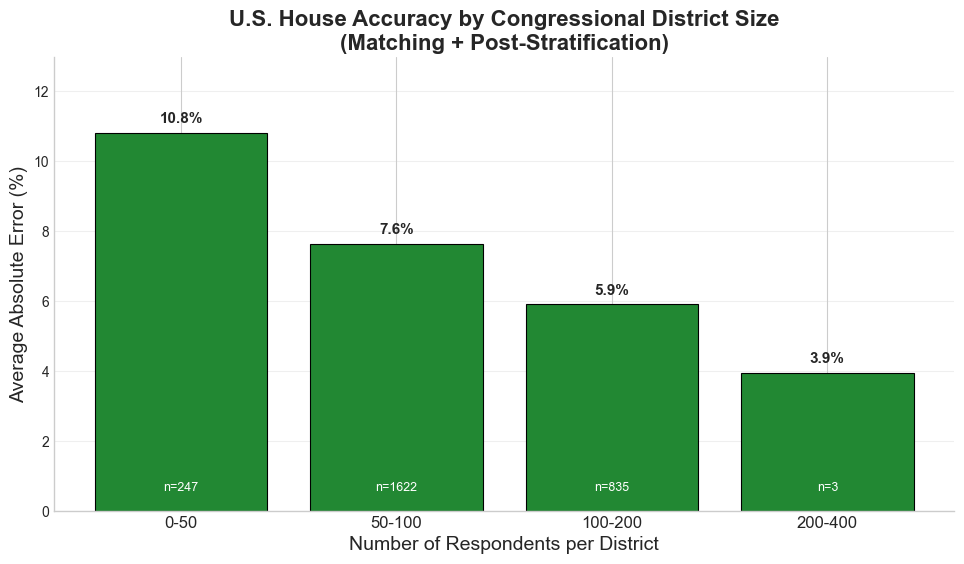

Saved: output/us_house_cd_size_distribution.png


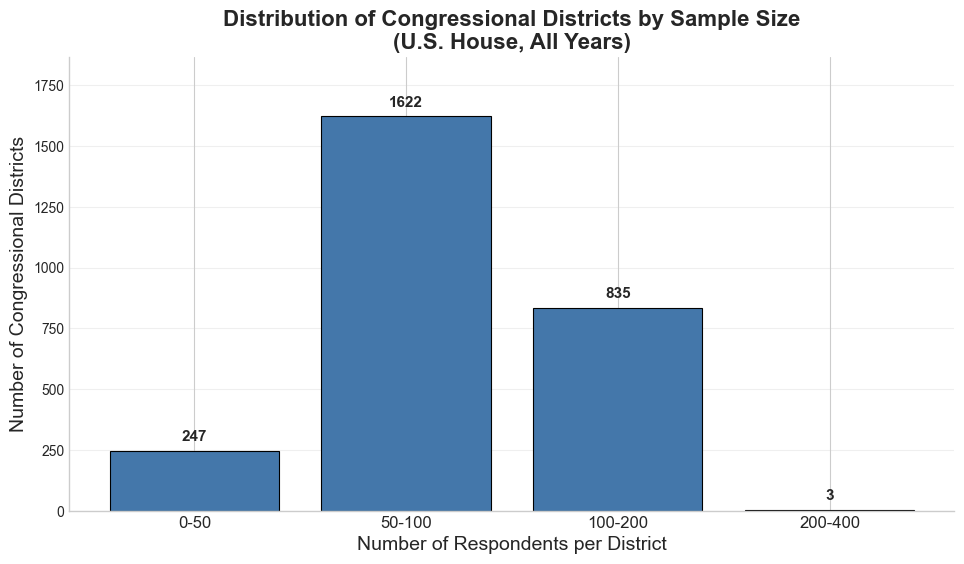


RMSE COMPARISON: ALL DISTRICTS vs LARGE DISTRICTS

Year     All Districts      >100 respondents  
---------------------------------------------
2006            4.9%               4.3%
2008            6.1%               6.0%
2010           11.4%               8.7%
2012            9.8%               8.0%
2014            9.0%               7.5%
2016            9.6%               8.0%
2018            9.5%               6.1%
2020            8.0%               7.0%
2022           10.1%               8.1%
---------------------------------------------
Average         8.7%               7.1%

Districts: 2707 total, 809 with >100 respondents (29.9%)

Sentence: "If we had only measured error in CDs with >100 respondents,
the annual average RMSE for U.S. House would have gone from 8.7% to 7.1%."


In [25]:
# =============================================================================
# CONGRESSIONAL DISTRICT SIZE AND U.S. HOUSE ACCURACY
# =============================================================================

# Filter for U.S. House, Matching + Post-Strat., Validity_Scheme='All'
df_house = metrics_base_full[
    (metrics_base_full['Variable'] == 'U.S. House') &
    (metrics_base_full['Weighting_Method'] == 'CES-Provided Weights') &
    (metrics_base_full['Validity_Scheme'] == 'All')
].copy()

# Create absolute error
df_house['Abs_Error'] = df_house['Error'].abs()

# Define buckets
def get_bucket(n):
    if n < 50:
        return '0-50'
    elif n < 100:
        return '50-100'
    elif n < 200:
        return '100-200'
    elif n < 400:
        return '200-400'
    elif n < 800:
        return '400-800'
    else:
        return '800+'

df_house['Respondent_Bucket'] = df_house['n_respondents'].apply(get_bucket)
bucket_order = ['0-50', '50-100', '100-200', '200-400', '400-800', '800+']

# Get unique district-level data
districts_df = df_house.groupby(['Year', 'State', 'District']).agg({
    'n_respondents': 'first',
    'Abs_Error': 'mean'
}).reset_index()
districts_df['Respondent_Bucket'] = districts_df['n_respondents'].apply(get_bucket)

# Calculate stats by bucket
district_counts = districts_df['Respondent_Bucket'].value_counts().reindex(bucket_order, fill_value=0)
avg_error_by_bucket = districts_df.groupby('Respondent_Bucket')['Abs_Error'].mean().reindex(bucket_order)

print(f"Total unique districts: {len(districts_df)}")
print(f"\nDistricts by bucket: {dict(district_counts)}")
print(f"\nAverage Absolute Error by bucket:")
for b in bucket_order:
    if district_counts[b] > 0:
        print(f"  {b}: {avg_error_by_bucket[b]:.1f}% (n={district_counts[b]})")

# ============================================================
# PLOT 1: Average Absolute Error by Respondent Bucket
# ============================================================
fig1, ax1 = plt.subplots(figsize=(10, 6))

valid_buckets = [b for b in bucket_order if district_counts[b] > 0]
x_pos = np.arange(len(valid_buckets))
values = [avg_error_by_bucket[b] for b in valid_buckets]
counts = [district_counts[b] for b in valid_buckets]

bars = ax1.bar(x_pos, values, color=CLASS_COLORS['Candidate Choice'], edgecolor='black', linewidth=0.8)

for i, (bar, val, n) in enumerate(zip(bars, values, counts)):
    ax1.annotate(f'{val:.1f}%', xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                xytext=(0, 5), textcoords="offset points", ha='center', va='bottom', fontsize=11, fontweight='bold')
    ax1.annotate(f'n={n}', xy=(bar.get_x() + bar.get_width()/2, 0.5),
                ha='center', va='bottom', fontsize=9, color='white')

ax1.set_xlabel('Number of Respondents per District', fontsize=14)
ax1.set_ylabel('Average Absolute Error (%)', fontsize=14)
ax1.set_title('U.S. House Accuracy by Congressional District Size\n(Matching + Post-Stratification)', fontsize=16, fontweight='bold')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(valid_buckets, fontsize=12)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_ylim(0, max(values) * 1.2)
ax1.grid(axis='y', linestyle='-', alpha=0.3)

save_figure(fig1, 'us_house_error_by_cd_size.png')
plt.show()

# ============================================================
# PLOT 2: Distribution of Districts by Respondent Bucket
# ============================================================
fig2, ax2 = plt.subplots(figsize=(10, 6))

bars2 = ax2.bar(x_pos, counts, color=CLASS_COLORS['Demographic'], edgecolor='black', linewidth=0.8)

for bar, n in zip(bars2, counts):
    ax2.annotate(f'{n}', xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                xytext=(0, 5), textcoords="offset points", ha='center', va='bottom', fontsize=11, fontweight='bold')

ax2.set_xlabel('Number of Respondents per District', fontsize=14)
ax2.set_ylabel('Number of Congressional Districts', fontsize=14)
ax2.set_title('Distribution of Congressional Districts by Sample Size\n(U.S. House, All Years)', fontsize=16, fontweight='bold')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(valid_buckets, fontsize=12)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.set_ylim(0, max(counts) * 1.15)
ax2.grid(axis='y', linestyle='-', alpha=0.3)

save_figure(fig2, 'us_house_cd_size_distribution.png')
plt.show()

# ============================================================
# RMSE Comparison: All Districts vs Large Districts
# ============================================================
print("\n" + "="*70)
print("RMSE COMPARISON: ALL DISTRICTS vs LARGE DISTRICTS")
print("="*70)

rmse_all_by_year = df_house.groupby('Year')['Error'].apply(calculate_rmse)
df_100plus = df_house[df_house['n_respondents'] > 100]
rmse_100plus_by_year = df_100plus.groupby('Year')['Error'].apply(calculate_rmse)

print(f"\n{'Year':<8} {'All Districts':<18} {'>100 respondents':<18}")
print("-"*45)
for year in sorted(df_house['Year'].unique()):
    all_val = rmse_all_by_year.get(year, np.nan)
    plus100_val = rmse_100plus_by_year.get(year, np.nan)
    print(f"{year:<8} {all_val:>10.1f}%        {plus100_val:>10.1f}%")

avg_all = rmse_all_by_year.mean()
avg_100plus = rmse_100plus_by_year.mean()
print("-"*45)
print(f"{'Average':<8} {avg_all:>10.1f}%        {avg_100plus:>10.1f}%")

n_all = df_house.groupby(['Year', 'State', 'District']).ngroups
n_100plus = df_100plus.groupby(['Year', 'State', 'District']).ngroups
print(f"\nDistricts: {n_all} total, {n_100plus} with >100 respondents ({100*n_100plus/n_all:.1f}%)")
print(f"\nSentence: \"If we had only measured error in CDs with >100 respondents,")
print(f"the annual average RMSE for U.S. House would have gone from {avg_all:.1f}% to {avg_100plus:.1f}%.\"")


N districts: 2707
Respondents range: 8 - 227


/var/folders/xf/837xl0rs49194z6g15hkf22m0000gn/T/ipykernel_39252/2531647267.py:114: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/xf/837xl0rs49194z6g15hkf22m0000gn/T/ipykernel_39252/2726076979.py:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(pad=2.0)


Saved: output/us_house_error_density_combined.png


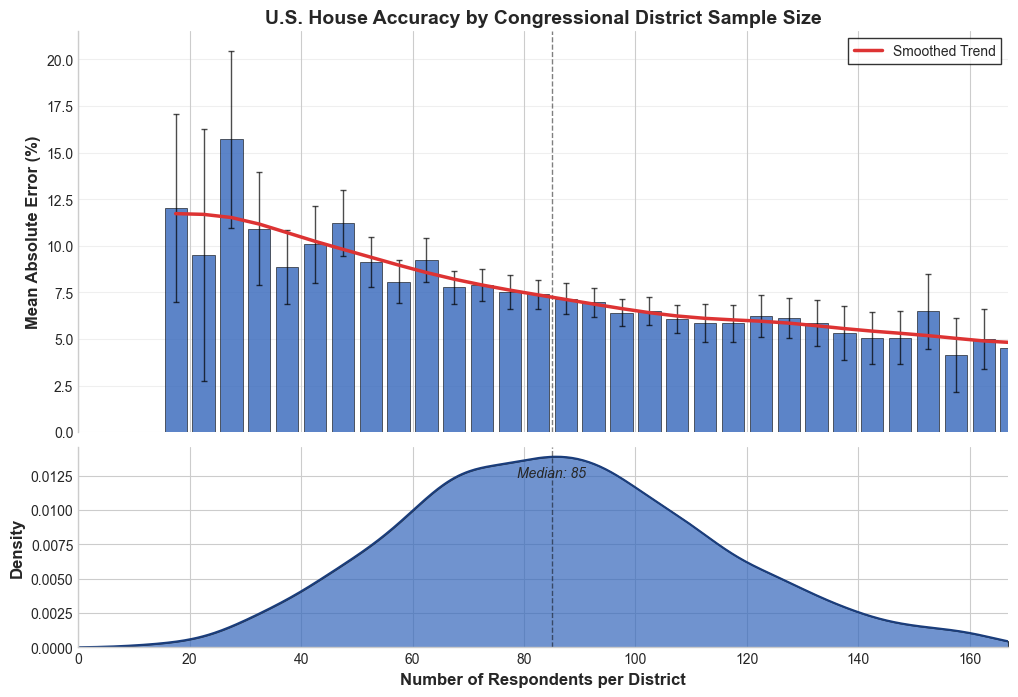


SUMMARY STATISTICS
Total districts: 2707
Median respondents: 85
Mean absolute error: 7.37%
Number of buckets (size=5): 31


In [26]:
# =============================================================================
# COMBINED FIGURE: U.S. House Error vs District Size (Density Style)
# =============================================================================
# Top panel: Bar chart with buckets of 5 respondents showing mean error
# Bottom panel: Density distribution of congressional districts by sample size
# =============================================================================

from scipy.stats import gaussian_kde

# Use districts_df from previous cell (district-level data)
# Contains: Year, State, District, n_respondents, Abs_Error

# Remove any districts with missing data
plot_data = districts_df.dropna(subset=['n_respondents', 'Abs_Error']).copy()

print(f"N districts: {len(plot_data)}")
print(f"Respondents range: {plot_data['n_respondents'].min():.0f} - {plot_data['n_respondents'].max():.0f}")

# =============================================================================
# Create buckets of 5
# =============================================================================
x = plot_data['n_respondents'].values
y = plot_data['Abs_Error'].values

# Cap at 99th percentile for cleaner visualization
x_max = np.percentile(x, 99)
bucket_size = 5
n_buckets = int(np.ceil(x_max / bucket_size))

bucket_centers = []
bucket_means = []
bucket_counts = []
bucket_sems = []

for i in range(n_buckets):
    lower = i * bucket_size
    upper = (i + 1) * bucket_size
    mask = (x >= lower) & (x < upper)
    
    if mask.sum() >= 3:  # Only include buckets with enough data
        bucket_centers.append((lower + upper) / 2)
        bucket_means.append(y[mask].mean())
        bucket_counts.append(mask.sum())
        bucket_sems.append(y[mask].std() / np.sqrt(mask.sum()))

bucket_centers = np.array(bucket_centers)
bucket_means = np.array(bucket_means)
bucket_counts = np.array(bucket_counts)
bucket_sems = np.array(bucket_sems)

# Create figure with shared x-axis
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True, 
                                gridspec_kw={'height_ratios': [2, 1], 'hspace': 0.05})

# =============================================================================
# TOP PANEL: Bar chart with buckets of 5
# =============================================================================
bar_width = bucket_size * 0.8

bars = ax1.bar(bucket_centers, bucket_means, width=bar_width, 
               color='#3366BB', edgecolor='black', linewidth=0.5, alpha=0.8)

# Add error bars
ax1.errorbar(bucket_centers, bucket_means, yerr=1.96*bucket_sems, 
             fmt='none', color='black', capsize=2, linewidth=1, alpha=0.7)

# Add smoothed trend line
from scipy.ndimage import gaussian_filter1d
if len(bucket_means) > 5:
    smoothed = gaussian_filter1d(bucket_means, sigma=2)
    ax1.plot(bucket_centers, smoothed, color='#DD3333', linewidth=2.5, 
             linestyle='-', label='Smoothed Trend', zorder=10)
    ax1.legend(loc='upper right', fontsize=10, frameon=True, fancybox=False, edgecolor='black')

ax1.set_ylabel('Mean Absolute Error (%)', fontsize=12, fontweight='bold')
ax1.set_title('U.S. House Accuracy by Congressional District Sample Size', fontsize=14, fontweight='bold')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.tick_params(axis='x', which='both', bottom=False, labelbottom=False)
ax1.grid(axis='y', linestyle='-', alpha=0.3)
ax1.set_ylim(0, None)

# =============================================================================
# BOTTOM PANEL: Density Distribution
# =============================================================================
x_density = np.linspace(0, x_max, 500)

try:
    kde = gaussian_kde(x[x <= x_max], bw_method='scott')
    density = kde(x_density)
    
    ax2.fill_between(x_density, density, alpha=0.7, color='#3366BB', edgecolor='black', linewidth=1)
    ax2.plot(x_density, density, color='#1a3d7c', linewidth=1.5)
except:
    # Fallback to histogram if KDE fails
    ax2.hist(x[x <= x_max], bins=50, density=True, alpha=0.7, color='#3366BB', edgecolor='black', linewidth=0.5)

ax2.set_xlabel('Number of Respondents per District', fontsize=12, fontweight='bold')
ax2.set_ylabel('Density', fontsize=12, fontweight='bold')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.set_ylim(0, None)
ax2.set_xlim(0, x_max)

# Add median line
median_n = np.median(x)
for ax in [ax1, ax2]:
    ax.axvline(median_n, color='black', linestyle='--', linewidth=1, alpha=0.5)

ax2.text(median_n, ax2.get_ylim()[1]*0.85, f'Median: {median_n:.0f}', 
         ha='center', fontsize=10, style='italic')

plt.tight_layout()
save_figure(fig, 'us_house_error_density_combined.png')
plt.show()

print("\n" + "="*70)
print("SUMMARY STATISTICS")
print("="*70)
print(f"Total districts: {len(plot_data)}")
print(f"Median respondents: {median_n:.0f}")
print(f"Mean absolute error: {y.mean():.2f}%")
print(f"Number of buckets (size={bucket_size}): {len(bucket_centers)}")


---
# Candidate Choice Accuracy by Office Grouping

Two perspectives on office-level accuracy differences:
1. Federal vs State-Level (Federal, State Executive, State Legislative)
2. Race Salience (High/Medium/Low visibility)

RMSE by Office (Unweighted - State Level):
  Attorney General: 11.21%
  Governor: 7.01%
  President: 7.40%
  Secretary of State: 9.75%
  State Representative: 9.71%
  State Senator: 11.15%
  U.S. House: 9.30%
  U.S. Senate: 9.37%
Saved: output/rmse_by_office_salience.png


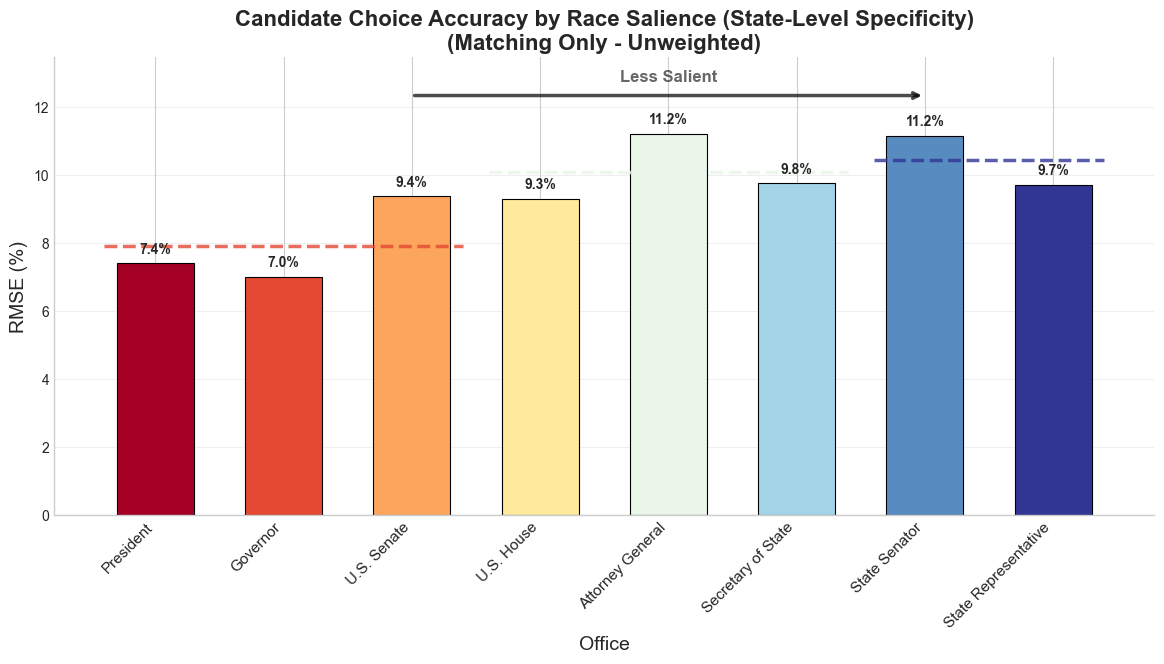


SUMMARY: RMSE by Race Salience (Unweighted - State Level)
  High (Top of Ticket): 7.9%
  Medium: 10.1%
  Low (Down-Ballot): 10.4%


In [27]:
# =============================================================================
# CANDIDATE CHOICE ACCURACY BY RACE SALIENCE (UNWEIGHTED - STATE LEVEL)
# =============================================================================

# Filter for Candidate Choice, Unweighted, Validity_Scheme='All'
df_candidate = most_specific[
    (most_specific['Class'] == 'Candidate Choice') &
    (most_specific['Weighting_Method'] == 'CES-Unweighted') &
    (most_specific['Validity_Scheme'] == 'All')
].copy()

# Calculate RMSE by office
rmse_by_office = df_candidate.groupby('Variable')['Error'].apply(calculate_rmse)

print("RMSE by Office (Unweighted - State Level):")
for office, rmse in rmse_by_office.items():
    print(f"  {office}: {rmse:.2f}%")

# Define salience groupings with specific ordering
SALIENCE_GROUPS = {
    'President': 'High (Top of Ticket)',
    'Governor': 'High (Top of Ticket)',
    'U.S. Senate': 'High (Top of Ticket)',
    'U.S. House': 'Medium',
    'Attorney General': 'Medium',
    'Secretary of State': 'Medium',
    'State Senator': 'Low (Down-Ballot)',
    'State Representative': 'Low (Down-Ballot)'
}

# Specific ordering
HIGH_ORDER = ['President', 'Governor', 'U.S. Senate']
MEDIUM_ORDER = ['U.S. House', 'Attorney General', 'Secretary of State']
LOW_ORDER = ['State Senator', 'State Representative']

# Create hot to cold gradient colors
import matplotlib.colors as mcolors
cmap = plt.cm.RdYlBu
n_offices = 8
colors_gradient = [cmap(i / (n_offices - 1)) for i in range(n_offices)]

# ============================================================
# PLOT: Race Salience/Visibility (State Level)
# ============================================================
fig, ax = plt.subplots(figsize=(12, 7))

# Build office list with specific ordering
offices_by_salience = HIGH_ORDER + MEDIUM_ORDER + LOW_ORDER

x_pos = np.arange(len(offices_by_salience))
values = [rmse_by_office.get(o, 0) for o in offices_by_salience]

# Assign gradient colors with skinnier bars
bars = ax.bar(x_pos, values, width=0.6, color=colors_gradient, edgecolor='black', linewidth=0.8)

for bar, val in zip(bars, values):
    ax.annotate(f'{val:.1f}%', xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                xytext=(0, 5), textcoords="offset points", ha='center', va='bottom', fontsize=10, fontweight='bold')

# Add salience group averages with colors matching the bars
salience_configs = [
    ('High (Top of Ticket)', HIGH_ORDER),
    ('Medium', MEDIUM_ORDER),
    ('Low (Down-Ballot)', LOW_ORDER)
]

for salience, office_list in salience_configs:
    salience_rmse = np.mean([rmse_by_office.get(o, 0) for o in office_list if o in rmse_by_office])
    indices = [i for i, o in enumerate(offices_by_salience) if o in office_list]
    if indices:
        # Get the middle color of this group for the line
        mid_idx = indices[len(indices) // 2]
        line_color = colors_gradient[mid_idx]
        
        ax.hlines(salience_rmse, min(indices) - 0.4, max(indices) + 0.4,
                   colors=line_color, linestyles='--', linewidth=2.5, alpha=0.8)

# Add arrow indicating direction of decreasing salience - CENTERED
arrow_y = max(values) * 1.1
arrow_start = len(offices_by_salience) / 4
arrow_end = 3 * len(offices_by_salience) / 4
ax.annotate('', xy=(arrow_end, arrow_y), xytext=(arrow_start, arrow_y),
            arrowprops=dict(arrowstyle='->', lw=2.5, color='black', alpha=0.7))
ax.text((arrow_start + arrow_end) / 2, arrow_y + max(values) * 0.03, 
        'Less Salient', ha='center', va='bottom', fontsize=12, fontweight='bold', alpha=0.7)

ax.set_xlabel('Office', fontsize=14)
ax.set_ylabel('RMSE (%)', fontsize=14)
ax.set_title('Candidate Choice Accuracy by Race Salience (State-Level Specificity)\n(Matching Only - Unweighted)', fontsize=16, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(offices_by_salience, rotation=45, ha='right', fontsize=11)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylim(0, max(values) * 1.2)
ax.grid(axis='y', linestyle='-', alpha=0.3)

save_figure(fig, 'rmse_by_office_salience.png')
plt.show()

# Print summary
print("\n" + "="*60)
print("SUMMARY: RMSE by Race Salience (Unweighted - State Level)")
print("="*60)
for salience, office_list in salience_configs:
    salience_rmse = np.mean([rmse_by_office.get(o, 0) for o in office_list if o in rmse_by_office])
    print(f"  {salience}: {salience_rmse:.1f}%")


RMSE by Office (Unweighted - Party Level):
  Attorney General: 11.52%
  Governor: 4.90%
  Secretary of State: 9.34%
  State Representative: 9.71%
  State Senator: 11.15%
  U.S. House: 6.67%
  U.S. Senate: 14.05%
Saved: output/rmse_by_office_salience_party.png


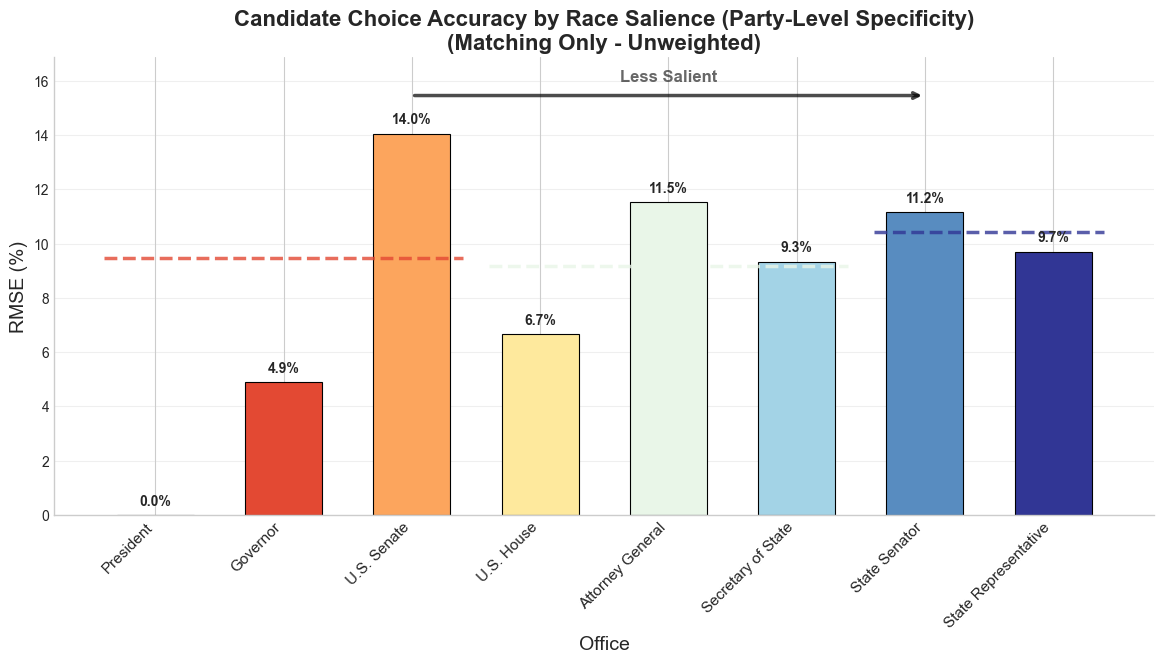


SUMMARY: RMSE by Race Salience (Unweighted - Party Level)
  High (Top of Ticket): 9.5%
  Medium: 9.2%
  Low (Down-Ballot): 10.4%


In [28]:
# =============================================================================
# CANDIDATE CHOICE ACCURACY BY RACE SALIENCE (UNWEIGHTED - PARTY LEVEL)
# =============================================================================

# Filter for Party specificity, Unweighted, Validity_Scheme='All'
df_candidate_party = metrics_base_full[
    (metrics_base_full['Class'] == 'Candidate Choice') &
    (metrics_base_full['Weighting_Method'] == 'CES-Unweighted') &
    (metrics_base_full['Validity_Scheme'] == 'All') &
    (metrics_base_full['Specificity'] == 'Party')
].copy()

# Calculate RMSE by office
rmse_by_office_party = df_candidate_party.groupby('Variable')['Error'].apply(calculate_rmse)

print("RMSE by Office (Unweighted - Party Level):")
for office, rmse in rmse_by_office_party.items():
    print(f"  {office}: {rmse:.2f}%")

# Define salience groupings with specific ordering
SALIENCE_GROUPS_PARTY = {
    'President': 'High (Top of Ticket)',
    'Governor': 'High (Top of Ticket)',
    'U.S. Senate': 'High (Top of Ticket)',
    'U.S. House': 'Medium',
    'Attorney General': 'Medium',
    'Secretary of State': 'Medium',
    'State Senator': 'Low (Down-Ballot)',
    'State Representative': 'Low (Down-Ballot)'
}

# Specific ordering
HIGH_ORDER_P = ['President', 'Governor', 'U.S. Senate']
MEDIUM_ORDER_P = ['U.S. House', 'Attorney General', 'Secretary of State']
LOW_ORDER_P = ['State Senator', 'State Representative']

# Create hot to cold gradient colors
import matplotlib.colors as mcolors
cmap_p = plt.cm.RdYlBu
n_offices_p = 8
colors_gradient_p = [cmap_p(i / (n_offices_p - 1)) for i in range(n_offices_p)]

# ============================================================
# PLOT: Race Salience/Visibility (Party Level)
# ============================================================
fig, ax = plt.subplots(figsize=(12, 7))

# Build office list with specific ordering
offices_by_salience_p = HIGH_ORDER_P + MEDIUM_ORDER_P + LOW_ORDER_P

x_pos_p = np.arange(len(offices_by_salience_p))
values_p = [rmse_by_office_party.get(o, 0) for o in offices_by_salience_p]

# Assign gradient colors with skinnier bars
bars_p = ax.bar(x_pos_p, values_p, width=0.6, color=colors_gradient_p, edgecolor='black', linewidth=0.8)

for bar, val in zip(bars_p, values_p):
    ax.annotate(f'{val:.1f}%', xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                xytext=(0, 5), textcoords="offset points", ha='center', va='bottom', fontsize=10, fontweight='bold')

# Add salience group averages with colors matching the bars
salience_configs_p = [
    ('High (Top of Ticket)', HIGH_ORDER_P),
    ('Medium', MEDIUM_ORDER_P),
    ('Low (Down-Ballot)', LOW_ORDER_P)
]

for salience, office_list in salience_configs_p:
    salience_rmse = np.mean([rmse_by_office_party.get(o, 0) for o in office_list if o in rmse_by_office_party])
    indices = [i for i, o in enumerate(offices_by_salience_p) if o in office_list]
    if indices:
        # Get the middle color of this group for the line
        mid_idx = indices[len(indices) // 2]
        line_color = colors_gradient_p[mid_idx]
        
        ax.hlines(salience_rmse, min(indices) - 0.4, max(indices) + 0.4,
                   colors=line_color, linestyles='--', linewidth=2.5, alpha=0.8)

# Add arrow indicating direction of decreasing salience - CENTERED
arrow_y_p = max(values_p) * 1.1
arrow_start_p = len(offices_by_salience_p) / 4
arrow_end_p = 3 * len(offices_by_salience_p) / 4
ax.annotate('', xy=(arrow_end_p, arrow_y_p), xytext=(arrow_start_p, arrow_y_p),
            arrowprops=dict(arrowstyle='->', lw=2.5, color='black', alpha=0.7))
ax.text((arrow_start_p + arrow_end_p) / 2, arrow_y_p + max(values_p) * 0.03, 
        'Less Salient', ha='center', va='bottom', fontsize=12, fontweight='bold', alpha=0.7)

ax.set_xlabel('Office', fontsize=14)
ax.set_ylabel('RMSE (%)', fontsize=14)
ax.set_title('Candidate Choice Accuracy by Race Salience (Party-Level Specificity)\n(Matching Only - Unweighted)', fontsize=16, fontweight='bold')
ax.set_xticks(x_pos_p)
ax.set_xticklabels(offices_by_salience_p, rotation=45, ha='right', fontsize=11)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylim(0, max(values_p) * 1.2)
ax.grid(axis='y', linestyle='-', alpha=0.3)

save_figure(fig, 'rmse_by_office_salience_party.png')
plt.show()

# Print summary
print("\n" + "="*60)
print("SUMMARY: RMSE by Race Salience (Unweighted - Party Level)")
print("="*60)
for salience, office_list in salience_configs_p:
    salience_offices = [o for o in office_list if o in rmse_by_office_party]
    if salience_offices:
        salience_rmse = np.mean([rmse_by_office_party.get(o, 0) for o in salience_offices])
        print(f"  {salience}: {salience_rmse:.1f}%")


---
# Race Salience: Party-Level Specificity

Same salience analysis but using Party-level specificity for all offices (includes State Senator and State Representative).

---
# Party vs Candidate Specificity Comparison

For offices that have both Party and Candidate level data, compare RMSE using only overlapping years.

In [29]:
# =============================================================================
# PARTY VS CANDIDATE SPECIFICITY COMPARISON
# =============================================================================

df_cc = metrics_base_full[
    (metrics_base_full['Class'] == 'Candidate Choice') &
    (metrics_base_full['Weighting_Method'] == 'CES-Provided Weights') &
    (metrics_base_full['Validity_Scheme'] == 'All')
].copy()

both_offices = ['President', 'U.S. Senate', 'U.S. House', 'Governor', 'Attorney General', 'Secretary of State']

print("="*80)
print("RMSE COMPARISON: PARTY vs CANDIDATE SPECIFICITY")
print("(Using only years where BOTH are available)")
print("="*80)

results = []
for office in both_offices:
    party_years = set(df_cc[(df_cc['Variable'] == office) & (df_cc['Specificity'] == 'Party')]['Year'].unique())
    cand_years = set(df_cc[(df_cc['Variable'] == office) & (df_cc['Specificity'] == 'Candidate')]['Year'].unique())
    overlap_years = party_years & cand_years
    
    if not overlap_years:
        continue
    
    df_office = df_cc[(df_cc['Variable'] == office) & (df_cc['Year'].isin(overlap_years))]
    rmse_party = calculate_rmse(df_office[df_office['Specificity'] == 'Party']['Error'])
    rmse_cand = calculate_rmse(df_office[df_office['Specificity'] == 'Candidate']['Error'])
    
    results.append({
        'Office': office,
        'Years': f"{min(overlap_years)}-{max(overlap_years)}",
        'RMSE_Party': rmse_party,
        'RMSE_Candidate': rmse_cand,
        'Difference': rmse_cand - rmse_party
    })

results_df = pd.DataFrame(results).sort_values('Difference', ascending=False)

print(f"\n{'Office':<20} {'Years':<12} {'Party':<10} {'Candidate':<12} {'Diff':<10}")
print("-"*70)
for _, row in results_df.iterrows():
    print(f"{row['Office']:<20} {row['Years']:<12} {row['RMSE_Party']:>6.1f}%    {row['RMSE_Candidate']:>8.1f}%    {row['Difference']:>+6.1f}%")

# Create comparison plot
fig, ax = plt.subplots(figsize=(12, 7))

offices_sorted = results_df.sort_values('RMSE_Party')['Office'].tolist()
x = np.arange(len(offices_sorted))
width = 0.35

party_vals = [results_df[results_df['Office'] == o]['RMSE_Party'].values[0] for o in offices_sorted]
cand_vals = [results_df[results_df['Office'] == o]['RMSE_Candidate'].values[0] for o in offices_sorted]

bars1 = ax.bar(x - width/2, party_vals, width, label='Party', color=SPECIFICITY_COLORS['Party'], edgecolor='black', linewidth=0.8)
bars2 = ax.bar(x + width/2, cand_vals, width, label='Candidate', color=SPECIFICITY_COLORS['Candidate'], edgecolor='black', linewidth=0.8)

for bar in bars1:
    ax.annotate(f'{bar.get_height():.1f}%', xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=9)
for bar in bars2:
    ax.annotate(f'{bar.get_height():.1f}%', xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=9)

ax.set_xlabel('Office', fontsize=14)
ax.set_ylabel('RMSE (%)', fontsize=14)
ax.set_title('Party vs Candidate Specificity: RMSE Comparison\n(Matching + Post-Strat., Overlapping Years Only)', fontsize=16, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(offices_sorted, rotation=45, ha='right', fontsize=11)
ax.legend(loc='upper left', fontsize=12, frameon=True, fancybox=False, edgecolor='black')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylim(0, max(max(party_vals), max(cand_vals)) * 1.15)
ax.grid(axis='y', linestyle='-', alpha=0.3)

save_figure(fig, 'rmse_party_vs_candidate_comparison.png')
plt.show()

save_latex_table(df_to_latex_table(
    results_df,
    'Party vs Candidate RMSE Comparison',
    'rmse_party_vs_candidate_comparison',
    'RMSE comparison between party-level and candidate-level specificity across offices.'
), 'rmse_party_vs_candidate_comparison.tex')
print("\nSaved: output/rmse_party_vs_candidate_comparison.tex")

RMSE COMPARISON: PARTY vs CANDIDATE SPECIFICITY
(Using only years where BOTH are available)


KeyError: 'Difference'

In [ ]:
# =============================================================================
# RMSE BY RACE COMPETITIVENESS (HISTOGRAM)
# =============================================================================

# Filter: Candidate Choice, All validity, CES Weights
data_competitiveness = most_specific[
    (most_specific['Class'] == 'Candidate Choice') & 
    (most_specific['Validity_Scheme'] == 'All') & 
    (most_specific['Weighting_Method'] == 'CES-Provided Weights')
].copy()

# Calculate absolute error
data_competitiveness['Abs_Error'] = data_competitiveness['Error'].abs()

# Define bands with darker colors (symmetric)
bands = [
    (0, 20, '0-20%', '#d9867d'),      # Darker red-pink
    (20, 40, '20-40%', '#e8b89d'),    # Darker tan
    (40, 60, '40-60%', '#d4e8b8'),    # Darker soft green (most competitive)
    (60, 80, '60-80%', '#e8b89d'),    # Darker tan
    (80, 90, '80-90%', '#e8b89d'),    # Darker tan
    (90, 100, '90-100%', '#d9867d'),  # Darker red-pink
]

# Calculate RMSE for each band
band_labels = []
rmse_values = []
colors = []
sample_sizes = []

for start, end, label, color in bands:
    band_data = data_competitiveness[(data_competitiveness['Benchmark'] >= start) & 
                                      (data_competitiveness['Benchmark'] < end)]
    if len(band_data) > 0:
        rmse = np.sqrt(np.mean(band_data['Abs_Error'] ** 2))
        band_labels.append(label)
        rmse_values.append(rmse)
        colors.append(color)
        sample_sizes.append(len(band_data))

# Create histogram
fig, ax = plt.subplots(figsize=(14, 7))

# Create bars
bars = ax.bar(range(len(band_labels)), rmse_values, color=colors, 
              edgecolor='#555555', linewidth=1.5, alpha=0.92)

# Add value labels on bars (positioned at 60% height)
for i, (bar, rmse, n) in enumerate(zip(bars, rmse_values, sample_sizes)):
    height = bar.get_height()
    y_pos = height * 0.6
    ax.text(bar.get_x() + bar.get_width()/2., y_pos,
            f'{rmse:.1f}\n(n={n:,})',
            ha='center', va='center', fontsize=10, fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.4', facecolor='white', 
                     edgecolor='none', alpha=0.85))

# Styling
ax.set_xlabel('Benchmark Vote Share Range', fontsize=13, fontweight='bold', labelpad=10)
ax.set_ylabel('RMSE (%)', fontsize=13, fontweight='bold', labelpad=10)
ax.set_title('RMSE by Race Competitiveness (Matching + Post-Stratification Estimates)', 
            fontsize=15, fontweight='bold', pad=15)

ax.set_xticks(range(len(band_labels)))
ax.set_xticklabels(band_labels, fontsize=11)
ax.set_ylim(0, max(rmse_values) * 1.1)
ax.set_yticks(np.arange(0, max(rmse_values) * 1.1, 5))
ax.set_yticklabels(np.arange(0, max(rmse_values) * 1.1, 5), fontsize=10)

ax.grid(axis='y', alpha=0.3, linestyle='--', linewidth=0.5)
ax.set_axisbelow(True)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(1.2)
ax.spines['bottom'].set_linewidth(1.2)

# Add competitiveness label
ax.text(2.5, max(rmse_values) * 1.05, 
       '← Less Competitive | Most Competitive | Less Competitive →',
       ha='center', fontsize=11, fontweight='bold', color='#333333', style='italic')

ax.set_facecolor('white')
style_axis(ax)

save_figure(fig, 'rmse_by_competitiveness_histogram.png')

In [ ]:
# =============================================================================
# ERROR VS RACE COMPETITIVENESS (SCATTER PLOT WITH COLORED BANDS)
# =============================================================================

# Filter: Candidate Choice, All validity, CES Weights
data_competitiveness_scatter = most_specific[
    (most_specific['Class'] == 'Candidate Choice') & 
    (most_specific['Validity_Scheme'] == 'All') & 
    (most_specific['Weighting_Method'] == 'CES-Provided Weights')
].copy()

# Calculate absolute error
data_competitiveness_scatter['Abs_Error'] = data_competitiveness_scatter['Error'].abs()

# Define bands with darker colors (symmetric)
bands_scatter = [
    (0, 20, '0-20%', '#d9867d'),      # Darker red-pink
    (20, 40, '20-40%', '#e8b89d'),    # Darker tan
    (40, 60, '40-60%', '#d4e8b8'),    # Darker soft green (most competitive)
    (60, 80, '60-80%', '#e8b89d'),    # Darker tan
    (80, 90, '80-90%', '#e8b89d'),    # Darker tan
    (90, 100, '90-100%', '#d9867d'),  # Darker red-pink
]

# Calculate RMSE for each band
band_stats_scatter = []
for start, end, label, color in bands_scatter:
    band_data = data_competitiveness_scatter[
        (data_competitiveness_scatter['Benchmark'] >= start) & 
        (data_competitiveness_scatter['Benchmark'] < end)
    ]
    if len(band_data) > 0:
        rmse = np.sqrt(np.mean(band_data['Abs_Error'] ** 2))
        band_stats_scatter.append({
            'label': label,
            'start': start,
            'end': end,
            'rmse': rmse,
            'n': len(band_data),
            'color': color
        })

# Create figure
fig, ax = plt.subplots(figsize=(16, 8))

# Draw background bands
from matplotlib.patches import Rectangle, FancyBboxPatch
for stat in band_stats_scatter:
    rect = Rectangle((stat['start'], 0), stat['end'] - stat['start'], 32, 
                      facecolor=stat['color'], edgecolor='none', linewidth=0, zorder=0)
    ax.add_patch(rect)

# Add subtle dividing lines between bands
for start, end, label, color in bands_scatter:
    ax.axvline(x=end, color='white', linewidth=1.5, linestyle='-', alpha=0.6, zorder=0)

# Scatter plot with smaller, less opaque dots
ax.scatter(data_competitiveness_scatter['Benchmark'], data_competitiveness_scatter['Abs_Error'], 
          s=20, alpha=0.25, color='#5a5a5a', edgecolors='none', zorder=2)

# Add RMSE boxes
for stat in band_stats_scatter:
    if stat['n'] > 0:
        x_pos = (stat['start'] + stat['end']) / 2
        y_pos = 20  # Lower position, closer to center
        
        rmse_text = f"RMSE: {stat['rmse']:.1f}\nn={stat['n']:,}"
        
        box = FancyBboxPatch((x_pos - 4.5, y_pos - 1.5), 9, 3,
                            boxstyle="round,pad=0.3",
                            facecolor='white', 
                            edgecolor='#888888', 
                            linewidth=1.2,
                            alpha=0.95,
                            zorder=10)
        ax.add_patch(box)
        
        ax.text(x_pos, y_pos, rmse_text, 
               ha='center', va='center',
               fontsize=8.5, fontweight='bold', zorder=11)

# Set labels and title
ax.set_xlabel('Benchmark Vote Share (%)', fontsize=13, fontweight='bold', labelpad=25)
ax.set_ylabel('Absolute Error (%)', fontsize=13, fontweight='bold', labelpad=10)
ax.set_title('Error vs. Race Competitiveness (Matching + Post-Stratification Estimates)', 
            fontsize=15, fontweight='bold', pad=15)

# Set limits
ax.set_xlim(-2, 102)
ax.set_ylim(0, 32)

ax.set_xticks(np.arange(0, 101, 10))
ax.set_xticklabels(np.arange(0, 101, 10), fontsize=10)
ax.set_yticks(np.arange(0, 31, 5))
ax.set_yticklabels(np.arange(0, 31, 5), fontsize=10)

# Add band labels at bottom
label_positions = [(10, -2.5), (30, -2.5), (50, -2.5), (70, -2.5), (85, -2.5), (95, -2.5)]
label_texts = ['0-20%', '20-40%', '40-60%', '60-80%', '80-90%', '90-100%']

for pos, label in zip(label_positions, label_texts):
    fontweight = 'bold' if label == '40-60%' else 'normal'
    ax.text(pos[0], pos[1], label, ha='center', fontsize=9, fontweight=fontweight)

# Add competitiveness text
ax.text(-1, -4.5, '← Less Competitive', ha='right', fontsize=10, fontweight='bold', color='#333333')
ax.text(101, -4.5, 'Less Competitive →', ha='left', fontsize=10, fontweight='bold', color='#333333')
ax.text(50, -5.8, '(Most Competitive)', ha='center', fontsize=10, 
       color='green', fontweight='bold', style='italic')

# Draw competitiveness arrows
arrow_y = -4
ax.annotate('', xy=(40, arrow_y), xytext=(0, arrow_y),
            arrowprops=dict(arrowstyle='<-', lw=2, color='#666666', alpha=0.7))
ax.annotate('', xy=(100, arrow_y), xytext=(60, arrow_y),
            arrowprops=dict(arrowstyle='->', lw=2, color='#666666', alpha=0.7))

# Styling
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(1.2)
ax.spines['bottom'].set_linewidth(1.2)
ax.grid(axis='y', alpha=0.2, linestyle='--', linewidth=0.5)
ax.set_axisbelow(True)
ax.set_facecolor('white')

style_axis(ax)


In [ ]:
# =============================================================================
# ERROR DISTRIBUTION BY CLASS - SIDE BY SIDE (SECONDARY VARIABLES ONLY)
# =============================================================================

# Filter for Secondary variables only (Matching + Post-Stratification, All validity)
df_hist_classes = most_specific[
    (most_specific['Weighting_Method'] == 'CES-Provided Weights') &
    (most_specific['Validity_Scheme'] == 'All') &
    (most_specific['Variable_Type'] == 'Secondary')
].copy()

# Define class colors
class_colors_dist = {
    'Demographic': '#3366BB',
    'Voting Administration': '#DD3333',
    'Candidate Choice': '#33AA55'
}
class_order_dist = ['Demographic', 'Voting Administration', 'Candidate Choice']

# Create figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Distribution of Absolute Errors by Variable Class (Secondary Variables Only)',
             fontsize=16, fontweight='bold', y=1.02)

# Get overall min and max for consistent axis limits
all_errors = df_hist_classes['Error'].abs()
x_max = all_errors.quantile(0.99)  # 99th percentile for better visibility
y_max = 0

# First pass: find max y value (in percent)
for class_name in class_order_dist:
    class_data = df_hist_classes[df_hist_classes['Class'] == class_name]['Error'].abs()
    if len(class_data) > 0:
        weights = np.ones_like(class_data) / len(class_data) * 100  # Convert to percent
        counts, _ = np.histogram(class_data, bins=50, range=(0, x_max), weights=weights)
        y_max = max(y_max, counts.max())

# Plot each class
for idx, class_name in enumerate(class_order_dist):
    ax = axes[idx]
    class_data = df_hist_classes[df_hist_classes['Class'] == class_name]['Error'].abs()
    
    if len(class_data) > 0:
        # Use weights to convert to percentages
        weights = np.ones_like(class_data) / len(class_data) * 100
        ax.hist(class_data, bins=50, range=(0, x_max), weights=weights,
               color=class_colors_dist[class_name], alpha=0.8, edgecolor='black', linewidth=0.5)
        
        # Calculate and display standard deviation
        std_dev = class_data.std()
        ax.text(0.95, 0.95, f'SD = {std_dev:.2f}', 
                transform=ax.transAxes, fontsize=11, fontweight='bold',
                verticalalignment='top', horizontalalignment='right',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8, edgecolor='black', linewidth=1))
    
    ax.set_xlabel('Percentage Point Absolute Error', fontsize=12, fontweight='bold')
    ax.set_ylabel('Share of Errors (%)', fontsize=12, fontweight='bold')
    ax.set_title(class_name, fontsize=13, fontweight='bold', pad=10)
    ax.set_ylim(0, y_max * 1.1)
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    ax.set_axisbelow(True)
    
    # Style spines (but don't use style_axis() since it overrides our labels)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis='both', labelsize=11)

plt.tight_layout()
save_figure(fig, 'error_distribution_by_class_sidebyside.png')
plt.show()

print("\n" + "="*70)
print("ERROR DISTRIBUTION BY CLASS (SECONDARY VARIABLES ONLY)")
print("="*70)
for class_name in class_order_dist:
    class_data = df_hist_classes[df_hist_classes['Class'] == class_name]
    n_vars = class_data['Variable'].nunique()
    n_obs = len(class_data)
    abs_errors = class_data['Error'].abs()
    std_dev = abs_errors.std()
    print(f"{class_name}: {n_vars} variables, {n_obs} observations, SD = {std_dev:.2f}")


In [ ]:
# =============================================================================
# RMSE BY WEIGHTING METHOD (BY VARIABLE CLASS) - MEAN OF MEANS
# =============================================================================

# Mean-of-means approach: calculate variable-level RMSE, then average

class_order_weight = ['Demographic', 'Voting Administration', 'Candidate Choice']
weighting_order = ['CES-Unweighted', 'CES-Provided Weights', 'ANESRake-Full', 'ANESRake-Restricted']
subset_all = most_specific[most_specific['Validity_Scheme'] == 'All'].copy()

fig, axes = plt.subplots(3, 1, figsize=(14, 12))
fig.suptitle('RMSE by Weighting Method and Variable Class (Mean of Variables)', 
             fontsize=16, fontweight='bold', y=0.995)

for plot_idx, class_name in enumerate(class_order_weight):
    ax = axes[plot_idx]
    
    class_data = subset_all[subset_all['Class'] == class_name]
    
    # Calculate variable-level RMSE first
    var_rmse = class_data.groupby(['Year', 'Variable', 'Weighting_Method']).apply(
        lambda x: np.sqrt(np.mean(x['Error'] ** 2)),
        include_groups=False
    ).reset_index(name='RMSE')
    
    # Average across variables for each year/weighting method
    rmse_data = var_rmse.groupby(['Year', 'Weighting_Method'])['RMSE'].mean().reset_index()
    
    years = sorted(rmse_data['Year'].unique())
    x = np.arange(len(years))
    width = 0.2
    
    for i, weighting in enumerate(weighting_order):
        weighting_data = rmse_data[rmse_data['Weighting_Method'] == weighting]
        if len(weighting_data) > 0:
            rmse_values = []
            for year in years:
                year_data = weighting_data[weighting_data['Year'] == year]
                if len(year_data) > 0:
                    rmse_values.append(year_data['RMSE'].values[0])
                else:
                    rmse_values.append(np.nan)
            
            ax.bar(x + (i - 1.5) * width, rmse_values, width, 
                   label=weighting, color=WEIGHTING_COLORS[weighting], 
                   edgecolor='black', linewidth=0.5, alpha=0.85)
    
    ax.set_xlabel('Year', fontsize=11, fontweight='bold')
    ax.set_ylabel('RMSE (%)', fontsize=11, fontweight='bold')
    ax.set_title(f'Variable Class: {class_name}', fontsize=12, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(years)
    ax.legend(fontsize=9, loc='upper right')
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    ax.set_axisbelow(True)
    style_axis(ax)

plt.tight_layout()
save_figure(fig, 'rmse_by_weighting_method_class.png')

In [ ]:
# =============================================================================
# RMSE REDUCTION BY OFFICE (CANDIDATE CHOICE) - INLAID BAR STYLE
# =============================================================================

# Mean-of-means: average RMSE per variable across years
# Shows how post-stratification "draws down" error for each office

cc_data = most_specific[most_specific['Class'] == 'Candidate Choice'].copy()

# Calculate RMSE per year per variable first
year_var_rmse = cc_data.groupby(['Year', 'Variable', 'Weighting_Method', 'Variable_Type']).apply(
    lambda x: np.sqrt(np.mean(x['Error'] ** 2)),
    include_groups=False
).reset_index(name='RMSE')

# Average across years (mean-of-means)
var_rmse = year_var_rmse.groupby(['Variable', 'Weighting_Method', 'Variable_Type'])['RMSE'].mean().reset_index()

offices = ['President', 'U.S. Senate', 'Governor', 'U.S. House', 
          'State Senator', 'State Representative', 'Attorney General', 'Secretary of State']

# Separate Primary and Secondary
primary_offices = []
secondary_offices = []

for office in offices:
    office_data = var_rmse[var_rmse['Variable'] == office]
    var_types = sorted(office_data['Variable_Type'].unique())
    
    for var_type in var_types:
        var_data = office_data[office_data['Variable_Type'] == var_type]
        
        unweighted = var_data[var_data['Weighting_Method'] == 'CES-Unweighted']['RMSE'].values
        weighted = var_data[var_data['Weighting_Method'] == 'CES-Provided Weights']['RMSE'].values
        
        if len(unweighted) > 0 and len(weighted) > 0:
            # Percentage point difference (improvement is positive when weighted < unweighted)
            improvement = unweighted[0] - weighted[0]
            
            entry = {
                'office': office,
                'var_type': var_type,
                'unweighted': unweighted[0],
                'weighted': weighted[0],
                'improvement': improvement
            }
            
            if var_type == 'Primary':
                primary_offices.append(entry)
            else:
                secondary_offices.append(entry)

# Plot Primary then Secondary
all_entries = primary_offices + secondary_offices
divider_index = len(primary_offices)

fig, ax = plt.subplots(figsize=(14, 7))

width = 0.6
x_pos = np.arange(len(all_entries))
xticklabels = []

# Colors matching the example: dark blue for unweighted base, light blue for weighted overlay
unweighted_color = '#044c7c'  # Dark blue
weighted_color = '#44bbc3'    # Light blue

for idx, entry in enumerate(all_entries):
    # First plot the full unweighted bar (base)
    ax.bar(x_pos[idx], entry['unweighted'], width, 
           label='Matching Only' if idx == 0 else '', 
           color=unweighted_color, edgecolor='black', linewidth=0.8, zorder=2)
    
    # Then overlay the weighted bar on top (shows how much error remains)
    ax.bar(x_pos[idx], entry['weighted'], width, 
           label='Matching + Post-Stratification' if idx == 0 else '', 
           color=weighted_color, edgecolor='black', linewidth=0.8, zorder=2)
    
    # Add improvement label above the bar
    improvement_text = f"-{entry['improvement']:.1f}pp" if entry['improvement'] > 0 else f"+{abs(entry['improvement']):.1f}pp"
    ax.text(x_pos[idx], entry['unweighted'] + 0.3, improvement_text,
           ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    # Create labels - fixed the syntax error here
    office_name = entry['office']
    var_type_letter = entry['var_type'][0]
    label = f"{office_name}\n({var_type_letter})"
    xticklabels.append(label)

# Add divider between Primary and Secondary
if divider_index > 0:
    divider_pos = divider_index - 0.5
    ax.axvline(x=divider_pos, color='red', linestyle='--', linewidth=2.5, alpha=0.6, zorder=1)
    ax.text(divider_pos, ax.get_ylim()[1] * 0.95, '  PRIMARY | SECONDARY  ', 
           ha='center', fontsize=12, fontweight='bold', color='red',
           bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.95, edgecolor='red'))

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add y-axis grid
ax.yaxis.grid(True, linestyle='-', alpha=0.3, zorder=0)
ax.set_axisbelow(True)

ax.set_ylabel('RMSE (%)', fontsize=14, fontweight='bold')
ax.set_xlabel('Office (P=Primary, S=Secondary)', fontsize=14, fontweight='bold')
ax.set_title('Error Reduction from Post-Stratification by Office\n(Mean of Variables, Averaged Across Years)', 
            fontsize=16, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(xticklabels, fontsize=10)
ax.legend(fontsize=12, loc='upper right', frameon=True, fancybox=False, edgecolor='black')

plt.tight_layout()
save_figure(fig, 'rmse_reduction_by_office.png')
plt.show()


In [ ]:
# =============================================================================
# RMSE BY YEAR (WEIGHTING COMPARISON) - 4 SUBPLOTS WITH INLAID DESIGN
# =============================================================================

df_all = most_specific[most_specific['Validity_Scheme'] == 'All'].copy()

# Identify variables present in ALL years
all_years = set(df_all['Year'].unique())
var_years = df_all.groupby('Variable')['Year'].apply(set).to_dict()
vars_in_all_years = [var for var, years in var_years.items() if years == all_years]

print(f"Variables present in all years: {vars_in_all_years}")

# Identify consistently secondary variables
var_types_by_year = df_all.groupby(['Variable', 'Year'])['Variable_Type'].first().reset_index()
var_consistency_secondary = var_types_by_year.groupby('Variable')['Variable_Type'].apply(
    lambda x: (x.nunique() == 1) and (x.iloc[0] == 'Secondary')
).to_dict()
consistent_secondary = [var for var, is_consistent in var_consistency_secondary.items() if is_consistent]

print(f"Consistently Secondary: {consistent_secondary}")

# Create 4 subplots
fig, axes = plt.subplots(4, 1, figsize=(14, 12))
fig.suptitle('RMSE Reduction Due to Post-Stratification', 
             fontsize=16, fontweight='bold', y=0.997)

# Define the 4 variants
variants = [
    ('All Variables (Present in All Years)', lambda x: x[x['Variable'].isin(vars_in_all_years)]),
    ('Consistently Secondary Variables', lambda x: x[x['Variable'].isin(consistent_secondary)]),
    ('Candidate Choice Class', lambda x: x[x['Class'] == 'Candidate Choice']),
    ('Demographic Class', lambda x: x[x['Class'] == 'Demographic'])
]

# Colors matching inlaid style
unweighted_color = '#044c7c'  # Dark blue
weighted_color = '#44bbc3'    # Light blue

for plot_idx, (title, filter_func) in enumerate(variants):
    ax = axes[plot_idx]
    
    filtered_data = filter_func(df_all)
    
    if len(filtered_data) == 0:
        ax.text(0.5, 0.5, 'No data available', ha='center', va='center', 
               transform=ax.transAxes, fontsize=12)
        ax.set_title(title, fontsize=12, fontweight='bold')
        continue
    
    # Calculate variable-level RMSE first
    var_rmse = filtered_data.groupby(['Year', 'Variable', 'Weighting_Method']).apply(
        lambda x: np.sqrt(np.mean(x['Error'] ** 2)),
        include_groups=False
    ).reset_index(name='RMSE')
    
    # Average across variables for each year/weighting method
    rmse_data = var_rmse.groupby(['Year', 'Weighting_Method'])['RMSE'].mean().reset_index()
    
    years = sorted(rmse_data['Year'].unique())
    x = np.arange(len(years))
    width = 0.6
    
    # Get unweighted and weighted values
    unweighted_vals = []
    weighted_vals = []
    improvements = []
    
    for year in years:
        unwtd = rmse_data[(rmse_data['Year'] == year) & 
                         (rmse_data['Weighting_Method'] == 'CES-Unweighted')]['RMSE'].values
        wtd = rmse_data[(rmse_data['Year'] == year) & 
                       (rmse_data['Weighting_Method'] == 'CES-Provided Weights')]['RMSE'].values
        
        if len(unwtd) > 0 and len(wtd) > 0:
            unweighted_vals.append(unwtd[0])
            weighted_vals.append(wtd[0])
            improvements.append(unwtd[0] - wtd[0])
        else:
            unweighted_vals.append(np.nan)
            weighted_vals.append(np.nan)
            improvements.append(np.nan)
    
    # Plot inlaid bars
    # First: unweighted (base layer)
    ax.bar(x, unweighted_vals, width, 
           label='Matching Only' if plot_idx == 0 else '', 
           color=unweighted_color, edgecolor='black', linewidth=0.8, zorder=2)
    
    # Second: weighted (overlay on top)
    ax.bar(x, weighted_vals, width, 
           label='Matching + Post-Stratification' if plot_idx == 0 else '', 
           color=weighted_color, edgecolor='black', linewidth=0.8, zorder=2)
    
    # Add improvement labels with % sign
    for j, (year, unwtd_val, improvement) in enumerate(zip(years, unweighted_vals, improvements)):
        if not np.isnan(improvement):
            improvement_text = f"-{improvement:.1f}%" if improvement > 0 else f"+{abs(improvement):.1f}%"
            ax.text(x[j], unwtd_val + 0.3, improvement_text,
                   ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    # Styling
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.yaxis.grid(True, linestyle='-', alpha=0.3, zorder=0)
    ax.set_axisbelow(True)
    
    ax.set_xlabel('Year', fontsize=11, fontweight='bold')
    ax.set_ylabel('RMSE (%)', fontsize=11, fontweight='bold')
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels([int(y) for y in years], fontsize=10)
    
    if plot_idx == 0:
        ax.legend(fontsize=11, loc='upper right', frameon=True, fancybox=False, edgecolor='black')

plt.tight_layout()
save_figure(fig, 'rmse_by_year_weighting_comparison.png')
plt.show()


In [ ]:
# =============================================================================
# ANESRAKE WEIGHTING ANALYSIS - FULL AND RESTRICTED SCHEMES
# Only includes variables present in ALL years within each scheme
# =============================================================================

# =============================================================================
# 1. ANESRake-Full Analysis: Plot + LaTeX Table
# =============================================================================

# Filter for ANESRake-Full validity scheme with valid for accuracy
df_full = most_specific[
    (most_specific['Validity_Scheme'] == 'ANESRake - Full') &
    (most_specific['Valid_for_Accuracy_Full'] == True)
].copy()

# Get all years in this scheme
all_years_full = set(df_full['Year'].unique())
years_full = sorted(all_years_full)

# Find variables present in ALL years
vars_in_all_years_full = []
for var in df_full['Variable'].unique():
    var_years = set(df_full[df_full['Variable'] == var]['Year'].unique())
    if var_years == all_years_full:
        vars_in_all_years_full.append(var)

print(f"ANESRake-Full: {len(vars_in_all_years_full)} variables present in all {len(years_full)} years")
print(f"  Variables: {sorted(vars_in_all_years_full)}")
print()

# Filter to only include these variables
df_full = df_full[df_full['Variable'].isin(vars_in_all_years_full)].copy()

# Calculate RMSE per variable per year per weighting method
def calc_var_year_rmse(df):
    return df.groupby(['Year', 'Variable', 'Weighting_Method']).apply(
        lambda x: np.sqrt(np.mean(x['Error'] ** 2)),
        include_groups=False
    ).reset_index(name='RMSE')

var_rmse_full = calc_var_year_rmse(df_full)

# Pivot to get weighting methods as columns
pivot_full = var_rmse_full.pivot_table(
    index=['Year', 'Variable'], 
    columns='Weighting_Method', 
    values='RMSE'
).reset_index()

# Calculate mean RMSE per year for each weighting method
weighting_methods = ['CES-Unweighted', 'CES-Provided Weights', 'ANESRake-Full']

mean_by_year_full = {}
for method in weighting_methods:
    mean_by_year_full[method] = []
    for year in years_full:
        year_data = pivot_full[pivot_full['Year'] == year]
        if method in year_data.columns:
            mean_by_year_full[method].append(year_data[method].mean())
        else:
            mean_by_year_full[method].append(np.nan)

# --- PLOT 1: ANESRake-Full ---
fig1, ax1 = plt.subplots(figsize=(12, 6))

x = np.arange(len(years_full))
width = 0.25

colors = {
    'CES-Unweighted': WEIGHTING_COLORS['CES-Unweighted'],
    'CES-Provided Weights': WEIGHTING_COLORS['CES-Provided Weights'],
    'ANESRake-Full': WEIGHTING_COLORS['ANESRake-Full']
}

labels = {
    'CES-Unweighted': 'Matching Only',
    'CES-Provided Weights': 'Matching + Post-Strat.',
    'ANESRake-Full': 'ANESRake (Full)'
}

for i, method in enumerate(weighting_methods):
    offset = (i - 1) * width
    ax1.bar(x + offset, mean_by_year_full[method], width, 
            label=labels[method], color=colors[method],
            edgecolor='black', linewidth=0.5)

ax1.set_xlabel('Year', fontsize=12, fontweight='bold')
ax1.set_ylabel('RMSE (%)', fontsize=12, fontweight='bold')
ax1.set_title(f'RMSE by Weighting Method (ANESRake-Full Scheme, n={len(vars_in_all_years_full)} variables)', 
              fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(years_full)
ax1.legend(loc='upper right', frameon=True, fancybox=False, edgecolor='black')
ax1.grid(axis='y', alpha=0.3, linestyle='--')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

plt.tight_layout()
save_figure(fig1, 'rmse_anesrake_full_by_year.png')
plt.show()

print("="*80)
print("SAVED: output/rmse_anesrake_full_by_year.png")
print("="*80)
print()

# --- LaTeX Table 1: ANESRake-Full ---
variables_full = sorted(vars_in_all_years_full)

latex_lines = []
latex_lines.append(r"\begin{table}[!htbp]")
latex_lines.append(r"\centering")
latex_lines.append(r"\footnotesize")
latex_lines.append(r"\caption{RMSE Changes by Weighting Method -- ANESRake-Full Validity Scheme}")
latex_lines.append(r"\label{tab:rmse_anesrake_full}")
latex_lines.append(r"\begin{threeparttable}")

year_cols = " & ".join([str(y) for y in years_full])
latex_lines.append(r"\begin{tabular}{l" + "c" * len(years_full) + "c}")
latex_lines.append(r"\toprule")
latex_lines.append("Variable & " + year_cols + r" & Mean \\")
latex_lines.append(r"\midrule")

# Unweighted RMSE section
latex_lines.append(r"\multicolumn{" + str(len(years_full) + 2) + r"}{l}{\textit{Unweighted RMSE (\%)}} \\")
latex_lines.append(r"\addlinespace[0.2em]")

for var in variables_full:
    var_data = pivot_full[pivot_full['Variable'] == var]
    vals = []
    for year in years_full:
        year_row = var_data[var_data['Year'] == year]
        if len(year_row) > 0 and 'CES-Unweighted' in year_row.columns:
            val = year_row['CES-Unweighted'].values[0]
            vals.append(f"{val:.1f}" if not np.isnan(val) else "-")
        else:
            vals.append("-")
    var_mean = var_data['CES-Unweighted'].mean() if 'CES-Unweighted' in var_data.columns else np.nan
    mean_str = f"{var_mean:.1f}" if not np.isnan(var_mean) else "-"
    latex_lines.append(f"~~{var} & " + " & ".join(vals) + f" & {mean_str} \\\\")

# Unweighted average
latex_lines.append(r"\addlinespace[0.1em]")
unweighted_avg = [f"{mean_by_year_full['CES-Unweighted'][i]:.1f}" for i in range(len(years_full))]
unweighted_overall = np.mean([v for v in mean_by_year_full['CES-Unweighted'] if not np.isnan(v)])
latex_lines.append(r"{\fontseries{sb}\selectfont Average} & " + " & ".join(unweighted_avg) + 
                   r" & {\fontseries{sb}\selectfont " + f"{unweighted_overall:.1f}" + r"} \\")

latex_lines.append(r"\addlinespace[0.4em]")

# Delta to CES-Provided Weights section
latex_lines.append(r"\multicolumn{" + str(len(years_full) + 2) + r"}{l}{\textit{$\Delta$ to Matching + Post-Strat. (pp)}} \\")
latex_lines.append(r"\addlinespace[0.2em]")

for var in variables_full:
    var_data = pivot_full[pivot_full['Variable'] == var]
    vals = []
    deltas = []
    for year in years_full:
        year_row = var_data[var_data['Year'] == year]
        if len(year_row) > 0 and 'CES-Unweighted' in year_row.columns and 'CES-Provided Weights' in year_row.columns:
            unw = year_row['CES-Unweighted'].values[0]
            ces = year_row['CES-Provided Weights'].values[0]
            if not np.isnan(unw) and not np.isnan(ces):
                delta = ces - unw
                vals.append(f"{delta:+.1f}")
                deltas.append(delta)
            else:
                vals.append("-")
        else:
            vals.append("-")
    var_mean_delta = np.mean(deltas) if deltas else np.nan
    mean_str = f"{var_mean_delta:+.1f}" if not np.isnan(var_mean_delta) else "-"
    latex_lines.append(f"~~{var} & " + " & ".join(vals) + f" & {mean_str} \\\\")

# CES delta average
latex_lines.append(r"\addlinespace[0.1em]")
ces_delta_avg = []
for i, year in enumerate(years_full):
    delta = mean_by_year_full['CES-Provided Weights'][i] - mean_by_year_full['CES-Unweighted'][i]
    ces_delta_avg.append(f"{delta:+.1f}" if not np.isnan(delta) else "-")
ces_delta_overall = np.mean(mean_by_year_full['CES-Provided Weights']) - np.mean(mean_by_year_full['CES-Unweighted'])
latex_lines.append(r"{\fontseries{sb}\selectfont Average} & " + " & ".join(ces_delta_avg) + 
                   r" & {\fontseries{sb}\selectfont " + f"{ces_delta_overall:+.1f}" + r"} \\")

latex_lines.append(r"\addlinespace[0.4em]")

# Delta to ANESRake-Full section
latex_lines.append(r"\multicolumn{" + str(len(years_full) + 2) + r"}{l}{\textit{$\Delta$ to ANESRake (Full) (pp)}} \\")
latex_lines.append(r"\addlinespace[0.2em]")

for var in variables_full:
    var_data = pivot_full[pivot_full['Variable'] == var]
    vals = []
    deltas = []
    for year in years_full:
        year_row = var_data[var_data['Year'] == year]
        if len(year_row) > 0 and 'CES-Unweighted' in year_row.columns and 'ANESRake-Full' in year_row.columns:
            unw = year_row['CES-Unweighted'].values[0]
            anes = year_row['ANESRake-Full'].values[0]
            if not np.isnan(unw) and not np.isnan(anes):
                delta = anes - unw
                vals.append(f"{delta:+.1f}")
                deltas.append(delta)
            else:
                vals.append("-")
        else:
            vals.append("-")
    var_mean_delta = np.mean(deltas) if deltas else np.nan
    mean_str = f"{var_mean_delta:+.1f}" if not np.isnan(var_mean_delta) else "-"
    latex_lines.append(f"~~{var} & " + " & ".join(vals) + f" & {mean_str} \\\\")

# ANESRake delta average
latex_lines.append(r"\addlinespace[0.1em]")
anes_delta_avg = []
for i, year in enumerate(years_full):
    delta = mean_by_year_full['ANESRake-Full'][i] - mean_by_year_full['CES-Unweighted'][i]
    anes_delta_avg.append(f"{delta:+.1f}" if not np.isnan(delta) else "-")
anes_delta_overall = np.mean(mean_by_year_full['ANESRake-Full']) - np.mean(mean_by_year_full['CES-Unweighted'])
latex_lines.append(r"{\fontseries{sb}\selectfont Average} & " + " & ".join(anes_delta_avg) + 
                   r" & {\fontseries{sb}\selectfont " + f"{anes_delta_overall:+.1f}" + r"} \\")

latex_lines.append(r"\bottomrule")
latex_lines.append(r"\end{tabular}")
latex_lines.append(r"\begin{tablenotes}")
latex_lines.append(r"\footnotesize")
latex_lines.append(r"\item \textit{Note:} Only variables present in all years with Valid\_for\_Accuracy\_Full = True. Deltas show change in RMSE (negative = improvement).")
latex_lines.append(r"\end{tablenotes}")
latex_lines.append(r"\end{threeparttable}")
latex_lines.append(r"\end{table}")

with open('output/rmse_anesrake_full_table.tex', 'w') as f:
    f.write("\n".join(latex_lines))

print("SAVED: output/rmse_anesrake_full_table.tex")
print()

# =============================================================================
# 2. ANESRake-Restricted Analysis: Plot + LaTeX Table
# =============================================================================

# Filter for ANESRake-Restricted validity scheme with valid for accuracy
df_restricted = most_specific[
    (most_specific['Validity_Scheme'] == 'ANESRake - Restricted') &
    (most_specific['Valid_for_Accuracy_Restricted'] == True)
].copy()

# Get all years in this scheme
all_years_restricted = set(df_restricted['Year'].unique())
years_restricted = sorted(all_years_restricted)

# Find variables present in ALL years
vars_in_all_years_restricted = []
for var in df_restricted['Variable'].unique():
    var_years = set(df_restricted[df_restricted['Variable'] == var]['Year'].unique())
    if var_years == all_years_restricted:
        vars_in_all_years_restricted.append(var)

print(f"ANESRake-Restricted: {len(vars_in_all_years_restricted)} variables present in all {len(years_restricted)} years")
print(f"  Variables: {sorted(vars_in_all_years_restricted)}")
print()

# Filter to only include these variables
df_restricted = df_restricted[df_restricted['Variable'].isin(vars_in_all_years_restricted)].copy()

var_rmse_restricted = calc_var_year_rmse(df_restricted)

pivot_restricted = var_rmse_restricted.pivot_table(
    index=['Year', 'Variable'], 
    columns='Weighting_Method', 
    values='RMSE'
).reset_index()

weighting_methods_r = ['CES-Unweighted', 'CES-Provided Weights', 'ANESRake-Restricted']

mean_by_year_restricted = {}
for method in weighting_methods_r:
    mean_by_year_restricted[method] = []
    for year in years_restricted:
        year_data = pivot_restricted[pivot_restricted['Year'] == year]
        if method in year_data.columns:
            mean_by_year_restricted[method].append(year_data[method].mean())
        else:
            mean_by_year_restricted[method].append(np.nan)

# --- PLOT 2: ANESRake-Restricted ---
fig2, ax2 = plt.subplots(figsize=(12, 6))

x = np.arange(len(years_restricted))
width = 0.25

colors_r = {
    'CES-Unweighted': WEIGHTING_COLORS['CES-Unweighted'],
    'CES-Provided Weights': WEIGHTING_COLORS['CES-Provided Weights'],
    'ANESRake-Restricted': WEIGHTING_COLORS['ANESRake-Restricted']
}

labels_r = {
    'CES-Unweighted': 'Matching Only',
    'CES-Provided Weights': 'Matching + Post-Strat.',
    'ANESRake-Restricted': 'ANESRake (Restricted)'
}

for i, method in enumerate(weighting_methods_r):
    offset = (i - 1) * width
    ax2.bar(x + offset, mean_by_year_restricted[method], width, 
            label=labels_r[method], color=colors_r[method],
            edgecolor='black', linewidth=0.5)

ax2.set_xlabel('Year', fontsize=12, fontweight='bold')
ax2.set_ylabel('RMSE (%)', fontsize=12, fontweight='bold')
ax2.set_title(f'RMSE by Weighting Method (ANESRake-Restricted Scheme, n={len(vars_in_all_years_restricted)} variables)', 
              fontsize=14, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(years_restricted)
ax2.legend(loc='upper right', frameon=True, fancybox=False, edgecolor='black')
ax2.grid(axis='y', alpha=0.3, linestyle='--')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

plt.tight_layout()
save_figure(fig2, 'rmse_anesrake_restricted_by_year.png')
plt.show()

print("="*80)
print("SAVED: output/rmse_anesrake_restricted_by_year.png")
print("="*80)
print()

# --- LaTeX Table 2: ANESRake-Restricted ---
variables_restricted = sorted(vars_in_all_years_restricted)

latex_lines2 = []
latex_lines2.append(r"\begin{table}[!htbp]")
latex_lines2.append(r"\centering")
latex_lines2.append(r"\footnotesize")
latex_lines2.append(r"\caption{RMSE Changes by Weighting Method -- ANESRake-Restricted Validity Scheme}")
latex_lines2.append(r"\label{tab:rmse_anesrake_restricted}")
latex_lines2.append(r"\begin{threeparttable}")

year_cols2 = " & ".join([str(y) for y in years_restricted])
latex_lines2.append(r"\begin{tabular}{l" + "c" * len(years_restricted) + "c}")
latex_lines2.append(r"\toprule")
latex_lines2.append("Variable & " + year_cols2 + r" & Mean \\")
latex_lines2.append(r"\midrule")

# Unweighted RMSE section
latex_lines2.append(r"\multicolumn{" + str(len(years_restricted) + 2) + r"}{l}{\textit{Unweighted RMSE (\%)}} \\")
latex_lines2.append(r"\addlinespace[0.2em]")

for var in variables_restricted:
    var_data = pivot_restricted[pivot_restricted['Variable'] == var]
    vals = []
    for year in years_restricted:
        year_row = var_data[var_data['Year'] == year]
        if len(year_row) > 0 and 'CES-Unweighted' in year_row.columns:
            val = year_row['CES-Unweighted'].values[0]
            vals.append(f"{val:.1f}" if not np.isnan(val) else "-")
        else:
            vals.append("-")
    var_mean = var_data['CES-Unweighted'].mean() if 'CES-Unweighted' in var_data.columns else np.nan
    mean_str = f"{var_mean:.1f}" if not np.isnan(var_mean) else "-"
    latex_lines2.append(f"~~{var} & " + " & ".join(vals) + f" & {mean_str} \\\\")

latex_lines2.append(r"\addlinespace[0.1em]")
unweighted_avg2 = [f"{mean_by_year_restricted['CES-Unweighted'][i]:.1f}" for i in range(len(years_restricted))]
unweighted_overall2 = np.mean([v for v in mean_by_year_restricted['CES-Unweighted'] if not np.isnan(v)])
latex_lines2.append(r"{\fontseries{sb}\selectfont Average} & " + " & ".join(unweighted_avg2) + 
                    r" & {\fontseries{sb}\selectfont " + f"{unweighted_overall2:.1f}" + r"} \\")

latex_lines2.append(r"\addlinespace[0.4em]")

# Delta to CES section
latex_lines2.append(r"\multicolumn{" + str(len(years_restricted) + 2) + r"}{l}{\textit{$\Delta$ to Matching + Post-Strat. (pp)}} \\")
latex_lines2.append(r"\addlinespace[0.2em]")

for var in variables_restricted:
    var_data = pivot_restricted[pivot_restricted['Variable'] == var]
    vals = []
    deltas = []
    for year in years_restricted:
        year_row = var_data[var_data['Year'] == year]
        if len(year_row) > 0 and 'CES-Unweighted' in year_row.columns and 'CES-Provided Weights' in year_row.columns:
            unw = year_row['CES-Unweighted'].values[0]
            ces = year_row['CES-Provided Weights'].values[0]
            if not np.isnan(unw) and not np.isnan(ces):
                delta = ces - unw
                vals.append(f"{delta:+.1f}")
                deltas.append(delta)
            else:
                vals.append("-")
        else:
            vals.append("-")
    var_mean_delta = np.mean(deltas) if deltas else np.nan
    mean_str = f"{var_mean_delta:+.1f}" if not np.isnan(var_mean_delta) else "-"
    latex_lines2.append(f"~~{var} & " + " & ".join(vals) + f" & {mean_str} \\\\")

latex_lines2.append(r"\addlinespace[0.1em]")
ces_delta_avg2 = []
for i in range(len(years_restricted)):
    delta = mean_by_year_restricted['CES-Provided Weights'][i] - mean_by_year_restricted['CES-Unweighted'][i]
    ces_delta_avg2.append(f"{delta:+.1f}" if not np.isnan(delta) else "-")
ces_delta_overall2 = np.mean(mean_by_year_restricted['CES-Provided Weights']) - np.mean(mean_by_year_restricted['CES-Unweighted'])
latex_lines2.append(r"{\fontseries{sb}\selectfont Average} & " + " & ".join(ces_delta_avg2) + 
                    r" & {\fontseries{sb}\selectfont " + f"{ces_delta_overall2:+.1f}" + r"} \\")

latex_lines2.append(r"\addlinespace[0.4em]")

# Delta to ANESRake-Restricted section
latex_lines2.append(r"\multicolumn{" + str(len(years_restricted) + 2) + r"}{l}{\textit{$\Delta$ to ANESRake (Restricted) (pp)}} \\")
latex_lines2.append(r"\addlinespace[0.2em]")

for var in variables_restricted:
    var_data = pivot_restricted[pivot_restricted['Variable'] == var]
    vals = []
    deltas = []
    for year in years_restricted:
        year_row = var_data[var_data['Year'] == year]
        if len(year_row) > 0 and 'CES-Unweighted' in year_row.columns and 'ANESRake-Restricted' in year_row.columns:
            unw = year_row['CES-Unweighted'].values[0]
            anes = year_row['ANESRake-Restricted'].values[0]
            if not np.isnan(unw) and not np.isnan(anes):
                delta = anes - unw
                vals.append(f"{delta:+.1f}")
                deltas.append(delta)
            else:
                vals.append("-")
        else:
            vals.append("-")
    var_mean_delta = np.mean(deltas) if deltas else np.nan
    mean_str = f"{var_mean_delta:+.1f}" if not np.isnan(var_mean_delta) else "-"
    latex_lines2.append(f"~~{var} & " + " & ".join(vals) + f" & {mean_str} \\\\")

latex_lines2.append(r"\addlinespace[0.1em]")
anes_delta_avg2 = []
for i in range(len(years_restricted)):
    delta = mean_by_year_restricted['ANESRake-Restricted'][i] - mean_by_year_restricted['CES-Unweighted'][i]
    anes_delta_avg2.append(f"{delta:+.1f}" if not np.isnan(delta) else "-")
anes_delta_overall2 = np.mean(mean_by_year_restricted['ANESRake-Restricted']) - np.mean(mean_by_year_restricted['CES-Unweighted'])
latex_lines2.append(r"{\fontseries{sb}\selectfont Average} & " + " & ".join(anes_delta_avg2) + 
                    r" & {\fontseries{sb}\selectfont " + f"{anes_delta_overall2:+.1f}" + r"} \\")

latex_lines2.append(r"\bottomrule")
latex_lines2.append(r"\end{tabular}")
latex_lines2.append(r"\begin{tablenotes}")
latex_lines2.append(r"\footnotesize")
latex_lines2.append(r"\item \textit{Note:} Only variables present in all years with Valid\_for\_Accuracy\_Restricted = True. Deltas show change in RMSE (negative = improvement).")
latex_lines2.append(r"\end{tablenotes}")
latex_lines2.append(r"\end{threeparttable}")
latex_lines2.append(r"\end{table}")

with open('output/rmse_anesrake_restricted_table.tex', 'w') as f:
    f.write("\n".join(latex_lines2))

print("SAVED: output/rmse_anesrake_restricted_table.tex")
print()

# =============================================================================
# 3. Delta Plot: CES vs ANESRake-Full - By Year and By Class (4 subplots)
# =============================================================================

# Add Class info to pivot_full
df_full_with_class = df_full[['Variable', 'Class']].drop_duplicates()
pivot_full_class = pivot_full.merge(df_full_with_class, on='Variable', how='left')

# Calculate per-variable deltas
pivot_full_class['Delta_ANESRake_vs_CES'] = pivot_full_class['ANESRake-Full'] - pivot_full_class['CES-Provided Weights']

# 4 subplots: Overall by year, then by each class
fig3, axes = plt.subplots(2, 2, figsize=(14, 10))

class_order = ['Demographic', 'Voting Administration', 'Candidate Choice']

# Subplot 1: Overall delta by year
ax = axes[0, 0]
delta_by_year = []
for year in years_full:
    year_data = pivot_full_class[pivot_full_class['Year'] == year]
    delta_by_year.append(year_data['Delta_ANESRake_vs_CES'].mean())

colors_delta = ['#2ca02c' if d < 0 else '#d62728' for d in delta_by_year]
bars = ax.bar(range(len(years_full)), delta_by_year, color=colors_delta, edgecolor='black', linewidth=0.5)
ax.axhline(y=0, color='black', linewidth=1)
ax.set_xlabel('Year', fontsize=11, fontweight='bold')
ax.set_ylabel(r'$\Delta$ RMSE (pp)', fontsize=11, fontweight='bold')
ax.set_title(f'Overall (n={len(vars_in_all_years_full)})', fontsize=12, fontweight='bold')
ax.set_xticks(range(len(years_full)))
ax.set_xticklabels(years_full, fontsize=9)
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add value labels
for i, (bar, val) in enumerate(zip(bars, delta_by_year)):
    if not np.isnan(val):
        ax.text(bar.get_x() + bar.get_width()/2, val + (0.05 if val > 0 else -0.05),
                f'{val:+.2f}', ha='center', va='bottom' if val > 0 else 'top', fontsize=8)

# Subplots 2-4: By class
for idx, cls in enumerate(class_order):
    row, col = (idx + 1) // 2, (idx + 1) % 2
    ax = axes[row, col]
    
    class_data = pivot_full_class[pivot_full_class['Class'] == cls]
    n_vars_class = class_data['Variable'].nunique()
    delta_by_year_class = []
    for year in years_full:
        year_data = class_data[class_data['Year'] == year]
        if len(year_data) > 0:
            delta_by_year_class.append(year_data['Delta_ANESRake_vs_CES'].mean())
        else:
            delta_by_year_class.append(np.nan)
    
    colors_delta_class = ['#2ca02c' if d < 0 else '#d62728' for d in delta_by_year_class]
    bars = ax.bar(range(len(years_full)), delta_by_year_class, 
                  color=colors_delta_class, edgecolor='black', linewidth=0.5)
    ax.axhline(y=0, color='black', linewidth=1)
    ax.set_xlabel('Year', fontsize=11, fontweight='bold')
    ax.set_ylabel(r'$\Delta$ RMSE (pp)', fontsize=11, fontweight='bold')
    ax.set_title(f'{cls} (n={n_vars_class})', fontsize=12, fontweight='bold')
    ax.set_xticks(range(len(years_full)))
    ax.set_xticklabels(years_full, fontsize=9)
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Add value labels
    for i, (bar, val) in enumerate(zip(bars, delta_by_year_class)):
        if not np.isnan(val):
            ax.text(bar.get_x() + bar.get_width()/2, val + (0.05 if val > 0 else -0.05),
                    f'{val:+.2f}', ha='center', va='bottom' if val > 0 else 'top', fontsize=8)

fig3.suptitle('ANESRake-Full vs CES Post-Strat.: RMSE Difference by Year\n(Negative = ANESRake Better, Positive = CES Better)', 
              fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
save_figure(fig3, 'rmse_delta_anesrake_full_vs_ces_by_class.png')
plt.show()

print("="*80)
print("SAVED: output/rmse_delta_anesrake_full_vs_ces_by_class.png")
print("="*80)
print()

# =============================================================================
# 4. Delta Plot: CES vs ANESRake-Restricted - By Year and By Class (4 subplots)
# =============================================================================

# Add Class info to pivot_restricted
df_restricted_with_class = df_restricted[['Variable', 'Class']].drop_duplicates()
pivot_restricted_class = pivot_restricted.merge(df_restricted_with_class, on='Variable', how='left')

# Calculate per-variable deltas
pivot_restricted_class['Delta_ANESRake_vs_CES'] = pivot_restricted_class['ANESRake-Restricted'] - pivot_restricted_class['CES-Provided Weights']

# 4 subplots: Overall by year, then by each class
fig4, axes4 = plt.subplots(2, 2, figsize=(14, 10))

# Subplot 1: Overall delta by year
ax = axes4[0, 0]
delta_by_year_r = []
for year in years_restricted:
    year_data = pivot_restricted_class[pivot_restricted_class['Year'] == year]
    delta_by_year_r.append(year_data['Delta_ANESRake_vs_CES'].mean())

colors_delta_r = ['#2ca02c' if d < 0 else '#d62728' for d in delta_by_year_r]
bars = ax.bar(range(len(years_restricted)), delta_by_year_r, color=colors_delta_r, edgecolor='black', linewidth=0.5)
ax.axhline(y=0, color='black', linewidth=1)
ax.set_xlabel('Year', fontsize=11, fontweight='bold')
ax.set_ylabel(r'$\Delta$ RMSE (pp)', fontsize=11, fontweight='bold')
ax.set_title(f'Overall (n={len(vars_in_all_years_restricted)})', fontsize=12, fontweight='bold')
ax.set_xticks(range(len(years_restricted)))
ax.set_xticklabels(years_restricted, fontsize=9)
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add value labels
for i, (bar, val) in enumerate(zip(bars, delta_by_year_r)):
    if not np.isnan(val):
        ax.text(bar.get_x() + bar.get_width()/2, val + (0.05 if val > 0 else -0.05),
                f'{val:+.2f}', ha='center', va='bottom' if val > 0 else 'top', fontsize=8)

# Subplots 2-4: By class
for idx, cls in enumerate(class_order):
    row, col = (idx + 1) // 2, (idx + 1) % 2
    ax = axes4[row, col]
    
    class_data = pivot_restricted_class[pivot_restricted_class['Class'] == cls]
    n_vars_class_r = class_data['Variable'].nunique()
    delta_by_year_class_r = []
    for year in years_restricted:
        year_data = class_data[class_data['Year'] == year]
        if len(year_data) > 0:
            delta_by_year_class_r.append(year_data['Delta_ANESRake_vs_CES'].mean())
        else:
            delta_by_year_class_r.append(np.nan)
    
    colors_delta_class_r = ['#2ca02c' if d < 0 else '#d62728' for d in delta_by_year_class_r]
    bars = ax.bar(range(len(years_restricted)), delta_by_year_class_r, 
                  color=colors_delta_class_r, edgecolor='black', linewidth=0.5)
    ax.axhline(y=0, color='black', linewidth=1)
    ax.set_xlabel('Year', fontsize=11, fontweight='bold')
    ax.set_ylabel(r'$\Delta$ RMSE (pp)', fontsize=11, fontweight='bold')
    ax.set_title(f'{cls} (n={n_vars_class_r})', fontsize=12, fontweight='bold')
    ax.set_xticks(range(len(years_restricted)))
    ax.set_xticklabels(years_restricted, fontsize=9)
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Add value labels
    for i, (bar, val) in enumerate(zip(bars, delta_by_year_class_r)):
        if not np.isnan(val):
            ax.text(bar.get_x() + bar.get_width()/2, val + (0.05 if val > 0 else -0.05),
                    f'{val:+.2f}', ha='center', va='bottom' if val > 0 else 'top', fontsize=8)

fig4.suptitle('ANESRake-Restricted vs CES Post-Strat.: RMSE Difference by Year\n(Negative = ANESRake Better, Positive = CES Better)', 
              fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
save_figure(fig4, 'rmse_delta_anesrake_restricted_vs_ces_by_class.png')
plt.show()

print("="*80)
print("SAVED: output/rmse_delta_anesrake_restricted_vs_ces_by_class.png")
print("="*80)
print()

print("="*80)
print("SUMMARY: ANESRake Analysis Complete")
print("="*80)
print("Files generated:")
print("  1. output/rmse_anesrake_full_by_year.png")
print("  2. output/rmse_anesrake_full_table.tex")
print("  3. output/rmse_anesrake_restricted_by_year.png")
print("  4. output/rmse_anesrake_restricted_table.tex")
print("  5. output/rmse_delta_anesrake_full_vs_ces_by_class.png")
print("  6. output/rmse_delta_anesrake_restricted_vs_ces_by_class.png")

In [ ]:
# =============================================================================
# COMPARISON: CALCULATED vs CES-REPORTED RMSE
# =============================================================================

# Read CES-reported errors
ces_reported = pd.read_excel('/Users/jdpruett/Desktop/CES Accuracy Analysis/data/misc./CES_Reported_Errors.xlsx')
print("CES-Reported Errors:")
print(ces_reported.head(10))
print()

# Calculate RMSE from our analysis for the same races
races_of_interest = ['President', 'Governor', 'U.S. Senate', 'Attorney General', 'Secretary of State']

# Get CES-weighted data for these races
df_ces_races = most_specific[
    (most_specific['Weighting_Method'] == 'CES-Provided Weights') &
    (most_specific['Validity_Scheme'] == 'All') &
    (most_specific['Variable'].isin(races_of_interest))
].copy()

# Calculate RMSE by Year and Race
calculated_rmse = df_ces_races.groupby(['Year', 'Variable'])['Error'].apply(
    lambda x: np.sqrt(np.mean(x**2))
).reset_index()
calculated_rmse.columns = ['Year', 'Race', 'RMSE_Calc']

print("Calculated RMSE from our analysis:")
print(calculated_rmse.head(10))
print()

# Merge CES-reported with calculated
comparison = pd.merge(
    calculated_rmse,
    ces_reported,
    on=['Year', 'Race'],
    how='outer'
)
comparison.rename(columns={'RMSE': 'RMSE_CES'}, inplace=True)

# Calculate delta (Calculated - CES-reported)
comparison['Delta'] = comparison['RMSE_Calc'] - comparison['RMSE_CES']

print("Merged comparison with delta:")
print(comparison.sort_values(['Year', 'Race']).to_string())
print()

# Calculate average delta per year (across all races with valid data)
avg_delta_by_year = comparison.groupby('Year')['Delta'].mean()
print("Average delta by year (Calculated - CES-reported):")
print(avg_delta_by_year.to_string())
print()

# =============================================================================
# CREATE LATEX TABLE
# =============================================================================

# Pivot to create the table structure
all_years = sorted(comparison['Year'].unique())
all_races = ['President', 'Governor', 'U.S. Senate', 'Attorney General', 'Secretary of State']

latex_lines = []
latex_lines.append(r"\begin{table}[h]")
latex_lines.append(r"\centering")
latex_lines.append(r"\caption{Comparison of Calculated CES-Weighted RMSE vs. CES-Reported RMSE}")
latex_lines.append(r"\label{tab:ces-comparison}")

# Build header with multicolumn for each race
col_spec = "l|" + "cc" * len(all_races)
latex_lines.append(f"\\begin{{tabular}}{{{col_spec}}}")
latex_lines.append(r"\hline")

# Header row 1: Race names with multicolumn
header1 = r"\multirow{2}{*}{\textbf{Year}}"
for race in all_races:
    header1 += f" & \\multicolumn{{2}}{{c}}{{{race}}}"
header1 += r" \\"
latex_lines.append(header1)

# Header row 2: Calc. and CES for each race
header2 = ""
for race in all_races:
    header2 += " & Calc. & CES"
header2 += r" \\"
latex_lines.append(header2)
latex_lines.append(r"\hline")

# Data rows
for year in all_years:
    row = f"{year}"
    for race in all_races:
        # Find calculated and CES values for this year/race
        year_race = comparison[(comparison['Year'] == year) & (comparison['Race'] == race)]
        
        if len(year_race) > 0:
            calc_val = year_race['RMSE_Calc'].iloc[0]
            ces_val = year_race['RMSE_CES'].iloc[0]
            
            calc_str = f"{calc_val:.2f}" if pd.notna(calc_val) else "-"
            ces_str = f"{ces_val:.2f}" if pd.notna(ces_val) else "-"
        else:
            calc_str = "-"
            ces_str = "-"
        
        row += f" & {calc_str} & {ces_str}"
    
    row += r" \\"
    latex_lines.append(row)

latex_lines.append(r"\hline")

# Add delta section at the bottom
latex_lines.append(r"\multicolumn{" + str(1 + 2*len(all_races)) + r"}{l}{\textit{Average Delta by Year (Calculated $-$ CES-reported)}} \\")
latex_lines.append(r"\hline")

# Delta row per year showing individual deltas for each race
for year in all_years:
    row = f"{year}"
    deltas_this_year = []
    
    for race in all_races:
        year_race = comparison[(comparison['Year'] == year) & (comparison['Race'] == race)]
        
        if len(year_race) > 0 and pd.notna(year_race['Delta'].iloc[0]):
            delta_val = year_race['Delta'].iloc[0]
            delta_str = f"{delta_val:+.2f}"
            deltas_this_year.append(delta_val)
        else:
            delta_str = "-"
        
        row += f" & \\multicolumn{{2}}{{c}}{{{delta_str}}}"
    
    row += r" \\"
    latex_lines.append(row)

# Add average delta row
latex_lines.append(r"\hline")
avg_row = r"\textbf{Avg. $\Delta$}"
for race in all_races:
    # Calculate average delta for this race across all years
    race_deltas = comparison[comparison['Race'] == race]['Delta'].dropna()
    if len(race_deltas) > 0:
        avg_delta = race_deltas.mean()
        avg_str = f"{avg_delta:+.2f}"
    else:
        avg_str = "-"
    avg_row += f" & \\multicolumn{{2}}{{c}}{{{avg_str}}}"
avg_row += r" \\"
latex_lines.append(avg_row)

latex_lines.append(r"\hline")
latex_lines.append(r"\end{tabular}")
latex_lines.append(r"\small")
latex_lines.append(r"\begin{flushleft}")
latex_lines.append(r"\textit{Note:} Calc. = RMSE from CES-weighted estimates in this analysis. CES = RMSE from CES's official reports. ``-'' indicates data not available for that year-race combination. Delta = Calculated $-$ CES-reported. Positive values indicate we calculated higher error than CES reported.")
latex_lines.append(r"\end{flushleft}")
latex_lines.append(r"\end{table}")

latex_table = "\n".join(latex_lines)

# Save to file
with open('output/ces_comparison.tex', 'w') as f:
    f.write(latex_table)

print("Saved: output/ces_comparison.tex")
print()
print("LaTeX Table Preview:")
print(latex_table)

In [ ]:
# =============================================================================
# RESPONDENT COUNTS BY STATE AND YEAR
# =============================================================================

# Filter for CES-Provided Weights, All validity scheme, statewide observations only
df_state = most_specific[
    (most_specific['Weighting_Method'] == 'CES-Provided Weights') &
    (most_specific['Validity_Scheme'] == 'All') &
    (most_specific['District'].isna() | (most_specific['District'] == 'statewide'))
].copy()

# Get unique state-year respondent counts (n_respondents is same per state-year)
state_year_n = df_state.groupby(['State', 'Year'])['n_respondents'].first().unstack()

# Add row totals
state_year_n['Total'] = state_year_n.sum(axis=1)

# Add column totals  
state_year_n.loc['TOTAL'] = state_year_n.sum()

# Save to Excel
state_year_n.to_excel('output/respondent_counts_by_state.xlsx', sheet_name='Respondents by State-Year')

print("Saved: output/respondent_counts_by_state.xlsx")
print(f"\nRespondent counts by State and Year:")
print(state_year_n)
print(f"\nTotal respondents across all states and years: {int(state_year_n.loc['TOTAL', 'Total']):,}")

---
# ANESRake Variables Accuracy Table

Shows RMSE for variables used in ANESRake weighting:
- Top section: Variables used in ANESRake Full weighting (all available demographic + voting variables)
- Bottom section: Variables used in ANESRake Restricted weighting (demographics only, no voting variables)

In [38]:
# =============================================================================
# ANESRAKE VARIABLES ACCURACY TABLE
# =============================================================================

print("="*100)
print("ANESRAKE VARIABLES ACCURACY TABLE")
print("="*100)

def calc_anesrake_rmse(weighting_method, used_column):
    """Calculate RMSE pivot table for ANESRake variables."""
    df = most_specific[
        (most_specific['Weighting_Method'] == weighting_method) &
        (most_specific['Validity_Scheme'] == 'All') &
        (most_specific[used_column] == True)
    ].copy()
    
    rmse = df.groupby(['Year', 'Variable', 'Class']).apply(
        lambda x: np.sqrt(np.mean(x['Error'] ** 2)), include_groups=False
    ).reset_index(name='RMSE')
    
    pivot = rmse.pivot_table(index='Variable', columns='Year', values='RMSE')
    class_map = rmse.groupby('Variable')['Class'].first().to_dict()
    pivot = sort_variables(pivot.reset_index()).set_index('Variable')
    
    years = sorted([c for c in pivot.columns if isinstance(c, (int, float))])
    pivot['Average'] = pivot[years].mean(axis=1)
    
    avg_row = pivot.mean(axis=0)
    avg_row.name = 'Average'
    pivot_with_avg = pd.concat([pivot, avg_row.to_frame().T])
    
    print(f"\n{weighting_method}: {len(df):,} obs, {df['Variable'].nunique()} variables")
    print(f"  Variables: {sorted(df['Variable'].unique())}")
    
    return pivot, pivot_with_avg, class_map, years

# Calculate for both weighting methods
rmse_full_pivot, rmse_full_with_avg, class_map_full, years = calc_anesrake_rmse(
    'ANESRake-Full', 'Used_in_ANESRake_Full')
rmse_restricted_pivot, rmse_restricted_with_avg, class_map_restricted, _ = calc_anesrake_rmse(
    'ANESRake-Restricted', 'Used_in_ANESRake_Restricted')

# Build LaTeX table
def build_section_latex(pivot, pivot_with_avg, class_map, section_title, rmse_label):
    """Build LaTeX lines for one section of the table."""
    lines = []
    lines.append(r"\multicolumn{" + str(len(years) + 2) + r"}{c}{\textbf{" + section_title + r"}} \\")
    lines.append(r"\midrule")
    
    class_order = ['Demographic', 'Voting Administration', 'Candidate Choice']
    
    # Calculate class subtotals
    class_subtotals = {}
    for cls in class_order:
        class_subtotals[cls] = {}
        vals_by_year = {y: [] for y in years}
        for var in pivot.index:
            if class_map.get(var) == cls:
                for y in years:
                    if not pd.isna(pivot.loc[var, y]):
                        vals_by_year[y].append(pivot.loc[var, y])
        for y in years:
            class_subtotals[cls][y] = np.mean(vals_by_year[y]) if vals_by_year[y] else float('nan')
        valid_avgs = [class_subtotals[cls][y] for y in years if not pd.isna(class_subtotals[cls][y])]
        class_subtotals[cls]['row_avg'] = np.mean(valid_avgs) if valid_avgs else float('nan')
    
    # Add rows by class
    first_class = True
    for cls in class_order:
        vars_in_class = [v for v in pivot.index if class_map.get(v) == cls]
        if not vars_in_class:
            continue
        
        if not first_class:
            lines.append(r"\addlinespace[0.3em]")
        lines.append(r"\multicolumn{" + str(len(years) + 2) + r"}{l}{\textit{" + cls + r"}} \\")
        lines.append(r"\addlinespace[0.2em]")
        first_class = False
        
        for var in pivot.index:
            if class_map.get(var) != cls:
                continue
            row = ["~~" + var] + [f"{pivot.loc[var, y]:.1f}" if not pd.isna(pivot.loc[var, y]) else "-" for y in years]
            row.append(f"{pivot_with_avg.loc[var, 'Average']:.1f}" if not pd.isna(pivot_with_avg.loc[var, 'Average']) else "-")
            lines.append(" & ".join(row) + r" \\")
        
        # Class average
        lines.append(r"\addlinespace[0.1em]")
        fmt = r"{\fontseries{sb}\selectfont\textcolor{black!85}{%s}}"
        row = [fmt % ("~~" + cls + " Avg.")]
        for y in years:
            v = class_subtotals[cls][y]
            row.append(fmt % f"{v:.1f}" if not pd.isna(v) else "-")
        row.append(fmt % f"{class_subtotals[cls]['row_avg']:.1f}" if not pd.isna(class_subtotals[cls]['row_avg']) else "-")
        lines.append(" & ".join(row) + r" \\")
    
    # Yearly RMSE row
    lines.append(r"\midrule")
    row = [r"\textbf{" + rmse_label + "}"]
    yearly_vals = []
    for y in years:
        v = pivot_with_avg.loc['Average', y]
        if not pd.isna(v):
            row.append(r"\textbf{" + f"{v:.1f}" + "}")
            yearly_vals.append(v)
        else:
            row.append("-")
    overall = np.mean(yearly_vals) if yearly_vals else float('nan')
    row.append(r"\textbf{" + f"{overall:.1f}" + "}" if not pd.isna(overall) else "-")
    lines.append(" & ".join(row) + r" \\")
    
    return lines, overall

# Build complete table
latex = []
latex.append(r"\begin{table}[!htbp]")
latex.append(r"\centering")
latex.append(r"\footnotesize")
latex.append(r"\caption{ANESRake-Weighted RMSE for Variables Used in Weighting}")
latex.append(r"\label{tab:anesrake_variables_accuracy}")
latex.append(r"\begin{threeparttable}")
latex.append(r"\begin{tabular}{l" + "c" * (len(years) + 1) + "}")
latex.append(r"\toprule")
latex.append("Variable & " + " & ".join([str(int(y)) for y in years]) + r" & Yearly Mean \\")
latex.append(r"\midrule")

full_lines, overall_full = build_section_latex(rmse_full_pivot, rmse_full_with_avg, class_map_full, 
                                                "ANESRake Full Variables", "Yearly RMSE (Full)")
latex.extend(full_lines)
latex.append(r"\midrule")

restricted_lines, overall_restricted = build_section_latex(rmse_restricted_pivot, rmse_restricted_with_avg, 
                                                            class_map_restricted, "ANESRake Restricted Variables", 
                                                            "Yearly RMSE (Restricted)")
latex.extend(restricted_lines)

latex.append(r"\bottomrule")
latex.append(r"\end{tabular}")
latex.append(r"\begin{tablenotes}")
latex.append(r"\footnotesize")
latex.append(r"\item \textit{Note:} RMSE in percentage points. ANESRake Full uses all available demographic and voting administration variables. ANESRake Restricted uses a subset (Education, Employment Status, Voter Registration, Voting Turnout).")
latex.append(r"\end{tablenotes}")
latex.append(r"\end{threeparttable}")
latex.append(r"\end{table}")

latex_str = "\n".join(latex)
save_latex(latex_str, 'anesrake_variables_accuracy.tex')

print(f"\n{'='*80}")
print(f"SUMMARY: Full RMSE={overall_full:.1f}%, Restricted RMSE={overall_restricted:.1f}%")
print("="*80)

ANESRAKE VARIABLES ACCURACY TABLE

ANESRake-Full: 5,090 obs, 12 variables
  Variables: ['Age Group', 'Education', 'Employment Status', 'Family Income', 'Hispanic Origin', 'Residence Duration', 'Sex', 'Union Membership', 'Veteran Status', 'Voter Registration', 'Voting Method', 'Voting Turnout']

ANESRake-Restricted: 1,836 obs, 4 variables
  Variables: ['Age Group', 'Education', 'Employment Status', 'Family Income']
Saved: output/anesrake_variables_accuracy.tex

SUMMARY: Full RMSE=8.2%, Restricted RMSE=4.2%


---
# Number of States and Respondents by Office

In [ ]:
# =============================================================================
# NUMBER OF STATES AND AVERAGE RESPONDENTS BY OFFICE AND YEAR
# =============================================================================

print("="*100)
print("NUMBER OF STATES AND AVERAGE RESPONDENTS BY OFFICE AND YEAR")
print("="*100)

df_office = most_specific[
    (most_specific['Class'] == 'Candidate Choice') &
    (most_specific['Weighting_Method'] == 'CES-Provided Weights') &
    (most_specific['Validity_Scheme'] == 'All')
].copy()

office_order = ['President', 'U.S. Senate', 'U.S. House', 'Governor', 
                'Attorney General', 'Secretary of State', 'State Senator', 'State Representative']
years_office = sorted(df_office['Year'].unique())
presidential_years = [2008, 2012, 2016, 2020]

num_states = {}
avg_respondents = {}

for office in office_order:
    office_df = df_office[df_office['Variable'] == office]
    
    if office == 'U.S. House':
        state_agg = office_df.groupby(['Year', 'State'])['n_respondents'].sum().reset_index()
        num_states[office] = state_agg.groupby('Year')['State'].nunique()
        avg_respondents[office] = state_agg.groupby('Year')['n_respondents'].mean()
    else:
        num_states[office] = office_df.groupby('Year')['State'].nunique()
        avg_respondents[office] = office_df.groupby('Year')['n_respondents'].mean()

num_states_df = pd.DataFrame(num_states).reindex(years_office)
avg_resp_df = pd.DataFrame(avg_respondents).reindex(years_office)

latex = []
latex.append(r"\begin{table}[!htbp]")
latex.append(r"\centering")
latex.append(r"\footnotesize")
latex.append(r"\caption{Number of States with CES Respondents and Average Respondents per State, by Office and Year}")
latex.append(r"\label{tab:states_respondents_by_office}")
latex.append(r"\begin{threeparttable}")
latex.append(r"\begin{tabular}{l" + "c" * len(office_order) + "}")
latex.append(r"\toprule")

header_abbrev = {
    'President': 'President', 'U.S. Senate': 'U.S. Senate', 'U.S. House': 'U.S. House',
    'Governor': 'Governor', 'Attorney General': 'Atty. Gen.', 'Secretary of State': 'Sec. of State',
    'State Senator': 'State Sen.', 'State Representative': 'State Rep.'
}
latex.append("Year & " + " & ".join([header_abbrev[o] for o in office_order]) + r" \\")
latex.append(r"\midrule")

# Section 1: Number of States with CES Respondents
latex.append(r"\multicolumn{" + str(len(office_order) + 1) + r"}{c}{Number of States with CES Respondents} \\")
latex.append(r"\midrule")

for year in years_office:
    row = [str(year)]
    for office in office_order:
        val = num_states_df.loc[year, office] if office in num_states_df.columns else 0
        if pd.isna(val) or val == 0:
            if office == 'President' and year not in presidential_years:
                row.append("*")
            else:
                row.append("-")
        else:
            row.append(str(int(val)))
    latex.append(" & ".join(row) + r" \\")

latex.append(r"\midrule")

# Section 2: Average Number of CES Respondents per State
latex.append(r"\multicolumn{" + str(len(office_order) + 1) + r"}{c}{Average Number of CES Respondents per State} \\")
latex.append(r"\midrule")

for year in years_office:
    row = [str(year)]
    for office in office_order:
        val = avg_resp_df.loc[year, office] if office in avg_resp_df.columns else np.nan
        if pd.isna(val):
            if office == 'President' and year not in presidential_years:
                row.append("*")
            else:
                row.append("-")
        else:
            row.append(f"{val:.0f}")
    latex.append(" & ".join(row) + r" \\")

latex.append(r"\bottomrule")
latex.append(r"\end{tabular}")
latex.append(r"\begin{tablenotes}")
latex.append(r"\footnotesize")
latex.append(r"\item * Office not on ballot that year.")
latex.append(r"\item - CES did not measure vote choice for that office that year.")
latex.append(r"\item \textit{Note:} For U.S. House, respondent counts are summed across congressional districts within each state before averaging.")
latex.append(r"\end{tablenotes}")
latex.append(r"\end{threeparttable}")
latex.append(r"\end{table}")

latex_str = "\n".join(latex)
save_latex(latex_str, 'states_respondents_by_office.tex')

print("\nTable saved to output/states_respondents_by_office.tex")


In [39]:
# =============================================================================
# NATIONAL ANESRAKE VARIABLES ACCURACY TABLE
# =============================================================================

print("="*100)
print("NATIONAL ANESRAKE VARIABLES ACCURACY TABLE")
print("="*100)

# Load national-level errors (country as unit of observation)
national_errors = pd.read_excel('input_tables/national_errors.xlsx')

def calc_national_anesrake_rmse(weighting_method, used_column):
    """Calculate RMSE pivot table for national ANESRake variables."""
    df = national_errors[
        (national_errors['Weighting_Method'] == weighting_method) &
        (national_errors[used_column] == True)
    ].copy()
    
    rmse = df.groupby(['Year', 'Variable', 'Class']).apply(
        lambda x: np.sqrt(np.mean(x['Error'] ** 2)), include_groups=False
    ).reset_index(name='RMSE')
    
    pivot = rmse.pivot_table(index='Variable', columns='Year', values='RMSE')
    class_map = rmse.groupby('Variable')['Class'].first().to_dict()
    pivot = sort_variables(pivot.reset_index()).set_index('Variable')
    
    years = sorted([c for c in pivot.columns if isinstance(c, (int, float))])
    pivot['Average'] = pivot[years].mean(axis=1)
    
    avg_row = pivot.mean(axis=0)
    avg_row.name = 'Average'
    pivot_with_avg = pd.concat([pivot, avg_row.to_frame().T])
    
    print(f"\n{weighting_method}: {len(df):,} obs, {df['Variable'].nunique()} variables")
    print(f"  Variables: {sorted(df['Variable'].unique())}")
    
    return pivot, pivot_with_avg, class_map, years

def build_section_latex_with_years(pivot, pivot_with_avg, class_map, section_title, rmse_label, years):
    """Build LaTeX lines for one section of the table using explicit years list."""
    lines = []
    lines.append(r"\multicolumn{" + str(len(years) + 2) + r"}{c}{\textbf{" + section_title + r"}} \\")
    lines.append(r"\midrule")
    
    class_order = ['Demographic', 'Voting Administration', 'Candidate Choice']
    
    # Calculate class subtotals
    class_subtotals = {}
    for cls in class_order:
        class_subtotals[cls] = {}
        vals_by_year = {y: [] for y in years}
        for var in pivot.index:
            if class_map.get(var) == cls:
                for y in years:
                    if not pd.isna(pivot.loc[var, y]):
                        vals_by_year[y].append(pivot.loc[var, y])
        for y in years:
            class_subtotals[cls][y] = np.mean(vals_by_year[y]) if vals_by_year[y] else float('nan')
        valid_avgs = [class_subtotals[cls][y] for y in years if not pd.isna(class_subtotals[cls][y])]
        class_subtotals[cls]['row_avg'] = np.mean(valid_avgs) if valid_avgs else float('nan')
    
    # Add rows by class
    first_class = True
    for cls in class_order:
        vars_in_class = [v for v in pivot.index if class_map.get(v) == cls]
        if not vars_in_class:
            continue
        
        if not first_class:
            lines.append(r"\addlinespace[0.3em]")
        lines.append(r"\multicolumn{" + str(len(years) + 2) + r"}{l}{\textit{" + cls + r"}} \\")
        lines.append(r"\addlinespace[0.2em]")
        first_class = False
        
        for var in pivot.index:
            if class_map.get(var) != cls:
                continue
            row = ["~~" + var] + [f"{pivot.loc[var, y]:.1f}" if not pd.isna(pivot.loc[var, y]) else "-" for y in years]
            row.append(f"{pivot_with_avg.loc[var, 'Average']:.1f}" if not pd.isna(pivot_with_avg.loc[var, 'Average']) else "-")
            lines.append(" & ".join(row) + r" \\")
        
        # Class average
        lines.append(r"\addlinespace[0.1em]")
        fmt = r"{\fontseries{sb}\selectfont\textcolor{black!85}{%s}}"
        row = [fmt % ("~~" + cls + " Avg.")]
        for y in years:
            v = class_subtotals[cls][y]
            row.append(fmt % f"{v:.1f}" if not pd.isna(v) else "-")
        row.append(fmt % f"{class_subtotals[cls]['row_avg']:.1f}" if not pd.isna(class_subtotals[cls]['row_avg']) else "-")
        lines.append(" & ".join(row) + r" \\")
    
    # Yearly RMSE row
    lines.append(r"\midrule")
    row = [r"\textbf{" + rmse_label + "}"]
    yearly_vals = []
    for y in years:
        v = pivot_with_avg.loc['Average', y]
        if not pd.isna(v):
            row.append(r"\textbf{" + f"{v:.1f}" + "}")
            yearly_vals.append(v)
        else:
            row.append("-")
    overall = np.mean(yearly_vals) if yearly_vals else float('nan')
    row.append(r"\textbf{" + f"{overall:.1f}" + "}" if not pd.isna(overall) else "-")
    lines.append(" & ".join(row) + r" \\")
    
    return lines, overall

# Calculate for both weighting methods (national)
n_full_pivot, n_full_with_avg, n_class_map_full, n_years = calc_national_anesrake_rmse(
    'ANESRake-Full', 'Used_in_ANESRake_Full')
n_restricted_pivot, n_restricted_with_avg, n_class_map_restricted, _ = calc_national_anesrake_rmse(
    'ANESRake-Restricted', 'Used_in_ANESRake_Restricted')

# Build LaTeX table (national)
latex = []
latex.append(r"\begin{table}[!htbp]")
latex.append(r"\centering")
latex.append(r"\footnotesize")
latex.append(r"\caption{National ANESRake-Weighted RMSE for Variables Used in Weighting}")
latex.append(r"\label{tab:national_anesrake_variables_accuracy}")
latex.append(r"\begin{threeparttable}")
latex.append(r"\begin{tabular}{l" + "c" * (len(n_years) + 1) + "}")
latex.append(r"\toprule")
latex.append("Variable & " + " & ".join([str(int(y)) for y in n_years]) + r" & Yearly Mean \\")
latex.append(r"\midrule")

full_lines, overall_full = build_section_latex_with_years(
    n_full_pivot, n_full_with_avg, n_class_map_full,
    "ANESRake Full Variables", "Yearly RMSE (Full)", n_years
)
latex.extend(full_lines)
latex.append(r"\midrule")

restricted_lines, overall_restricted = build_section_latex_with_years(
    n_restricted_pivot, n_restricted_with_avg, n_class_map_restricted,
    "ANESRake Restricted Variables", "Yearly RMSE (Restricted)", n_years
)
latex.extend(restricted_lines)

latex.append(r"\bottomrule")
latex.append(r"\end{tabular}")
latex.append(r"\begin{tablenotes}")
latex.append(r"\footnotesize")
latex.append(r"\item \textit{Note:} RMSE in percentage points. National-level errors. ANESRake Full uses all available demographic and voting administration variables. ANESRake Restricted uses a subset (Education, Employment Status, Voter Registration, Voting Turnout).")
latex.append(r"\end{tablenotes}")
latex.append(r"\end{threeparttable}")
latex.append(r"\end{table}")

latex_str = "\n".join(latex)
save_latex(latex_str, 'national_anesrake_variables_accuracy.tex')

print(f"\n{'='*80}")
print(f"SUMMARY (NATIONAL): Full RMSE={overall_full:.1f}%, Restricted RMSE={overall_restricted:.1f}%")
print("="*80)


NATIONAL ANESRAKE VARIABLES ACCURACY TABLE

ANESRake-Full: 100 obs, 12 variables
  Variables: ['Age Group', 'Education', 'Employment Status', 'Family Income', 'Hispanic Origin', 'Residence Duration', 'Sex', 'Union Membership', 'Veteran Status', 'Voter Registration', 'Voting Method', 'Voting Turnout']

ANESRake-Restricted: 36 obs, 4 variables
  Variables: ['Age Group', 'Education', 'Employment Status', 'Family Income']
Saved: output/national_anesrake_variables_accuracy.tex

SUMMARY (NATIONAL): Full RMSE=3.2%, Restricted RMSE=0.8%
